In [1]:
%cd C:\Users\MooreLab\spatial memory

C:\Users\MooreLab\spatial memory


In [2]:
# Import functions 
from grab_data_from_matlab import *
from grab_look_mgs_correct_index import *
from change_memang_to_integer import * 
from preprocess_neurons import preprocess_neurons_by_creating_new_index_list
from grab_corresponding_memang import *
from grab_corresponding_data import * 
from change_int_pos_to_float_memang import *
from circ_stat_functions import *

C:\Users\MooreLab\spatial memory
C:\Users\MooreLab\spatial memory
C:\Users\MooreLab\spatial memory
C:\Users\MooreLab\spatial memory
C:\Users\MooreLab\spatial memory
C:\Users\MooreLab\spatial memory
C:\Users\MooreLab\spatial memory


In [3]:
# Import packages 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure 
import seaborn as sns
import scipy.io
import random
import math
from scipy import special
from sympy import *
from scipy.io import savemat
from scipy.optimize import curve_fit

# Logistic Regression Classifier setup
from numpy import mean 
from numpy import std 
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LogisticRegression 
import scipy.stats as stats

In [4]:
## Building Input
total_neurons, task_and_result, memang = grab_data("aq_20210921_cells.mat")
look_mgs_correct_index, stimulus_position = grab_look_mgs_correct_index(task_and_result, memang)
corresponding_neurons = grab_corresponding_data(total_neurons, look_mgs_correct_index)
float_stim_pos, pre_int_stimulus_position = change_memang_to_int(stimulus_position)
preprocessed_index_list = preprocess_neurons_by_creating_new_index_list(pre_int_stimulus_position)

# Final corresponding neurons and int stimulus position (memang)
new_corresponding_neurons = grab_new_corresponding_data(total_neurons, corresponding_neurons, preprocessed_index_list)
post_int_stimulus_position = grab_corresponding_memang(pre_int_stimulus_position, preprocessed_index_list)

In [5]:
np.save("new_corresponding_neurons", new_corresponding_neurons)
np.save("integer_stimulus_position", post_int_stimulus_position)

In [ ]:
# Change the int stimulus position to float 
stim_pos_to_float = change_int_pos_to_float_memang(post_int_stimulus_position, float_stim_pos)

In [ ]:
## Analysis 1
# Z-score relative to neuron (axis=0) & leave one out cross validation & multi-logistic regression decoder 

# Necessary set up 
loo = LeaveOneOut()
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
confidence_matrix = np.zeros((total_neurons.shape[2],len(preprocessed_index_list), 8)) #(200,376,8)
confidence_matrix[:] = np.nan
post_int_stimulus_position = np.array(post_int_stimulus_position)

## Multi-classification using the multinomial logistic regression
## This does not provide score, but provides confidence matrix of the classifer. (200:tc, 376:trial, 8: stimulus position)
for tc_num in range(total_neurons.shape[2]):
    print(tc_num)
    placeholder = new_corresponding_neurons[:,:,tc_num]
    placeholder = placeholder.T # trials x neurons 
    neuron_zscore = stats.zscore(placeholder, axis=0, nan_policy='propagate')
    norm_relative_to_neurons = neuron_zscore[:,~np.isnan(neuron_zscore).any(axis=0)]
    
    X = norm_relative_to_neurons
    y = post_int_stimulus_position
    
    y_predict_prob = cross_val_predict(model, X, y, cv=loo, method='predict_proba')
    confidence_matrix[tc_num,:,:] = y_predict_prob

In [ ]:
# Saving appropriate matrices and stimulus position vectors 
np.save("new_conf_matrix", confidence_matrix)
np.save("stim pos float vector", stim_pos_to_float)
np.save("stim pos int vector", post_int_stimulus_position)

# Save in matlab data 
savemat('memang_float_vector.mat', {'memang_float_vector': stim_pos_to_float})
savemat('memang_int_vector.mat', {'memang_int_vector': post_int_stimulus_position})

In [4]:
# If I need to load confidence matrix and stim_pos_to_float
confidence_matrix = np.load("new_conf_matrix.npy")
stim_pos_to_float = np.load("stim pos float vector.npy")

In [5]:
# Input to curve fitting 
unique_stim_position_float = np.unique(stim_pos_to_float)

In [6]:
# Analysis 2
# Von mises curve fitting 
# Define some parameters
binsize_generative = 2*np.pi/8
binsize_fit        = 2*np.pi/100

# generate x values
theta_generative = np.arange(-np.pi, np.pi - binsize_generative, binsize_generative)
theta_fit = np.arange(-np.pi, np.pi - binsize_fit, binsize_fit)
theta_generative = np.append(theta_generative, 2.35619449)
theta_fit = np.append(theta_fit, 3.0787608100000003)

# Data obtained using the von mises function originally from matlab (resultant, mu, sd, kappa)
resultant_magnitude_matrix = np.zeros((confidence_matrix.shape[1],confidence_matrix.shape[0]))
mu_fit = np.zeros((confidence_matrix.shape[1],confidence_matrix.shape[0]))  #376*200 (number of trials x number of tc)
sd_fit = np.zeros((confidence_matrix.shape[1],confidence_matrix.shape[0]))
kappa_fit = np.zeros((confidence_matrix.shape[1],confidence_matrix.shape[0]))

# Curve fitted mu, kappa, peak values
curve_fitted_mu = np.zeros((confidence_matrix.shape[1],confidence_matrix.shape[0]))
curve_fitted_k = np.zeros((confidence_matrix.shape[1],confidence_matrix.shape[0]))
curve_fitted_peak = np.zeros((confidence_matrix.shape[1],confidence_matrix.shape[0]))
curve_fitted_peak_confidence = np.zeros((confidence_matrix.shape[1],confidence_matrix.shape[0]))
curve_fitted_alpha = np.zeros((confidence_matrix.shape[1],confidence_matrix.shape[0]))

for trial_num in range(confidence_matrix.shape[1]):
    for tc_num in range(confidence_matrix.shape[0]):
        
        print("trial_num", trial_num)
        print("tc_num", tc_num)
        
        # Create resultant matrix (using von mises)
        result = np.abs(cresultant(theta_generative, confidence_matrix[tc_num, trial_num,:]))
        resultant_magnitude_matrix[trial_num, tc_num] = result

        # Create mu fit matrix (using von mises)
        M = cmean(theta_generative, confidence_matrix[tc_num, trial_num,:])
        mu_fit[trial_num, tc_num] = M 
        
        # Create sd_fit matrix (using von mises)
        S = cstd(theta_generative, confidence_matrix[tc_num, trial_num,:])
        sd_fit[trial_num, tc_num] = S
        
        # Create kappa fit matrix (using von mises)
        K = sd2k(S) 
        kappa_fit[trial_num, tc_num] = K 
        
        x = unique_stim_position_float
        y = confidence_matrix[tc_num, trial_num,:]
        
        # Von mises curve fitting 

        popt, _ = curve_fit(objective, x, y, p0 = [20, 50, 1], bounds=([0, 0, -np.pi], [50, 50, np.pi]), maxfev=1000000)
        alpha, k, mu = popt
        pdf_fit = objective(theta_fit, alpha, k, mu)
        
        curve_fitted_alpha[trial_num, tc_num] = alpha
        curve_fitted_mu[trial_num, tc_num] = mu
        curve_fitted_k[trial_num, tc_num] = k
        
        curve_peakConfidence = objective(mu, alpha, k, mu) 
#         # curve_peakConfidence = peakConfidence(mu, alpha, k, mu) - same line
        curve_fitted_peak_confidence[trial_num, tc_num] = curve_peakConfidence
        
        peak = np.max(pdf_fit)
        curve_fitted_peak[trial_num, tc_num] = peak

trial_num 0
tc_num 0
trial_num 0
tc_num 1
trial_num 0
tc_num 2
trial_num 0
tc_num 3
trial_num 0
tc_num 4
trial_num 0
tc_num 5
trial_num 0
tc_num 6
trial_num 0
tc_num 7
trial_num 0
tc_num 8
trial_num 0
tc_num 9
trial_num 0
tc_num 10
trial_num 0
tc_num 11
trial_num 0
tc_num 12
trial_num 0
tc_num 13
trial_num 0
tc_num 14
trial_num 0
tc_num 15
trial_num 0
tc_num 16
trial_num 0
tc_num 17
trial_num 0
tc_num 18
trial_num 0
tc_num 19
trial_num 0
tc_num 20
trial_num 0
tc_num 21
trial_num 0
tc_num 22
trial_num 0
tc_num 23
trial_num 0
tc_num 24
trial_num 0
tc_num 25
trial_num 0
tc_num 26
trial_num 0
tc_num 27
trial_num 0
tc_num 28
trial_num 0
tc_num 29
trial_num 0
tc_num 30
trial_num 0
tc_num 31
trial_num 0
tc_num 32
trial_num 0
tc_num 33
trial_num 0
tc_num 34
trial_num 0
tc_num 35
trial_num 0
tc_num 36
trial_num 0
tc_num 37
trial_num 0
tc_num 38
trial_num 0
tc_num 39
trial_num 0
tc_num 40
trial_num 0
tc_num 41
trial_num 0
tc_num 42
trial_num 0
tc_num 43
trial_num 0
tc_num 44
trial_num 0
tc_num 4

trial_num 1
tc_num 166
trial_num 1
tc_num 167
trial_num 1
tc_num 168
trial_num 1
tc_num 169
trial_num 1
tc_num 170
trial_num 1
tc_num 171
trial_num 1
tc_num 172
trial_num 1
tc_num 173
trial_num 1
tc_num 174
trial_num 1
tc_num 175
trial_num 1
tc_num 176
trial_num 1
tc_num 177
trial_num 1
tc_num 178
trial_num 1
tc_num 179
trial_num 1
tc_num 180
trial_num 1
tc_num 181
trial_num 1
tc_num 182
trial_num 1
tc_num 183
trial_num 1
tc_num 184
trial_num 1
tc_num 185
trial_num 1
tc_num 186
trial_num 1
tc_num 187
trial_num 1
tc_num 188
trial_num 1
tc_num 189
trial_num 1
tc_num 190
trial_num 1
tc_num 191
trial_num 1
tc_num 192
trial_num 1
tc_num 193
trial_num 1
tc_num 194
trial_num 1
tc_num 195
trial_num 1
tc_num 196
trial_num 1
tc_num 197
trial_num 1
tc_num 198
trial_num 1
tc_num 199
trial_num 2
tc_num 0
trial_num 2
tc_num 1
trial_num 2
tc_num 2
trial_num 2
tc_num 3
trial_num 2
tc_num 4
trial_num 2
tc_num 5
trial_num 2
tc_num 6
trial_num 2
tc_num 7
trial_num 2
tc_num 8
trial_num 2
tc_num 9
trial_nu

trial_num 3
tc_num 133
trial_num 3
tc_num 134
trial_num 3
tc_num 135
trial_num 3
tc_num 136
trial_num 3
tc_num 137
trial_num 3
tc_num 138
trial_num 3
tc_num 139
trial_num 3
tc_num 140
trial_num 3
tc_num 141
trial_num 3
tc_num 142
trial_num 3
tc_num 143
trial_num 3
tc_num 144
trial_num 3
tc_num 145
trial_num 3
tc_num 146
trial_num 3
tc_num 147
trial_num 3
tc_num 148
trial_num 3
tc_num 149
trial_num 3
tc_num 150
trial_num 3
tc_num 151
trial_num 3
tc_num 152
trial_num 3
tc_num 153
trial_num 3
tc_num 154
trial_num 3
tc_num 155
trial_num 3
tc_num 156
trial_num 3
tc_num 157
trial_num 3
tc_num 158
trial_num 3
tc_num 159
trial_num 3
tc_num 160
trial_num 3
tc_num 161
trial_num 3
tc_num 162
trial_num 3
tc_num 163
trial_num 3
tc_num 164
trial_num 3
tc_num 165
trial_num 3
tc_num 166
trial_num 3
tc_num 167
trial_num 3
tc_num 168
trial_num 3
tc_num 169
trial_num 3
tc_num 170
trial_num 3
tc_num 171
trial_num 3
tc_num 172
trial_num 3
tc_num 173
trial_num 3
tc_num 174
trial_num 3
tc_num 175
trial_num 3

trial_num 5
tc_num 99
trial_num 5
tc_num 100
trial_num 5
tc_num 101
trial_num 5
tc_num 102
trial_num 5
tc_num 103
trial_num 5
tc_num 104
trial_num 5
tc_num 105
trial_num 5
tc_num 106
trial_num 5
tc_num 107
trial_num 5
tc_num 108
trial_num 5
tc_num 109
trial_num 5
tc_num 110
trial_num 5
tc_num 111
trial_num 5
tc_num 112
trial_num 5
tc_num 113
trial_num 5
tc_num 114
trial_num 5
tc_num 115
trial_num 5
tc_num 116
trial_num 5
tc_num 117
trial_num 5
tc_num 118
trial_num 5
tc_num 119
trial_num 5
tc_num 120
trial_num 5
tc_num 121
trial_num 5
tc_num 122
trial_num 5
tc_num 123
trial_num 5
tc_num 124
trial_num 5
tc_num 125
trial_num 5
tc_num 126
trial_num 5
tc_num 127
trial_num 5
tc_num 128
trial_num 5
tc_num 129
trial_num 5
tc_num 130
trial_num 5
tc_num 131
trial_num 5
tc_num 132
trial_num 5
tc_num 133
trial_num 5
tc_num 134
trial_num 5
tc_num 135
trial_num 5
tc_num 136
trial_num 5
tc_num 137
trial_num 5
tc_num 138
trial_num 5
tc_num 139
trial_num 5
tc_num 140
trial_num 5
tc_num 141
trial_num 5


trial_num 7
tc_num 64
trial_num 7
tc_num 65
trial_num 7
tc_num 66
trial_num 7
tc_num 67
trial_num 7
tc_num 68
trial_num 7
tc_num 69
trial_num 7
tc_num 70
trial_num 7
tc_num 71
trial_num 7
tc_num 72
trial_num 7
tc_num 73
trial_num 7
tc_num 74
trial_num 7
tc_num 75
trial_num 7
tc_num 76
trial_num 7
tc_num 77
trial_num 7
tc_num 78
trial_num 7
tc_num 79
trial_num 7
tc_num 80
trial_num 7
tc_num 81
trial_num 7
tc_num 82
trial_num 7
tc_num 83
trial_num 7
tc_num 84
trial_num 7
tc_num 85
trial_num 7
tc_num 86
trial_num 7
tc_num 87
trial_num 7
tc_num 88
trial_num 7
tc_num 89
trial_num 7
tc_num 90
trial_num 7
tc_num 91
trial_num 7
tc_num 92
trial_num 7
tc_num 93
trial_num 7
tc_num 94
trial_num 7
tc_num 95
trial_num 7
tc_num 96
trial_num 7
tc_num 97
trial_num 7
tc_num 98
trial_num 7
tc_num 99
trial_num 7
tc_num 100
trial_num 7
tc_num 101
trial_num 7
tc_num 102
trial_num 7
tc_num 103
trial_num 7
tc_num 104
trial_num 7
tc_num 105
trial_num 7
tc_num 106
trial_num 7
tc_num 107
trial_num 7
tc_num 108
t

trial_num 9
tc_num 30
trial_num 9
tc_num 31
trial_num 9
tc_num 32
trial_num 9
tc_num 33
trial_num 9
tc_num 34
trial_num 9
tc_num 35
trial_num 9
tc_num 36
trial_num 9
tc_num 37
trial_num 9
tc_num 38
trial_num 9
tc_num 39
trial_num 9
tc_num 40
trial_num 9
tc_num 41
trial_num 9
tc_num 42
trial_num 9
tc_num 43
trial_num 9
tc_num 44
trial_num 9
tc_num 45
trial_num 9
tc_num 46
trial_num 9
tc_num 47
trial_num 9
tc_num 48
trial_num 9
tc_num 49
trial_num 9
tc_num 50
trial_num 9
tc_num 51
trial_num 9
tc_num 52
trial_num 9
tc_num 53
trial_num 9
tc_num 54
trial_num 9
tc_num 55
trial_num 9
tc_num 56
trial_num 9
tc_num 57
trial_num 9
tc_num 58
trial_num 9
tc_num 59
trial_num 9
tc_num 60
trial_num 9
tc_num 61
trial_num 9
tc_num 62
trial_num 9
tc_num 63
trial_num 9
tc_num 64
trial_num 9
tc_num 65
trial_num 9
tc_num 66
trial_num 9
tc_num 67
trial_num 9
tc_num 68
trial_num 9
tc_num 69
trial_num 9
tc_num 70
trial_num 9
tc_num 71
trial_num 9
tc_num 72
trial_num 9
tc_num 73
trial_num 9
tc_num 74
trial_num 

trial_num 10
tc_num 186
trial_num 10
tc_num 187
trial_num 10
tc_num 188
trial_num 10
tc_num 189
trial_num 10
tc_num 190
trial_num 10
tc_num 191
trial_num 10
tc_num 192
trial_num 10
tc_num 193
trial_num 10
tc_num 194
trial_num 10
tc_num 195
trial_num 10
tc_num 196
trial_num 10
tc_num 197
trial_num 10
tc_num 198
trial_num 10
tc_num 199
trial_num 11
tc_num 0
trial_num 11
tc_num 1
trial_num 11
tc_num 2
trial_num 11
tc_num 3
trial_num 11
tc_num 4
trial_num 11
tc_num 5
trial_num 11
tc_num 6
trial_num 11
tc_num 7
trial_num 11
tc_num 8
trial_num 11
tc_num 9
trial_num 11
tc_num 10
trial_num 11
tc_num 11
trial_num 11
tc_num 12
trial_num 11
tc_num 13
trial_num 11
tc_num 14
trial_num 11
tc_num 15
trial_num 11
tc_num 16
trial_num 11
tc_num 17
trial_num 11
tc_num 18
trial_num 11
tc_num 19
trial_num 11
tc_num 20
trial_num 11
tc_num 21
trial_num 11
tc_num 22
trial_num 11
tc_num 23
trial_num 11
tc_num 24
trial_num 11
tc_num 25
trial_num 11
tc_num 26
trial_num 11
tc_num 27
trial_num 11
tc_num 28
trial_n

trial_num 12
tc_num 138
trial_num 12
tc_num 139
trial_num 12
tc_num 140
trial_num 12
tc_num 141
trial_num 12
tc_num 142
trial_num 12
tc_num 143
trial_num 12
tc_num 144
trial_num 12
tc_num 145
trial_num 12
tc_num 146
trial_num 12
tc_num 147
trial_num 12
tc_num 148
trial_num 12
tc_num 149
trial_num 12
tc_num 150
trial_num 12
tc_num 151
trial_num 12
tc_num 152
trial_num 12
tc_num 153
trial_num 12
tc_num 154
trial_num 12
tc_num 155
trial_num 12
tc_num 156
trial_num 12
tc_num 157
trial_num 12
tc_num 158
trial_num 12
tc_num 159
trial_num 12
tc_num 160
trial_num 12
tc_num 161
trial_num 12
tc_num 162
trial_num 12
tc_num 163
trial_num 12
tc_num 164
trial_num 12
tc_num 165
trial_num 12
tc_num 166
trial_num 12
tc_num 167
trial_num 12
tc_num 168
trial_num 12
tc_num 169
trial_num 12
tc_num 170
trial_num 12
tc_num 171
trial_num 12
tc_num 172
trial_num 12
tc_num 173
trial_num 12
tc_num 174
trial_num 12
tc_num 175
trial_num 12
tc_num 176
trial_num 12
tc_num 177
trial_num 12
tc_num 178
trial_num 12
tc_

trial_num 14
tc_num 92
trial_num 14
tc_num 93
trial_num 14
tc_num 94
trial_num 14
tc_num 95
trial_num 14
tc_num 96
trial_num 14
tc_num 97
trial_num 14
tc_num 98
trial_num 14
tc_num 99
trial_num 14
tc_num 100
trial_num 14
tc_num 101
trial_num 14
tc_num 102
trial_num 14
tc_num 103
trial_num 14
tc_num 104
trial_num 14
tc_num 105
trial_num 14
tc_num 106
trial_num 14
tc_num 107
trial_num 14
tc_num 108
trial_num 14
tc_num 109
trial_num 14
tc_num 110
trial_num 14
tc_num 111
trial_num 14
tc_num 112
trial_num 14
tc_num 113
trial_num 14
tc_num 114
trial_num 14
tc_num 115
trial_num 14
tc_num 116
trial_num 14
tc_num 117
trial_num 14
tc_num 118
trial_num 14
tc_num 119
trial_num 14
tc_num 120
trial_num 14
tc_num 121
trial_num 14
tc_num 122
trial_num 14
tc_num 123
trial_num 14
tc_num 124
trial_num 14
tc_num 125
trial_num 14
tc_num 126
trial_num 14
tc_num 127
trial_num 14
tc_num 128
trial_num 14
tc_num 129
trial_num 14
tc_num 130
trial_num 14
tc_num 131
trial_num 14
tc_num 132
trial_num 14
tc_num 133


trial_num 16
tc_num 41
trial_num 16
tc_num 42
trial_num 16
tc_num 43
trial_num 16
tc_num 44
trial_num 16
tc_num 45
trial_num 16
tc_num 46
trial_num 16
tc_num 47
trial_num 16
tc_num 48
trial_num 16
tc_num 49
trial_num 16
tc_num 50
trial_num 16
tc_num 51
trial_num 16
tc_num 52
trial_num 16
tc_num 53
trial_num 16
tc_num 54
trial_num 16
tc_num 55
trial_num 16
tc_num 56
trial_num 16
tc_num 57
trial_num 16
tc_num 58
trial_num 16
tc_num 59
trial_num 16
tc_num 60
trial_num 16
tc_num 61
trial_num 16
tc_num 62
trial_num 16
tc_num 63
trial_num 16
tc_num 64
trial_num 16
tc_num 65
trial_num 16
tc_num 66
trial_num 16
tc_num 67
trial_num 16
tc_num 68
trial_num 16
tc_num 69
trial_num 16
tc_num 70
trial_num 16
tc_num 71
trial_num 16
tc_num 72
trial_num 16
tc_num 73
trial_num 16
tc_num 74
trial_num 16
tc_num 75
trial_num 16
tc_num 76
trial_num 16
tc_num 77
trial_num 16
tc_num 78
trial_num 16
tc_num 79
trial_num 16
tc_num 80
trial_num 16
tc_num 81
trial_num 16
tc_num 82
trial_num 16
tc_num 83
trial_num 1

trial_num 17
tc_num 190
trial_num 17
tc_num 191
trial_num 17
tc_num 192
trial_num 17
tc_num 193
trial_num 17
tc_num 194
trial_num 17
tc_num 195
trial_num 17
tc_num 196
trial_num 17
tc_num 197
trial_num 17
tc_num 198
trial_num 17
tc_num 199
trial_num 18
tc_num 0
trial_num 18
tc_num 1
trial_num 18
tc_num 2
trial_num 18
tc_num 3
trial_num 18
tc_num 4
trial_num 18
tc_num 5
trial_num 18
tc_num 6
trial_num 18
tc_num 7
trial_num 18
tc_num 8
trial_num 18
tc_num 9
trial_num 18
tc_num 10
trial_num 18
tc_num 11
trial_num 18
tc_num 12
trial_num 18
tc_num 13
trial_num 18
tc_num 14
trial_num 18
tc_num 15
trial_num 18
tc_num 16
trial_num 18
tc_num 17
trial_num 18
tc_num 18
trial_num 18
tc_num 19
trial_num 18
tc_num 20
trial_num 18
tc_num 21
trial_num 18
tc_num 22
trial_num 18
tc_num 23
trial_num 18
tc_num 24
trial_num 18
tc_num 25
trial_num 18
tc_num 26
trial_num 18
tc_num 27
trial_num 18
tc_num 28
trial_num 18
tc_num 29
trial_num 18
tc_num 30
trial_num 18
tc_num 31
trial_num 18
tc_num 32
trial_num 1

trial_num 19
tc_num 142
trial_num 19
tc_num 143
trial_num 19
tc_num 144
trial_num 19
tc_num 145
trial_num 19
tc_num 146
trial_num 19
tc_num 147
trial_num 19
tc_num 148
trial_num 19
tc_num 149
trial_num 19
tc_num 150
trial_num 19
tc_num 151
trial_num 19
tc_num 152
trial_num 19
tc_num 153
trial_num 19
tc_num 154
trial_num 19
tc_num 155
trial_num 19
tc_num 156
trial_num 19
tc_num 157
trial_num 19
tc_num 158
trial_num 19
tc_num 159
trial_num 19
tc_num 160
trial_num 19
tc_num 161
trial_num 19
tc_num 162
trial_num 19
tc_num 163
trial_num 19
tc_num 164
trial_num 19
tc_num 165
trial_num 19
tc_num 166
trial_num 19
tc_num 167
trial_num 19
tc_num 168
trial_num 19
tc_num 169
trial_num 19
tc_num 170
trial_num 19
tc_num 171
trial_num 19
tc_num 172
trial_num 19
tc_num 173
trial_num 19
tc_num 174
trial_num 19
tc_num 175
trial_num 19
tc_num 176
trial_num 19
tc_num 177
trial_num 19
tc_num 178
trial_num 19
tc_num 179
trial_num 19
tc_num 180
trial_num 19
tc_num 181
trial_num 19
tc_num 182
trial_num 19
tc_

trial_num 21
tc_num 93
trial_num 21
tc_num 94
trial_num 21
tc_num 95
trial_num 21
tc_num 96
trial_num 21
tc_num 97
trial_num 21
tc_num 98
trial_num 21
tc_num 99
trial_num 21
tc_num 100
trial_num 21
tc_num 101
trial_num 21
tc_num 102
trial_num 21
tc_num 103
trial_num 21
tc_num 104
trial_num 21
tc_num 105
trial_num 21
tc_num 106
trial_num 21
tc_num 107
trial_num 21
tc_num 108
trial_num 21
tc_num 109
trial_num 21
tc_num 110
trial_num 21
tc_num 111
trial_num 21
tc_num 112
trial_num 21
tc_num 113
trial_num 21
tc_num 114
trial_num 21
tc_num 115
trial_num 21
tc_num 116
trial_num 21
tc_num 117
trial_num 21
tc_num 118
trial_num 21
tc_num 119
trial_num 21
tc_num 120
trial_num 21
tc_num 121
trial_num 21
tc_num 122
trial_num 21
tc_num 123
trial_num 21
tc_num 124
trial_num 21
tc_num 125
trial_num 21
tc_num 126
trial_num 21
tc_num 127
trial_num 21
tc_num 128
trial_num 21
tc_num 129
trial_num 21
tc_num 130
trial_num 21
tc_num 131
trial_num 21
tc_num 132
trial_num 21
tc_num 133
trial_num 21
tc_num 134

trial_num 23
tc_num 43
trial_num 23
tc_num 44
trial_num 23
tc_num 45
trial_num 23
tc_num 46
trial_num 23
tc_num 47
trial_num 23
tc_num 48
trial_num 23
tc_num 49
trial_num 23
tc_num 50
trial_num 23
tc_num 51
trial_num 23
tc_num 52
trial_num 23
tc_num 53
trial_num 23
tc_num 54
trial_num 23
tc_num 55
trial_num 23
tc_num 56
trial_num 23
tc_num 57
trial_num 23
tc_num 58
trial_num 23
tc_num 59
trial_num 23
tc_num 60
trial_num 23
tc_num 61
trial_num 23
tc_num 62
trial_num 23
tc_num 63
trial_num 23
tc_num 64
trial_num 23
tc_num 65
trial_num 23
tc_num 66
trial_num 23
tc_num 67
trial_num 23
tc_num 68
trial_num 23
tc_num 69
trial_num 23
tc_num 70
trial_num 23
tc_num 71
trial_num 23
tc_num 72
trial_num 23
tc_num 73
trial_num 23
tc_num 74
trial_num 23
tc_num 75
trial_num 23
tc_num 76
trial_num 23
tc_num 77
trial_num 23
tc_num 78
trial_num 23
tc_num 79
trial_num 23
tc_num 80
trial_num 23
tc_num 81
trial_num 23
tc_num 82
trial_num 23
tc_num 83
trial_num 23
tc_num 84
trial_num 23
tc_num 85
trial_num 2

trial_num 24
tc_num 192
trial_num 24
tc_num 193
trial_num 24
tc_num 194
trial_num 24
tc_num 195
trial_num 24
tc_num 196
trial_num 24
tc_num 197
trial_num 24
tc_num 198
trial_num 24
tc_num 199
trial_num 25
tc_num 0
trial_num 25
tc_num 1
trial_num 25
tc_num 2
trial_num 25
tc_num 3
trial_num 25
tc_num 4
trial_num 25
tc_num 5
trial_num 25
tc_num 6
trial_num 25
tc_num 7
trial_num 25
tc_num 8
trial_num 25
tc_num 9
trial_num 25
tc_num 10
trial_num 25
tc_num 11
trial_num 25
tc_num 12
trial_num 25
tc_num 13
trial_num 25
tc_num 14
trial_num 25
tc_num 15
trial_num 25
tc_num 16
trial_num 25
tc_num 17
trial_num 25
tc_num 18
trial_num 25
tc_num 19
trial_num 25
tc_num 20
trial_num 25
tc_num 21
trial_num 25
tc_num 22
trial_num 25
tc_num 23
trial_num 25
tc_num 24
trial_num 25
tc_num 25
trial_num 25
tc_num 26
trial_num 25
tc_num 27
trial_num 25
tc_num 28
trial_num 25
tc_num 29
trial_num 25
tc_num 30
trial_num 25
tc_num 31
trial_num 25
tc_num 32
trial_num 25
tc_num 33
trial_num 25
tc_num 34
trial_num 25


trial_num 26
tc_num 143
trial_num 26
tc_num 144
trial_num 26
tc_num 145
trial_num 26
tc_num 146
trial_num 26
tc_num 147
trial_num 26
tc_num 148
trial_num 26
tc_num 149
trial_num 26
tc_num 150
trial_num 26
tc_num 151
trial_num 26
tc_num 152
trial_num 26
tc_num 153
trial_num 26
tc_num 154
trial_num 26
tc_num 155
trial_num 26
tc_num 156
trial_num 26
tc_num 157
trial_num 26
tc_num 158
trial_num 26
tc_num 159
trial_num 26
tc_num 160
trial_num 26
tc_num 161
trial_num 26
tc_num 162
trial_num 26
tc_num 163
trial_num 26
tc_num 164
trial_num 26
tc_num 165
trial_num 26
tc_num 166
trial_num 26
tc_num 167
trial_num 26
tc_num 168
trial_num 26
tc_num 169
trial_num 26
tc_num 170
trial_num 26
tc_num 171
trial_num 26
tc_num 172
trial_num 26
tc_num 173
trial_num 26
tc_num 174
trial_num 26
tc_num 175
trial_num 26
tc_num 176
trial_num 26
tc_num 177
trial_num 26
tc_num 178
trial_num 26
tc_num 179
trial_num 26
tc_num 180
trial_num 26
tc_num 181
trial_num 26
tc_num 182
trial_num 26
tc_num 183
trial_num 26
tc_

trial_num 28
tc_num 98
trial_num 28
tc_num 99
trial_num 28
tc_num 100
trial_num 28
tc_num 101
trial_num 28
tc_num 102
trial_num 28
tc_num 103
trial_num 28
tc_num 104
trial_num 28
tc_num 105
trial_num 28
tc_num 106
trial_num 28
tc_num 107
trial_num 28
tc_num 108
trial_num 28
tc_num 109
trial_num 28
tc_num 110
trial_num 28
tc_num 111
trial_num 28
tc_num 112
trial_num 28
tc_num 113
trial_num 28
tc_num 114
trial_num 28
tc_num 115
trial_num 28
tc_num 116
trial_num 28
tc_num 117
trial_num 28
tc_num 118
trial_num 28
tc_num 119
trial_num 28
tc_num 120
trial_num 28
tc_num 121
trial_num 28
tc_num 122
trial_num 28
tc_num 123
trial_num 28
tc_num 124
trial_num 28
tc_num 125
trial_num 28
tc_num 126
trial_num 28
tc_num 127
trial_num 28
tc_num 128
trial_num 28
tc_num 129
trial_num 28
tc_num 130
trial_num 28
tc_num 131
trial_num 28
tc_num 132
trial_num 28
tc_num 133
trial_num 28
tc_num 134
trial_num 28
tc_num 135
trial_num 28
tc_num 136
trial_num 28
tc_num 137
trial_num 28
tc_num 138
trial_num 28
tc_nu

trial_num 30
tc_num 48
trial_num 30
tc_num 49
trial_num 30
tc_num 50
trial_num 30
tc_num 51
trial_num 30
tc_num 52
trial_num 30
tc_num 53
trial_num 30
tc_num 54
trial_num 30
tc_num 55
trial_num 30
tc_num 56
trial_num 30
tc_num 57
trial_num 30
tc_num 58
trial_num 30
tc_num 59
trial_num 30
tc_num 60
trial_num 30
tc_num 61
trial_num 30
tc_num 62
trial_num 30
tc_num 63
trial_num 30
tc_num 64
trial_num 30
tc_num 65
trial_num 30
tc_num 66
trial_num 30
tc_num 67
trial_num 30
tc_num 68
trial_num 30
tc_num 69
trial_num 30
tc_num 70
trial_num 30
tc_num 71
trial_num 30
tc_num 72
trial_num 30
tc_num 73
trial_num 30
tc_num 74
trial_num 30
tc_num 75
trial_num 30
tc_num 76
trial_num 30
tc_num 77
trial_num 30
tc_num 78
trial_num 30
tc_num 79
trial_num 30
tc_num 80
trial_num 30
tc_num 81
trial_num 30
tc_num 82
trial_num 30
tc_num 83
trial_num 30
tc_num 84
trial_num 30
tc_num 85
trial_num 30
tc_num 86
trial_num 30
tc_num 87
trial_num 30
tc_num 88
trial_num 30
tc_num 89
trial_num 30
tc_num 90
trial_num 3

trial_num 32
tc_num 2
trial_num 32
tc_num 3
trial_num 32
tc_num 4
trial_num 32
tc_num 5
trial_num 32
tc_num 6
trial_num 32
tc_num 7
trial_num 32
tc_num 8
trial_num 32
tc_num 9
trial_num 32
tc_num 10
trial_num 32
tc_num 11
trial_num 32
tc_num 12
trial_num 32
tc_num 13
trial_num 32
tc_num 14
trial_num 32
tc_num 15
trial_num 32
tc_num 16
trial_num 32
tc_num 17
trial_num 32
tc_num 18
trial_num 32
tc_num 19
trial_num 32
tc_num 20
trial_num 32
tc_num 21
trial_num 32
tc_num 22
trial_num 32
tc_num 23
trial_num 32
tc_num 24
trial_num 32
tc_num 25
trial_num 32
tc_num 26
trial_num 32
tc_num 27
trial_num 32
tc_num 28
trial_num 32
tc_num 29
trial_num 32
tc_num 30
trial_num 32
tc_num 31
trial_num 32
tc_num 32
trial_num 32
tc_num 33
trial_num 32
tc_num 34
trial_num 32
tc_num 35
trial_num 32
tc_num 36
trial_num 32
tc_num 37
trial_num 32
tc_num 38
trial_num 32
tc_num 39
trial_num 32
tc_num 40
trial_num 32
tc_num 41
trial_num 32
tc_num 42
trial_num 32
tc_num 43
trial_num 32
tc_num 44
trial_num 32
tc_num

trial_num 33
tc_num 156
trial_num 33
tc_num 157
trial_num 33
tc_num 158
trial_num 33
tc_num 159
trial_num 33
tc_num 160
trial_num 33
tc_num 161
trial_num 33
tc_num 162
trial_num 33
tc_num 163
trial_num 33
tc_num 164
trial_num 33
tc_num 165
trial_num 33
tc_num 166
trial_num 33
tc_num 167
trial_num 33
tc_num 168
trial_num 33
tc_num 169
trial_num 33
tc_num 170
trial_num 33
tc_num 171
trial_num 33
tc_num 172
trial_num 33
tc_num 173
trial_num 33
tc_num 174
trial_num 33
tc_num 175
trial_num 33
tc_num 176
trial_num 33
tc_num 177
trial_num 33
tc_num 178
trial_num 33
tc_num 179
trial_num 33
tc_num 180
trial_num 33
tc_num 181
trial_num 33
tc_num 182
trial_num 33
tc_num 183
trial_num 33
tc_num 184
trial_num 33
tc_num 185
trial_num 33
tc_num 186
trial_num 33
tc_num 187
trial_num 33
tc_num 188
trial_num 33
tc_num 189
trial_num 33
tc_num 190
trial_num 33
tc_num 191
trial_num 33
tc_num 192
trial_num 33
tc_num 193
trial_num 33
tc_num 194
trial_num 33
tc_num 195
trial_num 33
tc_num 196
trial_num 33
tc_

trial_num 35
tc_num 107
trial_num 35
tc_num 108
trial_num 35
tc_num 109
trial_num 35
tc_num 110
trial_num 35
tc_num 111
trial_num 35
tc_num 112
trial_num 35
tc_num 113
trial_num 35
tc_num 114
trial_num 35
tc_num 115
trial_num 35
tc_num 116
trial_num 35
tc_num 117
trial_num 35
tc_num 118
trial_num 35
tc_num 119
trial_num 35
tc_num 120
trial_num 35
tc_num 121
trial_num 35
tc_num 122
trial_num 35
tc_num 123
trial_num 35
tc_num 124
trial_num 35
tc_num 125
trial_num 35
tc_num 126
trial_num 35
tc_num 127
trial_num 35
tc_num 128
trial_num 35
tc_num 129
trial_num 35
tc_num 130
trial_num 35
tc_num 131
trial_num 35
tc_num 132
trial_num 35
tc_num 133
trial_num 35
tc_num 134
trial_num 35
tc_num 135
trial_num 35
tc_num 136
trial_num 35
tc_num 137
trial_num 35
tc_num 138
trial_num 35
tc_num 139
trial_num 35
tc_num 140
trial_num 35
tc_num 141
trial_num 35
tc_num 142
trial_num 35
tc_num 143
trial_num 35
tc_num 144
trial_num 35
tc_num 145
trial_num 35
tc_num 146
trial_num 35
tc_num 147
trial_num 35
tc_

trial_num 37
tc_num 58
trial_num 37
tc_num 59
trial_num 37
tc_num 60
trial_num 37
tc_num 61
trial_num 37
tc_num 62
trial_num 37
tc_num 63
trial_num 37
tc_num 64
trial_num 37
tc_num 65
trial_num 37
tc_num 66
trial_num 37
tc_num 67
trial_num 37
tc_num 68
trial_num 37
tc_num 69
trial_num 37
tc_num 70
trial_num 37
tc_num 71
trial_num 37
tc_num 72
trial_num 37
tc_num 73
trial_num 37
tc_num 74
trial_num 37
tc_num 75
trial_num 37
tc_num 76
trial_num 37
tc_num 77
trial_num 37
tc_num 78
trial_num 37
tc_num 79
trial_num 37
tc_num 80
trial_num 37
tc_num 81
trial_num 37
tc_num 82
trial_num 37
tc_num 83
trial_num 37
tc_num 84
trial_num 37
tc_num 85
trial_num 37
tc_num 86
trial_num 37
tc_num 87
trial_num 37
tc_num 88
trial_num 37
tc_num 89
trial_num 37
tc_num 90
trial_num 37
tc_num 91
trial_num 37
tc_num 92
trial_num 37
tc_num 93
trial_num 37
tc_num 94
trial_num 37
tc_num 95
trial_num 37
tc_num 96
trial_num 37
tc_num 97
trial_num 37
tc_num 98
trial_num 37
tc_num 99
trial_num 37
tc_num 100
trial_num 

trial_num 39
tc_num 11
trial_num 39
tc_num 12
trial_num 39
tc_num 13
trial_num 39
tc_num 14
trial_num 39
tc_num 15
trial_num 39
tc_num 16
trial_num 39
tc_num 17
trial_num 39
tc_num 18
trial_num 39
tc_num 19
trial_num 39
tc_num 20
trial_num 39
tc_num 21
trial_num 39
tc_num 22
trial_num 39
tc_num 23
trial_num 39
tc_num 24
trial_num 39
tc_num 25
trial_num 39
tc_num 26
trial_num 39
tc_num 27
trial_num 39
tc_num 28
trial_num 39
tc_num 29
trial_num 39
tc_num 30
trial_num 39
tc_num 31
trial_num 39
tc_num 32
trial_num 39
tc_num 33
trial_num 39
tc_num 34
trial_num 39
tc_num 35
trial_num 39
tc_num 36
trial_num 39
tc_num 37
trial_num 39
tc_num 38
trial_num 39
tc_num 39
trial_num 39
tc_num 40
trial_num 39
tc_num 41
trial_num 39
tc_num 42
trial_num 39
tc_num 43
trial_num 39
tc_num 44
trial_num 39
tc_num 45
trial_num 39
tc_num 46
trial_num 39
tc_num 47
trial_num 39
tc_num 48
trial_num 39
tc_num 49
trial_num 39
tc_num 50
trial_num 39
tc_num 51
trial_num 39
tc_num 52
trial_num 39
tc_num 53
trial_num 3

tc_num 162
trial_num 40
tc_num 163
trial_num 40
tc_num 164
trial_num 40
tc_num 165
trial_num 40
tc_num 166
trial_num 40
tc_num 167
trial_num 40
tc_num 168
trial_num 40
tc_num 169
trial_num 40
tc_num 170
trial_num 40
tc_num 171
trial_num 40
tc_num 172
trial_num 40
tc_num 173
trial_num 40
tc_num 174
trial_num 40
tc_num 175
trial_num 40
tc_num 176
trial_num 40
tc_num 177
trial_num 40
tc_num 178
trial_num 40
tc_num 179
trial_num 40
tc_num 180
trial_num 40
tc_num 181
trial_num 40
tc_num 182
trial_num 40
tc_num 183
trial_num 40
tc_num 184
trial_num 40
tc_num 185
trial_num 40
tc_num 186
trial_num 40
tc_num 187
trial_num 40
tc_num 188
trial_num 40
tc_num 189
trial_num 40
tc_num 190
trial_num 40
tc_num 191
trial_num 40
tc_num 192
trial_num 40
tc_num 193
trial_num 40
tc_num 194
trial_num 40
tc_num 195
trial_num 40
tc_num 196
trial_num 40
tc_num 197
trial_num 40
tc_num 198
trial_num 40
tc_num 199
trial_num 41
tc_num 0
trial_num 41
tc_num 1
trial_num 41
tc_num 2
trial_num 41
tc_num 3
trial_num 41


trial_num 42
tc_num 117
trial_num 42
tc_num 118
trial_num 42
tc_num 119
trial_num 42
tc_num 120
trial_num 42
tc_num 121
trial_num 42
tc_num 122
trial_num 42
tc_num 123
trial_num 42
tc_num 124
trial_num 42
tc_num 125
trial_num 42
tc_num 126
trial_num 42
tc_num 127
trial_num 42
tc_num 128
trial_num 42
tc_num 129
trial_num 42
tc_num 130
trial_num 42
tc_num 131
trial_num 42
tc_num 132
trial_num 42
tc_num 133
trial_num 42
tc_num 134
trial_num 42
tc_num 135
trial_num 42
tc_num 136
trial_num 42
tc_num 137
trial_num 42
tc_num 138
trial_num 42
tc_num 139
trial_num 42
tc_num 140
trial_num 42
tc_num 141
trial_num 42
tc_num 142
trial_num 42
tc_num 143
trial_num 42
tc_num 144
trial_num 42
tc_num 145
trial_num 42
tc_num 146
trial_num 42
tc_num 147
trial_num 42
tc_num 148
trial_num 42
tc_num 149
trial_num 42
tc_num 150
trial_num 42
tc_num 151
trial_num 42
tc_num 152
trial_num 42
tc_num 153
trial_num 42
tc_num 154
trial_num 42
tc_num 155
trial_num 42
tc_num 156
trial_num 42
tc_num 157
trial_num 42
tc_

trial_num 44
tc_num 67
trial_num 44
tc_num 68
trial_num 44
tc_num 69
trial_num 44
tc_num 70
trial_num 44
tc_num 71
trial_num 44
tc_num 72
trial_num 44
tc_num 73
trial_num 44
tc_num 74
trial_num 44
tc_num 75
trial_num 44
tc_num 76
trial_num 44
tc_num 77
trial_num 44
tc_num 78
trial_num 44
tc_num 79
trial_num 44
tc_num 80
trial_num 44
tc_num 81
trial_num 44
tc_num 82
trial_num 44
tc_num 83
trial_num 44
tc_num 84
trial_num 44
tc_num 85
trial_num 44
tc_num 86
trial_num 44
tc_num 87
trial_num 44
tc_num 88
trial_num 44
tc_num 89
trial_num 44
tc_num 90
trial_num 44
tc_num 91
trial_num 44
tc_num 92
trial_num 44
tc_num 93
trial_num 44
tc_num 94
trial_num 44
tc_num 95
trial_num 44
tc_num 96
trial_num 44
tc_num 97
trial_num 44
tc_num 98
trial_num 44
tc_num 99
trial_num 44
tc_num 100
trial_num 44
tc_num 101
trial_num 44
tc_num 102
trial_num 44
tc_num 103
trial_num 44
tc_num 104
trial_num 44
tc_num 105
trial_num 44
tc_num 106
trial_num 44
tc_num 107
trial_num 44
tc_num 108
trial_num 44
tc_num 109
t

trial_num 46
tc_num 19
trial_num 46
tc_num 20
trial_num 46
tc_num 21
trial_num 46
tc_num 22
trial_num 46
tc_num 23
trial_num 46
tc_num 24
trial_num 46
tc_num 25
trial_num 46
tc_num 26
trial_num 46
tc_num 27
trial_num 46
tc_num 28
trial_num 46
tc_num 29
trial_num 46
tc_num 30
trial_num 46
tc_num 31
trial_num 46
tc_num 32
trial_num 46
tc_num 33
trial_num 46
tc_num 34
trial_num 46
tc_num 35
trial_num 46
tc_num 36
trial_num 46
tc_num 37
trial_num 46
tc_num 38
trial_num 46
tc_num 39
trial_num 46
tc_num 40
trial_num 46
tc_num 41
trial_num 46
tc_num 42
trial_num 46
tc_num 43
trial_num 46
tc_num 44
trial_num 46
tc_num 45
trial_num 46
tc_num 46
trial_num 46
tc_num 47
trial_num 46
tc_num 48
trial_num 46
tc_num 49
trial_num 46
tc_num 50
trial_num 46
tc_num 51
trial_num 46
tc_num 52
trial_num 46
tc_num 53
trial_num 46
tc_num 54
trial_num 46
tc_num 55
trial_num 46
tc_num 56
trial_num 46
tc_num 57
trial_num 46
tc_num 58
trial_num 46
tc_num 59
trial_num 46
tc_num 60
trial_num 46
tc_num 61
trial_num 4

trial_num 47
tc_num 169
trial_num 47
tc_num 170
trial_num 47
tc_num 171
trial_num 47
tc_num 172
trial_num 47
tc_num 173
trial_num 47
tc_num 174
trial_num 47
tc_num 175
trial_num 47
tc_num 176
trial_num 47
tc_num 177
trial_num 47
tc_num 178
trial_num 47
tc_num 179
trial_num 47
tc_num 180
trial_num 47
tc_num 181
trial_num 47
tc_num 182
trial_num 47
tc_num 183
trial_num 47
tc_num 184
trial_num 47
tc_num 185
trial_num 47
tc_num 186
trial_num 47
tc_num 187
trial_num 47
tc_num 188
trial_num 47
tc_num 189
trial_num 47
tc_num 190
trial_num 47
tc_num 191
trial_num 47
tc_num 192
trial_num 47
tc_num 193
trial_num 47
tc_num 194
trial_num 47
tc_num 195
trial_num 47
tc_num 196
trial_num 47
tc_num 197
trial_num 47
tc_num 198
trial_num 47
tc_num 199
trial_num 48
tc_num 0
trial_num 48
tc_num 1
trial_num 48
tc_num 2
trial_num 48
tc_num 3
trial_num 48
tc_num 4
trial_num 48
tc_num 5
trial_num 48
tc_num 6
trial_num 48
tc_num 7
trial_num 48
tc_num 8
trial_num 48
tc_num 9
trial_num 48
tc_num 10
trial_num 48


trial_num 49
tc_num 120
trial_num 49
tc_num 121
trial_num 49
tc_num 122
trial_num 49
tc_num 123
trial_num 49
tc_num 124
trial_num 49
tc_num 125
trial_num 49
tc_num 126
trial_num 49
tc_num 127
trial_num 49
tc_num 128
trial_num 49
tc_num 129
trial_num 49
tc_num 130
trial_num 49
tc_num 131
trial_num 49
tc_num 132
trial_num 49
tc_num 133
trial_num 49
tc_num 134
trial_num 49
tc_num 135
trial_num 49
tc_num 136
trial_num 49
tc_num 137
trial_num 49
tc_num 138
trial_num 49
tc_num 139
trial_num 49
tc_num 140
trial_num 49
tc_num 141
trial_num 49
tc_num 142
trial_num 49
tc_num 143
trial_num 49
tc_num 144
trial_num 49
tc_num 145
trial_num 49
tc_num 146
trial_num 49
tc_num 147
trial_num 49
tc_num 148
trial_num 49
tc_num 149
trial_num 49
tc_num 150
trial_num 49
tc_num 151
trial_num 49
tc_num 152
trial_num 49
tc_num 153
trial_num 49
tc_num 154
trial_num 49
tc_num 155
trial_num 49
tc_num 156
trial_num 49
tc_num 157
trial_num 49
tc_num 158
trial_num 49
tc_num 159
trial_num 49
tc_num 160
trial_num 49
tc_

trial_num 51
tc_num 72
trial_num 51
tc_num 73
trial_num 51
tc_num 74
trial_num 51
tc_num 75
trial_num 51
tc_num 76
trial_num 51
tc_num 77
trial_num 51
tc_num 78
trial_num 51
tc_num 79
trial_num 51
tc_num 80
trial_num 51
tc_num 81
trial_num 51
tc_num 82
trial_num 51
tc_num 83
trial_num 51
tc_num 84
trial_num 51
tc_num 85
trial_num 51
tc_num 86
trial_num 51
tc_num 87
trial_num 51
tc_num 88
trial_num 51
tc_num 89
trial_num 51
tc_num 90
trial_num 51
tc_num 91
trial_num 51
tc_num 92
trial_num 51
tc_num 93
trial_num 51
tc_num 94
trial_num 51
tc_num 95
trial_num 51
tc_num 96
trial_num 51
tc_num 97
trial_num 51
tc_num 98
trial_num 51
tc_num 99
trial_num 51
tc_num 100
trial_num 51
tc_num 101
trial_num 51
tc_num 102
trial_num 51
tc_num 103
trial_num 51
tc_num 104
trial_num 51
tc_num 105
trial_num 51
tc_num 106
trial_num 51
tc_num 107
trial_num 51
tc_num 108
trial_num 51
tc_num 109
trial_num 51
tc_num 110
trial_num 51
tc_num 111
trial_num 51
tc_num 112
trial_num 51
tc_num 113
trial_num 51
tc_num 

trial_num 53
tc_num 23
trial_num 53
tc_num 24
trial_num 53
tc_num 25
trial_num 53
tc_num 26
trial_num 53
tc_num 27
trial_num 53
tc_num 28
trial_num 53
tc_num 29
trial_num 53
tc_num 30
trial_num 53
tc_num 31
trial_num 53
tc_num 32
trial_num 53
tc_num 33
trial_num 53
tc_num 34
trial_num 53
tc_num 35
trial_num 53
tc_num 36
trial_num 53
tc_num 37
trial_num 53
tc_num 38
trial_num 53
tc_num 39
trial_num 53
tc_num 40
trial_num 53
tc_num 41
trial_num 53
tc_num 42
trial_num 53
tc_num 43
trial_num 53
tc_num 44
trial_num 53
tc_num 45
trial_num 53
tc_num 46
trial_num 53
tc_num 47
trial_num 53
tc_num 48
trial_num 53
tc_num 49
trial_num 53
tc_num 50
trial_num 53
tc_num 51
trial_num 53
tc_num 52
trial_num 53
tc_num 53
trial_num 53
tc_num 54
trial_num 53
tc_num 55
trial_num 53
tc_num 56
trial_num 53
tc_num 57
trial_num 53
tc_num 58
trial_num 53
tc_num 59
trial_num 53
tc_num 60
trial_num 53
tc_num 61
trial_num 53
tc_num 62
trial_num 53
tc_num 63
trial_num 53
tc_num 64
trial_num 53
tc_num 65
trial_num 5

trial_num 54
tc_num 177
trial_num 54
tc_num 178
trial_num 54
tc_num 179
trial_num 54
tc_num 180
trial_num 54
tc_num 181
trial_num 54
tc_num 182
trial_num 54
tc_num 183
trial_num 54
tc_num 184
trial_num 54
tc_num 185
trial_num 54
tc_num 186
trial_num 54
tc_num 187
trial_num 54
tc_num 188
trial_num 54
tc_num 189
trial_num 54
tc_num 190
trial_num 54
tc_num 191
trial_num 54
tc_num 192
trial_num 54
tc_num 193
trial_num 54
tc_num 194
trial_num 54
tc_num 195
trial_num 54
tc_num 196
trial_num 54
tc_num 197
trial_num 54
tc_num 198
trial_num 54
tc_num 199
trial_num 55
tc_num 0
trial_num 55
tc_num 1
trial_num 55
tc_num 2
trial_num 55
tc_num 3
trial_num 55
tc_num 4
trial_num 55
tc_num 5
trial_num 55
tc_num 6
trial_num 55
tc_num 7
trial_num 55
tc_num 8
trial_num 55
tc_num 9
trial_num 55
tc_num 10
trial_num 55
tc_num 11
trial_num 55
tc_num 12
trial_num 55
tc_num 13
trial_num 55
tc_num 14
trial_num 55
tc_num 15
trial_num 55
tc_num 16
trial_num 55
tc_num 17
trial_num 55
tc_num 18
trial_num 55
tc_num 1

trial_num 56
tc_num 128
trial_num 56
tc_num 129
trial_num 56
tc_num 130
trial_num 56
tc_num 131
trial_num 56
tc_num 132
trial_num 56
tc_num 133
trial_num 56
tc_num 134
trial_num 56
tc_num 135
trial_num 56
tc_num 136
trial_num 56
tc_num 137
trial_num 56
tc_num 138
trial_num 56
tc_num 139
trial_num 56
tc_num 140
trial_num 56
tc_num 141
trial_num 56
tc_num 142
trial_num 56
tc_num 143
trial_num 56
tc_num 144
trial_num 56
tc_num 145
trial_num 56
tc_num 146
trial_num 56
tc_num 147
trial_num 56
tc_num 148
trial_num 56
tc_num 149
trial_num 56
tc_num 150
trial_num 56
tc_num 151
trial_num 56
tc_num 152
trial_num 56
tc_num 153
trial_num 56
tc_num 154
trial_num 56
tc_num 155
trial_num 56
tc_num 156
trial_num 56
tc_num 157
trial_num 56
tc_num 158
trial_num 56
tc_num 159
trial_num 56
tc_num 160
trial_num 56
tc_num 161
trial_num 56
tc_num 162
trial_num 56
tc_num 163
trial_num 56
tc_num 164
trial_num 56
tc_num 165
trial_num 56
tc_num 166
trial_num 56
tc_num 167
trial_num 56
tc_num 168
trial_num 56
tc_

trial_num 58
tc_num 81
trial_num 58
tc_num 82
trial_num 58
tc_num 83
trial_num 58
tc_num 84
trial_num 58
tc_num 85
trial_num 58
tc_num 86
trial_num 58
tc_num 87
trial_num 58
tc_num 88
trial_num 58
tc_num 89
trial_num 58
tc_num 90
trial_num 58
tc_num 91
trial_num 58
tc_num 92
trial_num 58
tc_num 93
trial_num 58
tc_num 94
trial_num 58
tc_num 95
trial_num 58
tc_num 96
trial_num 58
tc_num 97
trial_num 58
tc_num 98
trial_num 58
tc_num 99
trial_num 58
tc_num 100
trial_num 58
tc_num 101
trial_num 58
tc_num 102
trial_num 58
tc_num 103
trial_num 58
tc_num 104
trial_num 58
tc_num 105
trial_num 58
tc_num 106
trial_num 58
tc_num 107
trial_num 58
tc_num 108
trial_num 58
tc_num 109
trial_num 58
tc_num 110
trial_num 58
tc_num 111
trial_num 58
tc_num 112
trial_num 58
tc_num 113
trial_num 58
tc_num 114
trial_num 58
tc_num 115
trial_num 58
tc_num 116
trial_num 58
tc_num 117
trial_num 58
tc_num 118
trial_num 58
tc_num 119
trial_num 58
tc_num 120
trial_num 58
tc_num 121
trial_num 58
tc_num 122
trial_num 5

trial_num 60
tc_num 30
trial_num 60
tc_num 31
trial_num 60
tc_num 32
trial_num 60
tc_num 33
trial_num 60
tc_num 34
trial_num 60
tc_num 35
trial_num 60
tc_num 36
trial_num 60
tc_num 37
trial_num 60
tc_num 38
trial_num 60
tc_num 39
trial_num 60
tc_num 40
trial_num 60
tc_num 41
trial_num 60
tc_num 42
trial_num 60
tc_num 43
trial_num 60
tc_num 44
trial_num 60
tc_num 45
trial_num 60
tc_num 46
trial_num 60
tc_num 47
trial_num 60
tc_num 48
trial_num 60
tc_num 49
trial_num 60
tc_num 50
trial_num 60
tc_num 51
trial_num 60
tc_num 52
trial_num 60
tc_num 53
trial_num 60
tc_num 54
trial_num 60
tc_num 55
trial_num 60
tc_num 56
trial_num 60
tc_num 57
trial_num 60
tc_num 58
trial_num 60
tc_num 59
trial_num 60
tc_num 60
trial_num 60
tc_num 61
trial_num 60
tc_num 62
trial_num 60
tc_num 63
trial_num 60
tc_num 64
trial_num 60
tc_num 65
trial_num 60
tc_num 66
trial_num 60
tc_num 67
trial_num 60
tc_num 68
trial_num 60
tc_num 69
trial_num 60
tc_num 70
trial_num 60
tc_num 71
trial_num 60
tc_num 72
trial_num 6

trial_num 61
tc_num 181
trial_num 61
tc_num 182
trial_num 61
tc_num 183
trial_num 61
tc_num 184
trial_num 61
tc_num 185
trial_num 61
tc_num 186
trial_num 61
tc_num 187
trial_num 61
tc_num 188
trial_num 61
tc_num 189
trial_num 61
tc_num 190
trial_num 61
tc_num 191
trial_num 61
tc_num 192
trial_num 61
tc_num 193
trial_num 61
tc_num 194
trial_num 61
tc_num 195
trial_num 61
tc_num 196
trial_num 61
tc_num 197
trial_num 61
tc_num 198
trial_num 61
tc_num 199
trial_num 62
tc_num 0
trial_num 62
tc_num 1
trial_num 62
tc_num 2
trial_num 62
tc_num 3
trial_num 62
tc_num 4
trial_num 62
tc_num 5
trial_num 62
tc_num 6
trial_num 62
tc_num 7
trial_num 62
tc_num 8
trial_num 62
tc_num 9
trial_num 62
tc_num 10
trial_num 62
tc_num 11
trial_num 62
tc_num 12
trial_num 62
tc_num 13
trial_num 62
tc_num 14
trial_num 62
tc_num 15
trial_num 62
tc_num 16
trial_num 62
tc_num 17
trial_num 62
tc_num 18
trial_num 62
tc_num 19
trial_num 62
tc_num 20
trial_num 62
tc_num 21
trial_num 62
tc_num 22
trial_num 62
tc_num 23
tr

trial_num 63
tc_num 132
trial_num 63
tc_num 133
trial_num 63
tc_num 134
trial_num 63
tc_num 135
trial_num 63
tc_num 136
trial_num 63
tc_num 137
trial_num 63
tc_num 138
trial_num 63
tc_num 139
trial_num 63
tc_num 140
trial_num 63
tc_num 141
trial_num 63
tc_num 142
trial_num 63
tc_num 143
trial_num 63
tc_num 144
trial_num 63
tc_num 145
trial_num 63
tc_num 146
trial_num 63
tc_num 147
trial_num 63
tc_num 148
trial_num 63
tc_num 149
trial_num 63
tc_num 150
trial_num 63
tc_num 151
trial_num 63
tc_num 152
trial_num 63
tc_num 153
trial_num 63
tc_num 154
trial_num 63
tc_num 155
trial_num 63
tc_num 156
trial_num 63
tc_num 157
trial_num 63
tc_num 158
trial_num 63
tc_num 159
trial_num 63
tc_num 160
trial_num 63
tc_num 161
trial_num 63
tc_num 162
trial_num 63
tc_num 163
trial_num 63
tc_num 164
trial_num 63
tc_num 165
trial_num 63
tc_num 166
trial_num 63
tc_num 167
trial_num 63
tc_num 168
trial_num 63
tc_num 169
trial_num 63
tc_num 170
trial_num 63
tc_num 171
trial_num 63
tc_num 172
trial_num 63
tc_

trial_num 65
tc_num 82
trial_num 65
tc_num 83
trial_num 65
tc_num 84
trial_num 65
tc_num 85
trial_num 65
tc_num 86
trial_num 65
tc_num 87
trial_num 65
tc_num 88
trial_num 65
tc_num 89
trial_num 65
tc_num 90
trial_num 65
tc_num 91
trial_num 65
tc_num 92
trial_num 65
tc_num 93
trial_num 65
tc_num 94
trial_num 65
tc_num 95
trial_num 65
tc_num 96
trial_num 65
tc_num 97
trial_num 65
tc_num 98
trial_num 65
tc_num 99
trial_num 65
tc_num 100
trial_num 65
tc_num 101
trial_num 65
tc_num 102
trial_num 65
tc_num 103
trial_num 65
tc_num 104
trial_num 65
tc_num 105
trial_num 65
tc_num 106
trial_num 65
tc_num 107
trial_num 65
tc_num 108
trial_num 65
tc_num 109
trial_num 65
tc_num 110
trial_num 65
tc_num 111
trial_num 65
tc_num 112
trial_num 65
tc_num 113
trial_num 65
tc_num 114
trial_num 65
tc_num 115
trial_num 65
tc_num 116
trial_num 65
tc_num 117
trial_num 65
tc_num 118
trial_num 65
tc_num 119
trial_num 65
tc_num 120
trial_num 65
tc_num 121
trial_num 65
tc_num 122
trial_num 65
tc_num 123
trial_num 

trial_num 67
tc_num 31
trial_num 67
tc_num 32
trial_num 67
tc_num 33
trial_num 67
tc_num 34
trial_num 67
tc_num 35
trial_num 67
tc_num 36
trial_num 67
tc_num 37
trial_num 67
tc_num 38
trial_num 67
tc_num 39
trial_num 67
tc_num 40
trial_num 67
tc_num 41
trial_num 67
tc_num 42
trial_num 67
tc_num 43
trial_num 67
tc_num 44
trial_num 67
tc_num 45
trial_num 67
tc_num 46
trial_num 67
tc_num 47
trial_num 67
tc_num 48
trial_num 67
tc_num 49
trial_num 67
tc_num 50
trial_num 67
tc_num 51
trial_num 67
tc_num 52
trial_num 67
tc_num 53
trial_num 67
tc_num 54
trial_num 67
tc_num 55
trial_num 67
tc_num 56
trial_num 67
tc_num 57
trial_num 67
tc_num 58
trial_num 67
tc_num 59
trial_num 67
tc_num 60
trial_num 67
tc_num 61
trial_num 67
tc_num 62
trial_num 67
tc_num 63
trial_num 67
tc_num 64
trial_num 67
tc_num 65
trial_num 67
tc_num 66
trial_num 67
tc_num 67
trial_num 67
tc_num 68
trial_num 67
tc_num 69
trial_num 67
tc_num 70
trial_num 67
tc_num 71
trial_num 67
tc_num 72
trial_num 67
tc_num 73
trial_num 6

trial_num 68
tc_num 180
trial_num 68
tc_num 181
trial_num 68
tc_num 182
trial_num 68
tc_num 183
trial_num 68
tc_num 184
trial_num 68
tc_num 185
trial_num 68
tc_num 186
trial_num 68
tc_num 187
trial_num 68
tc_num 188
trial_num 68
tc_num 189
trial_num 68
tc_num 190
trial_num 68
tc_num 191
trial_num 68
tc_num 192
trial_num 68
tc_num 193
trial_num 68
tc_num 194
trial_num 68
tc_num 195
trial_num 68
tc_num 196
trial_num 68
tc_num 197
trial_num 68
tc_num 198
trial_num 68
tc_num 199
trial_num 69
tc_num 0
trial_num 69
tc_num 1
trial_num 69
tc_num 2
trial_num 69
tc_num 3
trial_num 69
tc_num 4
trial_num 69
tc_num 5
trial_num 69
tc_num 6
trial_num 69
tc_num 7
trial_num 69
tc_num 8
trial_num 69
tc_num 9
trial_num 69
tc_num 10
trial_num 69
tc_num 11
trial_num 69
tc_num 12
trial_num 69
tc_num 13
trial_num 69
tc_num 14
trial_num 69
tc_num 15
trial_num 69
tc_num 16
trial_num 69
tc_num 17
trial_num 69
tc_num 18
trial_num 69
tc_num 19
trial_num 69
tc_num 20
trial_num 69
tc_num 21
trial_num 69
tc_num 22
t

trial_num 70
tc_num 131
trial_num 70
tc_num 132
trial_num 70
tc_num 133
trial_num 70
tc_num 134
trial_num 70
tc_num 135
trial_num 70
tc_num 136
trial_num 70
tc_num 137
trial_num 70
tc_num 138
trial_num 70
tc_num 139
trial_num 70
tc_num 140
trial_num 70
tc_num 141
trial_num 70
tc_num 142
trial_num 70
tc_num 143
trial_num 70
tc_num 144
trial_num 70
tc_num 145
trial_num 70
tc_num 146
trial_num 70
tc_num 147
trial_num 70
tc_num 148
trial_num 70
tc_num 149
trial_num 70
tc_num 150
trial_num 70
tc_num 151
trial_num 70
tc_num 152
trial_num 70
tc_num 153
trial_num 70
tc_num 154
trial_num 70
tc_num 155
trial_num 70
tc_num 156
trial_num 70
tc_num 157
trial_num 70
tc_num 158
trial_num 70
tc_num 159
trial_num 70
tc_num 160
trial_num 70
tc_num 161
trial_num 70
tc_num 162
trial_num 70
tc_num 163
trial_num 70
tc_num 164
trial_num 70
tc_num 165
trial_num 70
tc_num 166
trial_num 70
tc_num 167
trial_num 70
tc_num 168
trial_num 70
tc_num 169
trial_num 70
tc_num 170
trial_num 70
tc_num 171
trial_num 70
tc_

trial_num 72
tc_num 81
trial_num 72
tc_num 82
trial_num 72
tc_num 83
trial_num 72
tc_num 84
trial_num 72
tc_num 85
trial_num 72
tc_num 86
trial_num 72
tc_num 87
trial_num 72
tc_num 88
trial_num 72
tc_num 89
trial_num 72
tc_num 90
trial_num 72
tc_num 91
trial_num 72
tc_num 92
trial_num 72
tc_num 93
trial_num 72
tc_num 94
trial_num 72
tc_num 95
trial_num 72
tc_num 96
trial_num 72
tc_num 97
trial_num 72
tc_num 98
trial_num 72
tc_num 99
trial_num 72
tc_num 100
trial_num 72
tc_num 101
trial_num 72
tc_num 102
trial_num 72
tc_num 103
trial_num 72
tc_num 104
trial_num 72
tc_num 105
trial_num 72
tc_num 106
trial_num 72
tc_num 107
trial_num 72
tc_num 108
trial_num 72
tc_num 109
trial_num 72
tc_num 110
trial_num 72
tc_num 111
trial_num 72
tc_num 112
trial_num 72
tc_num 113
trial_num 72
tc_num 114
trial_num 72
tc_num 115
trial_num 72
tc_num 116
trial_num 72
tc_num 117
trial_num 72
tc_num 118
trial_num 72
tc_num 119
trial_num 72
tc_num 120
trial_num 72
tc_num 121
trial_num 72
tc_num 122
trial_num 7

trial_num 74
tc_num 30
trial_num 74
tc_num 31
trial_num 74
tc_num 32
trial_num 74
tc_num 33
trial_num 74
tc_num 34
trial_num 74
tc_num 35
trial_num 74
tc_num 36
trial_num 74
tc_num 37
trial_num 74
tc_num 38
trial_num 74
tc_num 39
trial_num 74
tc_num 40
trial_num 74
tc_num 41
trial_num 74
tc_num 42
trial_num 74
tc_num 43
trial_num 74
tc_num 44
trial_num 74
tc_num 45
trial_num 74
tc_num 46
trial_num 74
tc_num 47
trial_num 74
tc_num 48
trial_num 74
tc_num 49
trial_num 74
tc_num 50
trial_num 74
tc_num 51
trial_num 74
tc_num 52
trial_num 74
tc_num 53
trial_num 74
tc_num 54
trial_num 74
tc_num 55
trial_num 74
tc_num 56
trial_num 74
tc_num 57
trial_num 74
tc_num 58
trial_num 74
tc_num 59
trial_num 74
tc_num 60
trial_num 74
tc_num 61
trial_num 74
tc_num 62
trial_num 74
tc_num 63
trial_num 74
tc_num 64
trial_num 74
tc_num 65
trial_num 74
tc_num 66
trial_num 74
tc_num 67
trial_num 74
tc_num 68
trial_num 74
tc_num 69
trial_num 74
tc_num 70
trial_num 74
tc_num 71
trial_num 74
tc_num 72
trial_num 7

trial_num 75
tc_num 179
trial_num 75
tc_num 180
trial_num 75
tc_num 181
trial_num 75
tc_num 182
trial_num 75
tc_num 183
trial_num 75
tc_num 184
trial_num 75
tc_num 185
trial_num 75
tc_num 186
trial_num 75
tc_num 187
trial_num 75
tc_num 188
trial_num 75
tc_num 189
trial_num 75
tc_num 190
trial_num 75
tc_num 191
trial_num 75
tc_num 192
trial_num 75
tc_num 193
trial_num 75
tc_num 194
trial_num 75
tc_num 195
trial_num 75
tc_num 196
trial_num 75
tc_num 197
trial_num 75
tc_num 198
trial_num 75
tc_num 199
trial_num 76
tc_num 0
trial_num 76
tc_num 1
trial_num 76
tc_num 2
trial_num 76
tc_num 3
trial_num 76
tc_num 4
trial_num 76
tc_num 5
trial_num 76
tc_num 6
trial_num 76
tc_num 7
trial_num 76
tc_num 8
trial_num 76
tc_num 9
trial_num 76
tc_num 10
trial_num 76
tc_num 11
trial_num 76
tc_num 12
trial_num 76
tc_num 13
trial_num 76
tc_num 14
trial_num 76
tc_num 15
trial_num 76
tc_num 16
trial_num 76
tc_num 17
trial_num 76
tc_num 18
trial_num 76
tc_num 19
trial_num 76
tc_num 20
trial_num 76
tc_num 21


trial_num 77
tc_num 132
trial_num 77
tc_num 133
trial_num 77
tc_num 134
trial_num 77
tc_num 135
trial_num 77
tc_num 136
trial_num 77
tc_num 137
trial_num 77
tc_num 138
trial_num 77
tc_num 139
trial_num 77
tc_num 140
trial_num 77
tc_num 141
trial_num 77
tc_num 142
trial_num 77
tc_num 143
trial_num 77
tc_num 144
trial_num 77
tc_num 145
trial_num 77
tc_num 146
trial_num 77
tc_num 147
trial_num 77
tc_num 148
trial_num 77
tc_num 149
trial_num 77
tc_num 150
trial_num 77
tc_num 151
trial_num 77
tc_num 152
trial_num 77
tc_num 153
trial_num 77
tc_num 154
trial_num 77
tc_num 155
trial_num 77
tc_num 156
trial_num 77
tc_num 157
trial_num 77
tc_num 158
trial_num 77
tc_num 159
trial_num 77
tc_num 160
trial_num 77
tc_num 161
trial_num 77
tc_num 162
trial_num 77
tc_num 163
trial_num 77
tc_num 164
trial_num 77
tc_num 165
trial_num 77
tc_num 166
trial_num 77
tc_num 167
trial_num 77
tc_num 168
trial_num 77
tc_num 169
trial_num 77
tc_num 170
trial_num 77
tc_num 171
trial_num 77
tc_num 172
trial_num 77
tc_

trial_num 79
tc_num 86
trial_num 79
tc_num 87
trial_num 79
tc_num 88
trial_num 79
tc_num 89
trial_num 79
tc_num 90
trial_num 79
tc_num 91
trial_num 79
tc_num 92
trial_num 79
tc_num 93
trial_num 79
tc_num 94
trial_num 79
tc_num 95
trial_num 79
tc_num 96
trial_num 79
tc_num 97
trial_num 79
tc_num 98
trial_num 79
tc_num 99
trial_num 79
tc_num 100
trial_num 79
tc_num 101
trial_num 79
tc_num 102
trial_num 79
tc_num 103
trial_num 79
tc_num 104
trial_num 79
tc_num 105
trial_num 79
tc_num 106
trial_num 79
tc_num 107
trial_num 79
tc_num 108
trial_num 79
tc_num 109
trial_num 79
tc_num 110
trial_num 79
tc_num 111
trial_num 79
tc_num 112
trial_num 79
tc_num 113
trial_num 79
tc_num 114
trial_num 79
tc_num 115
trial_num 79
tc_num 116
trial_num 79
tc_num 117
trial_num 79
tc_num 118
trial_num 79
tc_num 119
trial_num 79
tc_num 120
trial_num 79
tc_num 121
trial_num 79
tc_num 122
trial_num 79
tc_num 123
trial_num 79
tc_num 124
trial_num 79
tc_num 125
trial_num 79
tc_num 126
trial_num 79
tc_num 127
trial_

trial_num 81
tc_num 36
trial_num 81
tc_num 37
trial_num 81
tc_num 38
trial_num 81
tc_num 39
trial_num 81
tc_num 40
trial_num 81
tc_num 41
trial_num 81
tc_num 42
trial_num 81
tc_num 43
trial_num 81
tc_num 44
trial_num 81
tc_num 45
trial_num 81
tc_num 46
trial_num 81
tc_num 47
trial_num 81
tc_num 48
trial_num 81
tc_num 49
trial_num 81
tc_num 50
trial_num 81
tc_num 51
trial_num 81
tc_num 52
trial_num 81
tc_num 53
trial_num 81
tc_num 54
trial_num 81
tc_num 55
trial_num 81
tc_num 56
trial_num 81
tc_num 57
trial_num 81
tc_num 58
trial_num 81
tc_num 59
trial_num 81
tc_num 60
trial_num 81
tc_num 61
trial_num 81
tc_num 62
trial_num 81
tc_num 63
trial_num 81
tc_num 64
trial_num 81
tc_num 65
trial_num 81
tc_num 66
trial_num 81
tc_num 67
trial_num 81
tc_num 68
trial_num 81
tc_num 69
trial_num 81
tc_num 70
trial_num 81
tc_num 71
trial_num 81
tc_num 72
trial_num 81
tc_num 73
trial_num 81
tc_num 74
trial_num 81
tc_num 75
trial_num 81
tc_num 76
trial_num 81
tc_num 77
trial_num 81
tc_num 78
trial_num 8

trial_num 82
tc_num 185
trial_num 82
tc_num 186
trial_num 82
tc_num 187
trial_num 82
tc_num 188
trial_num 82
tc_num 189
trial_num 82
tc_num 190
trial_num 82
tc_num 191
trial_num 82
tc_num 192
trial_num 82
tc_num 193
trial_num 82
tc_num 194
trial_num 82
tc_num 195
trial_num 82
tc_num 196
trial_num 82
tc_num 197
trial_num 82
tc_num 198
trial_num 82
tc_num 199
trial_num 83
tc_num 0
trial_num 83
tc_num 1
trial_num 83
tc_num 2
trial_num 83
tc_num 3
trial_num 83
tc_num 4
trial_num 83
tc_num 5
trial_num 83
tc_num 6
trial_num 83
tc_num 7
trial_num 83
tc_num 8
trial_num 83
tc_num 9
trial_num 83
tc_num 10
trial_num 83
tc_num 11
trial_num 83
tc_num 12
trial_num 83
tc_num 13
trial_num 83
tc_num 14
trial_num 83
tc_num 15
trial_num 83
tc_num 16
trial_num 83
tc_num 17
trial_num 83
tc_num 18
trial_num 83
tc_num 19
trial_num 83
tc_num 20
trial_num 83
tc_num 21
trial_num 83
tc_num 22
trial_num 83
tc_num 23
trial_num 83
tc_num 24
trial_num 83
tc_num 25
trial_num 83
tc_num 26
trial_num 83
tc_num 27
trial_

trial_num 84
tc_num 142
trial_num 84
tc_num 143
trial_num 84
tc_num 144
trial_num 84
tc_num 145
trial_num 84
tc_num 146
trial_num 84
tc_num 147
trial_num 84
tc_num 148
trial_num 84
tc_num 149
trial_num 84
tc_num 150
trial_num 84
tc_num 151
trial_num 84
tc_num 152
trial_num 84
tc_num 153
trial_num 84
tc_num 154
trial_num 84
tc_num 155
trial_num 84
tc_num 156
trial_num 84
tc_num 157
trial_num 84
tc_num 158
trial_num 84
tc_num 159
trial_num 84
tc_num 160
trial_num 84
tc_num 161
trial_num 84
tc_num 162
trial_num 84
tc_num 163
trial_num 84
tc_num 164
trial_num 84
tc_num 165
trial_num 84
tc_num 166
trial_num 84
tc_num 167
trial_num 84
tc_num 168
trial_num 84
tc_num 169
trial_num 84
tc_num 170
trial_num 84
tc_num 171
trial_num 84
tc_num 172
trial_num 84
tc_num 173
trial_num 84
tc_num 174
trial_num 84
tc_num 175
trial_num 84
tc_num 176
trial_num 84
tc_num 177
trial_num 84
tc_num 178
trial_num 84
tc_num 179
trial_num 84
tc_num 180
trial_num 84
tc_num 181
trial_num 84
tc_num 182
trial_num 84
tc_

trial_num 86
tc_num 95
trial_num 86
tc_num 96
trial_num 86
tc_num 97
trial_num 86
tc_num 98
trial_num 86
tc_num 99
trial_num 86
tc_num 100
trial_num 86
tc_num 101
trial_num 86
tc_num 102
trial_num 86
tc_num 103
trial_num 86
tc_num 104
trial_num 86
tc_num 105
trial_num 86
tc_num 106
trial_num 86
tc_num 107
trial_num 86
tc_num 108
trial_num 86
tc_num 109
trial_num 86
tc_num 110
trial_num 86
tc_num 111
trial_num 86
tc_num 112
trial_num 86
tc_num 113
trial_num 86
tc_num 114
trial_num 86
tc_num 115
trial_num 86
tc_num 116
trial_num 86
tc_num 117
trial_num 86
tc_num 118
trial_num 86
tc_num 119
trial_num 86
tc_num 120
trial_num 86
tc_num 121
trial_num 86
tc_num 122
trial_num 86
tc_num 123
trial_num 86
tc_num 124
trial_num 86
tc_num 125
trial_num 86
tc_num 126
trial_num 86
tc_num 127
trial_num 86
tc_num 128
trial_num 86
tc_num 129
trial_num 86
tc_num 130
trial_num 86
tc_num 131
trial_num 86
tc_num 132
trial_num 86
tc_num 133
trial_num 86
tc_num 134
trial_num 86
tc_num 135
trial_num 86
tc_num 1

trial_num 88
tc_num 45
trial_num 88
tc_num 46
trial_num 88
tc_num 47
trial_num 88
tc_num 48
trial_num 88
tc_num 49
trial_num 88
tc_num 50
trial_num 88
tc_num 51
trial_num 88
tc_num 52
trial_num 88
tc_num 53
trial_num 88
tc_num 54
trial_num 88
tc_num 55
trial_num 88
tc_num 56
trial_num 88
tc_num 57
trial_num 88
tc_num 58
trial_num 88
tc_num 59
trial_num 88
tc_num 60
trial_num 88
tc_num 61
trial_num 88
tc_num 62
trial_num 88
tc_num 63
trial_num 88
tc_num 64
trial_num 88
tc_num 65
trial_num 88
tc_num 66
trial_num 88
tc_num 67
trial_num 88
tc_num 68
trial_num 88
tc_num 69
trial_num 88
tc_num 70
trial_num 88
tc_num 71
trial_num 88
tc_num 72
trial_num 88
tc_num 73
trial_num 88
tc_num 74
trial_num 88
tc_num 75
trial_num 88
tc_num 76
trial_num 88
tc_num 77
trial_num 88
tc_num 78
trial_num 88
tc_num 79
trial_num 88
tc_num 80
trial_num 88
tc_num 81
trial_num 88
tc_num 82
trial_num 88
tc_num 83
trial_num 88
tc_num 84
trial_num 88
tc_num 85
trial_num 88
tc_num 86
trial_num 88
tc_num 87
trial_num 8

trial_num 89
tc_num 194
trial_num 89
tc_num 195
trial_num 89
tc_num 196
trial_num 89
tc_num 197
trial_num 89
tc_num 198
trial_num 89
tc_num 199
trial_num 90
tc_num 0
trial_num 90
tc_num 1
trial_num 90
tc_num 2
trial_num 90
tc_num 3
trial_num 90
tc_num 4
trial_num 90
tc_num 5
trial_num 90
tc_num 6
trial_num 90
tc_num 7
trial_num 90
tc_num 8
trial_num 90
tc_num 9
trial_num 90
tc_num 10
trial_num 90
tc_num 11
trial_num 90
tc_num 12
trial_num 90
tc_num 13
trial_num 90
tc_num 14
trial_num 90
tc_num 15
trial_num 90
tc_num 16
trial_num 90
tc_num 17
trial_num 90
tc_num 18
trial_num 90
tc_num 19
trial_num 90
tc_num 20
trial_num 90
tc_num 21
trial_num 90
tc_num 22
trial_num 90
tc_num 23
trial_num 90
tc_num 24
trial_num 90
tc_num 25
trial_num 90
tc_num 26
trial_num 90
tc_num 27
trial_num 90
tc_num 28
trial_num 90
tc_num 29
trial_num 90
tc_num 30
trial_num 90
tc_num 31
trial_num 90
tc_num 32
trial_num 90
tc_num 33
trial_num 90
tc_num 34
trial_num 90
tc_num 35
trial_num 90
tc_num 36
trial_num 90
tc

trial_num 91
tc_num 145
trial_num 91
tc_num 146
trial_num 91
tc_num 147
trial_num 91
tc_num 148
trial_num 91
tc_num 149
trial_num 91
tc_num 150
trial_num 91
tc_num 151
trial_num 91
tc_num 152
trial_num 91
tc_num 153
trial_num 91
tc_num 154
trial_num 91
tc_num 155
trial_num 91
tc_num 156
trial_num 91
tc_num 157
trial_num 91
tc_num 158
trial_num 91
tc_num 159
trial_num 91
tc_num 160
trial_num 91
tc_num 161
trial_num 91
tc_num 162
trial_num 91
tc_num 163
trial_num 91
tc_num 164
trial_num 91
tc_num 165
trial_num 91
tc_num 166
trial_num 91
tc_num 167
trial_num 91
tc_num 168
trial_num 91
tc_num 169
trial_num 91
tc_num 170
trial_num 91
tc_num 171
trial_num 91
tc_num 172
trial_num 91
tc_num 173
trial_num 91
tc_num 174
trial_num 91
tc_num 175
trial_num 91
tc_num 176
trial_num 91
tc_num 177
trial_num 91
tc_num 178
trial_num 91
tc_num 179
trial_num 91
tc_num 180
trial_num 91
tc_num 181
trial_num 91
tc_num 182
trial_num 91
tc_num 183
trial_num 91
tc_num 184
trial_num 91
tc_num 185
trial_num 91
tc_

trial_num 93
tc_num 96
trial_num 93
tc_num 97
trial_num 93
tc_num 98
trial_num 93
tc_num 99
trial_num 93
tc_num 100
trial_num 93
tc_num 101
trial_num 93
tc_num 102
trial_num 93
tc_num 103
trial_num 93
tc_num 104
trial_num 93
tc_num 105
trial_num 93
tc_num 106
trial_num 93
tc_num 107
trial_num 93
tc_num 108
trial_num 93
tc_num 109
trial_num 93
tc_num 110
trial_num 93
tc_num 111
trial_num 93
tc_num 112
trial_num 93
tc_num 113
trial_num 93
tc_num 114
trial_num 93
tc_num 115
trial_num 93
tc_num 116
trial_num 93
tc_num 117
trial_num 93
tc_num 118
trial_num 93
tc_num 119
trial_num 93
tc_num 120
trial_num 93
tc_num 121
trial_num 93
tc_num 122
trial_num 93
tc_num 123
trial_num 93
tc_num 124
trial_num 93
tc_num 125
trial_num 93
tc_num 126
trial_num 93
tc_num 127
trial_num 93
tc_num 128
trial_num 93
tc_num 129
trial_num 93
tc_num 130
trial_num 93
tc_num 131
trial_num 93
tc_num 132
trial_num 93
tc_num 133
trial_num 93
tc_num 134
trial_num 93
tc_num 135
trial_num 93
tc_num 136
trial_num 93
tc_num 

trial_num 95
tc_num 47
trial_num 95
tc_num 48
trial_num 95
tc_num 49
trial_num 95
tc_num 50
trial_num 95
tc_num 51
trial_num 95
tc_num 52
trial_num 95
tc_num 53
trial_num 95
tc_num 54
trial_num 95
tc_num 55
trial_num 95
tc_num 56
trial_num 95
tc_num 57
trial_num 95
tc_num 58
trial_num 95
tc_num 59
trial_num 95
tc_num 60
trial_num 95
tc_num 61
trial_num 95
tc_num 62
trial_num 95
tc_num 63
trial_num 95
tc_num 64
trial_num 95
tc_num 65
trial_num 95
tc_num 66
trial_num 95
tc_num 67
trial_num 95
tc_num 68
trial_num 95
tc_num 69
trial_num 95
tc_num 70
trial_num 95
tc_num 71
trial_num 95
tc_num 72
trial_num 95
tc_num 73
trial_num 95
tc_num 74
trial_num 95
tc_num 75
trial_num 95
tc_num 76
trial_num 95
tc_num 77
trial_num 95
tc_num 78
trial_num 95
tc_num 79
trial_num 95
tc_num 80
trial_num 95
tc_num 81
trial_num 95
tc_num 82
trial_num 95
tc_num 83
trial_num 95
tc_num 84
trial_num 95
tc_num 85
trial_num 95
tc_num 86
trial_num 95
tc_num 87
trial_num 95
tc_num 88
trial_num 95
tc_num 89
trial_num 9

trial_num 96
tc_num 198
trial_num 96
tc_num 199
trial_num 97
tc_num 0
trial_num 97
tc_num 1
trial_num 97
tc_num 2
trial_num 97
tc_num 3
trial_num 97
tc_num 4
trial_num 97
tc_num 5
trial_num 97
tc_num 6
trial_num 97
tc_num 7
trial_num 97
tc_num 8
trial_num 97
tc_num 9
trial_num 97
tc_num 10
trial_num 97
tc_num 11
trial_num 97
tc_num 12
trial_num 97
tc_num 13
trial_num 97
tc_num 14
trial_num 97
tc_num 15
trial_num 97
tc_num 16
trial_num 97
tc_num 17
trial_num 97
tc_num 18
trial_num 97
tc_num 19
trial_num 97
tc_num 20
trial_num 97
tc_num 21
trial_num 97
tc_num 22
trial_num 97
tc_num 23
trial_num 97
tc_num 24
trial_num 97
tc_num 25
trial_num 97
tc_num 26
trial_num 97
tc_num 27
trial_num 97
tc_num 28
trial_num 97
tc_num 29
trial_num 97
tc_num 30
trial_num 97
tc_num 31
trial_num 97
tc_num 32
trial_num 97
tc_num 33
trial_num 97
tc_num 34
trial_num 97
tc_num 35
trial_num 97
tc_num 36
trial_num 97
tc_num 37
trial_num 97
tc_num 38
trial_num 97
tc_num 39
trial_num 97
tc_num 40
trial_num 97
tc_num

trial_num 98
tc_num 151
trial_num 98
tc_num 152
trial_num 98
tc_num 153
trial_num 98
tc_num 154
trial_num 98
tc_num 155
trial_num 98
tc_num 156
trial_num 98
tc_num 157
trial_num 98
tc_num 158
trial_num 98
tc_num 159
trial_num 98
tc_num 160
trial_num 98
tc_num 161
trial_num 98
tc_num 162
trial_num 98
tc_num 163
trial_num 98
tc_num 164
trial_num 98
tc_num 165
trial_num 98
tc_num 166
trial_num 98
tc_num 167
trial_num 98
tc_num 168
trial_num 98
tc_num 169
trial_num 98
tc_num 170
trial_num 98
tc_num 171
trial_num 98
tc_num 172
trial_num 98
tc_num 173
trial_num 98
tc_num 174
trial_num 98
tc_num 175
trial_num 98
tc_num 176
trial_num 98
tc_num 177
trial_num 98
tc_num 178
trial_num 98
tc_num 179
trial_num 98
tc_num 180
trial_num 98
tc_num 181
trial_num 98
tc_num 182
trial_num 98
tc_num 183
trial_num 98
tc_num 184
trial_num 98
tc_num 185
trial_num 98
tc_num 186
trial_num 98
tc_num 187
trial_num 98
tc_num 188
trial_num 98
tc_num 189
trial_num 98
tc_num 190
trial_num 98
tc_num 191
trial_num 98
tc_

trial_num 100
tc_num 98
trial_num 100
tc_num 99
trial_num 100
tc_num 100
trial_num 100
tc_num 101
trial_num 100
tc_num 102
trial_num 100
tc_num 103
trial_num 100
tc_num 104
trial_num 100
tc_num 105
trial_num 100
tc_num 106
trial_num 100
tc_num 107
trial_num 100
tc_num 108
trial_num 100
tc_num 109
trial_num 100
tc_num 110
trial_num 100
tc_num 111
trial_num 100
tc_num 112
trial_num 100
tc_num 113
trial_num 100
tc_num 114
trial_num 100
tc_num 115
trial_num 100
tc_num 116
trial_num 100
tc_num 117
trial_num 100
tc_num 118
trial_num 100
tc_num 119
trial_num 100
tc_num 120
trial_num 100
tc_num 121
trial_num 100
tc_num 122
trial_num 100
tc_num 123
trial_num 100
tc_num 124
trial_num 100
tc_num 125
trial_num 100
tc_num 126
trial_num 100
tc_num 127
trial_num 100
tc_num 128
trial_num 100
tc_num 129
trial_num 100
tc_num 130
trial_num 100
tc_num 131
trial_num 100
tc_num 132
trial_num 100
tc_num 133
trial_num 100
tc_num 134
trial_num 100
tc_num 135
trial_num 100
tc_num 136
trial_num 100
tc_num 137
tr

trial_num 102
tc_num 34
trial_num 102
tc_num 35
trial_num 102
tc_num 36
trial_num 102
tc_num 37
trial_num 102
tc_num 38
trial_num 102
tc_num 39
trial_num 102
tc_num 40
trial_num 102
tc_num 41
trial_num 102
tc_num 42
trial_num 102
tc_num 43
trial_num 102
tc_num 44
trial_num 102
tc_num 45
trial_num 102
tc_num 46
trial_num 102
tc_num 47
trial_num 102
tc_num 48
trial_num 102
tc_num 49
trial_num 102
tc_num 50
trial_num 102
tc_num 51
trial_num 102
tc_num 52
trial_num 102
tc_num 53
trial_num 102
tc_num 54
trial_num 102
tc_num 55
trial_num 102
tc_num 56
trial_num 102
tc_num 57
trial_num 102
tc_num 58
trial_num 102
tc_num 59
trial_num 102
tc_num 60
trial_num 102
tc_num 61
trial_num 102
tc_num 62
trial_num 102
tc_num 63
trial_num 102
tc_num 64
trial_num 102
tc_num 65
trial_num 102
tc_num 66
trial_num 102
tc_num 67
trial_num 102
tc_num 68
trial_num 102
tc_num 69
trial_num 102
tc_num 70
trial_num 102
tc_num 71
trial_num 102
tc_num 72
trial_num 102
tc_num 73
trial_num 102
tc_num 74
trial_num 102
tc

trial_num 103
tc_num 170
trial_num 103
tc_num 171
trial_num 103
tc_num 172
trial_num 103
tc_num 173
trial_num 103
tc_num 174
trial_num 103
tc_num 175
trial_num 103
tc_num 176
trial_num 103
tc_num 177
trial_num 103
tc_num 178
trial_num 103
tc_num 179
trial_num 103
tc_num 180
trial_num 103
tc_num 181
trial_num 103
tc_num 182
trial_num 103
tc_num 183
trial_num 103
tc_num 184
trial_num 103
tc_num 185
trial_num 103
tc_num 186
trial_num 103
tc_num 187
trial_num 103
tc_num 188
trial_num 103
tc_num 189
trial_num 103
tc_num 190
trial_num 103
tc_num 191
trial_num 103
tc_num 192
trial_num 103
tc_num 193
trial_num 103
tc_num 194
trial_num 103
tc_num 195
trial_num 103
tc_num 196
trial_num 103
tc_num 197
trial_num 103
tc_num 198
trial_num 103
tc_num 199
trial_num 104
tc_num 0
trial_num 104
tc_num 1
trial_num 104
tc_num 2
trial_num 104
tc_num 3
trial_num 104
tc_num 4
trial_num 104
tc_num 5
trial_num 104
tc_num 6
trial_num 104
tc_num 7
trial_num 104
tc_num 8
trial_num 104
tc_num 9
trial_num 104
tc_num

trial_num 105
tc_num 110
trial_num 105
tc_num 111
trial_num 105
tc_num 112
trial_num 105
tc_num 113
trial_num 105
tc_num 114
trial_num 105
tc_num 115
trial_num 105
tc_num 116
trial_num 105
tc_num 117
trial_num 105
tc_num 118
trial_num 105
tc_num 119
trial_num 105
tc_num 120
trial_num 105
tc_num 121
trial_num 105
tc_num 122
trial_num 105
tc_num 123
trial_num 105
tc_num 124
trial_num 105
tc_num 125
trial_num 105
tc_num 126
trial_num 105
tc_num 127
trial_num 105
tc_num 128
trial_num 105
tc_num 129
trial_num 105
tc_num 130
trial_num 105
tc_num 131
trial_num 105
tc_num 132
trial_num 105
tc_num 133
trial_num 105
tc_num 134
trial_num 105
tc_num 135
trial_num 105
tc_num 136
trial_num 105
tc_num 137
trial_num 105
tc_num 138
trial_num 105
tc_num 139
trial_num 105
tc_num 140
trial_num 105
tc_num 141
trial_num 105
tc_num 142
trial_num 105
tc_num 143
trial_num 105
tc_num 144
trial_num 105
tc_num 145
trial_num 105
tc_num 146
trial_num 105
tc_num 147
trial_num 105
tc_num 148
trial_num 105
tc_num 149


trial_num 107
tc_num 45
trial_num 107
tc_num 46
trial_num 107
tc_num 47
trial_num 107
tc_num 48
trial_num 107
tc_num 49
trial_num 107
tc_num 50
trial_num 107
tc_num 51
trial_num 107
tc_num 52
trial_num 107
tc_num 53
trial_num 107
tc_num 54
trial_num 107
tc_num 55
trial_num 107
tc_num 56
trial_num 107
tc_num 57
trial_num 107
tc_num 58
trial_num 107
tc_num 59
trial_num 107
tc_num 60
trial_num 107
tc_num 61
trial_num 107
tc_num 62
trial_num 107
tc_num 63
trial_num 107
tc_num 64
trial_num 107
tc_num 65
trial_num 107
tc_num 66
trial_num 107
tc_num 67
trial_num 107
tc_num 68
trial_num 107
tc_num 69
trial_num 107
tc_num 70
trial_num 107
tc_num 71
trial_num 107
tc_num 72
trial_num 107
tc_num 73
trial_num 107
tc_num 74
trial_num 107
tc_num 75
trial_num 107
tc_num 76
trial_num 107
tc_num 77
trial_num 107
tc_num 78
trial_num 107
tc_num 79
trial_num 107
tc_num 80
trial_num 107
tc_num 81
trial_num 107
tc_num 82
trial_num 107
tc_num 83
trial_num 107
tc_num 84
trial_num 107
tc_num 85
trial_num 107
tc

trial_num 108
tc_num 185
trial_num 108
tc_num 186
trial_num 108
tc_num 187
trial_num 108
tc_num 188
trial_num 108
tc_num 189
trial_num 108
tc_num 190
trial_num 108
tc_num 191
trial_num 108
tc_num 192
trial_num 108
tc_num 193
trial_num 108
tc_num 194
trial_num 108
tc_num 195
trial_num 108
tc_num 196
trial_num 108
tc_num 197
trial_num 108
tc_num 198
trial_num 108
tc_num 199
trial_num 109
tc_num 0
trial_num 109
tc_num 1
trial_num 109
tc_num 2
trial_num 109
tc_num 3
trial_num 109
tc_num 4
trial_num 109
tc_num 5
trial_num 109
tc_num 6
trial_num 109
tc_num 7
trial_num 109
tc_num 8
trial_num 109
tc_num 9
trial_num 109
tc_num 10
trial_num 109
tc_num 11
trial_num 109
tc_num 12
trial_num 109
tc_num 13
trial_num 109
tc_num 14
trial_num 109
tc_num 15
trial_num 109
tc_num 16
trial_num 109
tc_num 17
trial_num 109
tc_num 18
trial_num 109
tc_num 19
trial_num 109
tc_num 20
trial_num 109
tc_num 21
trial_num 109
tc_num 22
trial_num 109
tc_num 23
trial_num 109
tc_num 24
trial_num 109
tc_num 25
trial_num 1

trial_num 110
tc_num 124
trial_num 110
tc_num 125
trial_num 110
tc_num 126
trial_num 110
tc_num 127
trial_num 110
tc_num 128
trial_num 110
tc_num 129
trial_num 110
tc_num 130
trial_num 110
tc_num 131
trial_num 110
tc_num 132
trial_num 110
tc_num 133
trial_num 110
tc_num 134
trial_num 110
tc_num 135
trial_num 110
tc_num 136
trial_num 110
tc_num 137
trial_num 110
tc_num 138
trial_num 110
tc_num 139
trial_num 110
tc_num 140
trial_num 110
tc_num 141
trial_num 110
tc_num 142
trial_num 110
tc_num 143
trial_num 110
tc_num 144
trial_num 110
tc_num 145
trial_num 110
tc_num 146
trial_num 110
tc_num 147
trial_num 110
tc_num 148
trial_num 110
tc_num 149
trial_num 110
tc_num 150
trial_num 110
tc_num 151
trial_num 110
tc_num 152
trial_num 110
tc_num 153
trial_num 110
tc_num 154
trial_num 110
tc_num 155
trial_num 110
tc_num 156
trial_num 110
tc_num 157
trial_num 110
tc_num 158
trial_num 110
tc_num 159
trial_num 110
tc_num 160
trial_num 110
tc_num 161
trial_num 110
tc_num 162
trial_num 110
tc_num 163


trial_num 112
tc_num 59
trial_num 112
tc_num 60
trial_num 112
tc_num 61
trial_num 112
tc_num 62
trial_num 112
tc_num 63
trial_num 112
tc_num 64
trial_num 112
tc_num 65
trial_num 112
tc_num 66
trial_num 112
tc_num 67
trial_num 112
tc_num 68
trial_num 112
tc_num 69
trial_num 112
tc_num 70
trial_num 112
tc_num 71
trial_num 112
tc_num 72
trial_num 112
tc_num 73
trial_num 112
tc_num 74
trial_num 112
tc_num 75
trial_num 112
tc_num 76
trial_num 112
tc_num 77
trial_num 112
tc_num 78
trial_num 112
tc_num 79
trial_num 112
tc_num 80
trial_num 112
tc_num 81
trial_num 112
tc_num 82
trial_num 112
tc_num 83
trial_num 112
tc_num 84
trial_num 112
tc_num 85
trial_num 112
tc_num 86
trial_num 112
tc_num 87
trial_num 112
tc_num 88
trial_num 112
tc_num 89
trial_num 112
tc_num 90
trial_num 112
tc_num 91
trial_num 112
tc_num 92
trial_num 112
tc_num 93
trial_num 112
tc_num 94
trial_num 112
tc_num 95
trial_num 112
tc_num 96
trial_num 112
tc_num 97
trial_num 112
tc_num 98
trial_num 112
tc_num 99
trial_num 112
tc

trial_num 113
tc_num 193
trial_num 113
tc_num 194
trial_num 113
tc_num 195
trial_num 113
tc_num 196
trial_num 113
tc_num 197
trial_num 113
tc_num 198
trial_num 113
tc_num 199
trial_num 114
tc_num 0
trial_num 114
tc_num 1
trial_num 114
tc_num 2
trial_num 114
tc_num 3
trial_num 114
tc_num 4
trial_num 114
tc_num 5
trial_num 114
tc_num 6
trial_num 114
tc_num 7
trial_num 114
tc_num 8
trial_num 114
tc_num 9
trial_num 114
tc_num 10
trial_num 114
tc_num 11
trial_num 114
tc_num 12
trial_num 114
tc_num 13
trial_num 114
tc_num 14
trial_num 114
tc_num 15
trial_num 114
tc_num 16
trial_num 114
tc_num 17
trial_num 114
tc_num 18
trial_num 114
tc_num 19
trial_num 114
tc_num 20
trial_num 114
tc_num 21
trial_num 114
tc_num 22
trial_num 114
tc_num 23
trial_num 114
tc_num 24
trial_num 114
tc_num 25
trial_num 114
tc_num 26
trial_num 114
tc_num 27
trial_num 114
tc_num 28
trial_num 114
tc_num 29
trial_num 114
tc_num 30
trial_num 114
tc_num 31
trial_num 114
tc_num 32
trial_num 114
tc_num 33
trial_num 114
tc_nu

trial_num 115
tc_num 131
trial_num 115
tc_num 132
trial_num 115
tc_num 133
trial_num 115
tc_num 134
trial_num 115
tc_num 135
trial_num 115
tc_num 136
trial_num 115
tc_num 137
trial_num 115
tc_num 138
trial_num 115
tc_num 139
trial_num 115
tc_num 140
trial_num 115
tc_num 141
trial_num 115
tc_num 142
trial_num 115
tc_num 143
trial_num 115
tc_num 144
trial_num 115
tc_num 145
trial_num 115
tc_num 146
trial_num 115
tc_num 147
trial_num 115
tc_num 148
trial_num 115
tc_num 149
trial_num 115
tc_num 150
trial_num 115
tc_num 151
trial_num 115
tc_num 152
trial_num 115
tc_num 153
trial_num 115
tc_num 154
trial_num 115
tc_num 155
trial_num 115
tc_num 156
trial_num 115
tc_num 157
trial_num 115
tc_num 158
trial_num 115
tc_num 159
trial_num 115
tc_num 160
trial_num 115
tc_num 161
trial_num 115
tc_num 162
trial_num 115
tc_num 163
trial_num 115
tc_num 164
trial_num 115
tc_num 165
trial_num 115
tc_num 166
trial_num 115
tc_num 167
trial_num 115
tc_num 168
trial_num 115
tc_num 169
trial_num 115
tc_num 170


trial_num 117
tc_num 72
trial_num 117
tc_num 73
trial_num 117
tc_num 74
trial_num 117
tc_num 75
trial_num 117
tc_num 76
trial_num 117
tc_num 77
trial_num 117
tc_num 78
trial_num 117
tc_num 79
trial_num 117
tc_num 80
trial_num 117
tc_num 81
trial_num 117
tc_num 82
trial_num 117
tc_num 83
trial_num 117
tc_num 84
trial_num 117
tc_num 85
trial_num 117
tc_num 86
trial_num 117
tc_num 87
trial_num 117
tc_num 88
trial_num 117
tc_num 89
trial_num 117
tc_num 90
trial_num 117
tc_num 91
trial_num 117
tc_num 92
trial_num 117
tc_num 93
trial_num 117
tc_num 94
trial_num 117
tc_num 95
trial_num 117
tc_num 96
trial_num 117
tc_num 97
trial_num 117
tc_num 98
trial_num 117
tc_num 99
trial_num 117
tc_num 100
trial_num 117
tc_num 101
trial_num 117
tc_num 102
trial_num 117
tc_num 103
trial_num 117
tc_num 104
trial_num 117
tc_num 105
trial_num 117
tc_num 106
trial_num 117
tc_num 107
trial_num 117
tc_num 108
trial_num 117
tc_num 109
trial_num 117
tc_num 110
trial_num 117
tc_num 111
trial_num 117
tc_num 112
tri

trial_num 119
tc_num 8
trial_num 119
tc_num 9
trial_num 119
tc_num 10
trial_num 119
tc_num 11
trial_num 119
tc_num 12
trial_num 119
tc_num 13
trial_num 119
tc_num 14
trial_num 119
tc_num 15
trial_num 119
tc_num 16
trial_num 119
tc_num 17
trial_num 119
tc_num 18
trial_num 119
tc_num 19
trial_num 119
tc_num 20
trial_num 119
tc_num 21
trial_num 119
tc_num 22
trial_num 119
tc_num 23
trial_num 119
tc_num 24
trial_num 119
tc_num 25
trial_num 119
tc_num 26
trial_num 119
tc_num 27
trial_num 119
tc_num 28
trial_num 119
tc_num 29
trial_num 119
tc_num 30
trial_num 119
tc_num 31
trial_num 119
tc_num 32
trial_num 119
tc_num 33
trial_num 119
tc_num 34
trial_num 119
tc_num 35
trial_num 119
tc_num 36
trial_num 119
tc_num 37
trial_num 119
tc_num 38
trial_num 119
tc_num 39
trial_num 119
tc_num 40
trial_num 119
tc_num 41
trial_num 119
tc_num 42
trial_num 119
tc_num 43
trial_num 119
tc_num 44
trial_num 119
tc_num 45
trial_num 119
tc_num 46
trial_num 119
tc_num 47
trial_num 119
tc_num 48
trial_num 119
tc_n

trial_num 120
tc_num 144
trial_num 120
tc_num 145
trial_num 120
tc_num 146
trial_num 120
tc_num 147
trial_num 120
tc_num 148
trial_num 120
tc_num 149
trial_num 120
tc_num 150
trial_num 120
tc_num 151
trial_num 120
tc_num 152
trial_num 120
tc_num 153
trial_num 120
tc_num 154
trial_num 120
tc_num 155
trial_num 120
tc_num 156
trial_num 120
tc_num 157
trial_num 120
tc_num 158
trial_num 120
tc_num 159
trial_num 120
tc_num 160
trial_num 120
tc_num 161
trial_num 120
tc_num 162
trial_num 120
tc_num 163
trial_num 120
tc_num 164
trial_num 120
tc_num 165
trial_num 120
tc_num 166
trial_num 120
tc_num 167
trial_num 120
tc_num 168
trial_num 120
tc_num 169
trial_num 120
tc_num 170
trial_num 120
tc_num 171
trial_num 120
tc_num 172
trial_num 120
tc_num 173
trial_num 120
tc_num 174
trial_num 120
tc_num 175
trial_num 120
tc_num 176
trial_num 120
tc_num 177
trial_num 120
tc_num 178
trial_num 120
tc_num 179
trial_num 120
tc_num 180
trial_num 120
tc_num 181
trial_num 120
tc_num 182
trial_num 120
tc_num 183


trial_num 122
tc_num 80
trial_num 122
tc_num 81
trial_num 122
tc_num 82
trial_num 122
tc_num 83
trial_num 122
tc_num 84
trial_num 122
tc_num 85
trial_num 122
tc_num 86
trial_num 122
tc_num 87
trial_num 122
tc_num 88
trial_num 122
tc_num 89
trial_num 122
tc_num 90
trial_num 122
tc_num 91
trial_num 122
tc_num 92
trial_num 122
tc_num 93
trial_num 122
tc_num 94
trial_num 122
tc_num 95
trial_num 122
tc_num 96
trial_num 122
tc_num 97
trial_num 122
tc_num 98
trial_num 122
tc_num 99
trial_num 122
tc_num 100
trial_num 122
tc_num 101
trial_num 122
tc_num 102
trial_num 122
tc_num 103
trial_num 122
tc_num 104
trial_num 122
tc_num 105
trial_num 122
tc_num 106
trial_num 122
tc_num 107
trial_num 122
tc_num 108
trial_num 122
tc_num 109
trial_num 122
tc_num 110
trial_num 122
tc_num 111
trial_num 122
tc_num 112
trial_num 122
tc_num 113
trial_num 122
tc_num 114
trial_num 122
tc_num 115
trial_num 122
tc_num 116
trial_num 122
tc_num 117
trial_num 122
tc_num 118
trial_num 122
tc_num 119
trial_num 122
tc_num

trial_num 124
tc_num 15
trial_num 124
tc_num 16
trial_num 124
tc_num 17
trial_num 124
tc_num 18
trial_num 124
tc_num 19
trial_num 124
tc_num 20
trial_num 124
tc_num 21
trial_num 124
tc_num 22
trial_num 124
tc_num 23
trial_num 124
tc_num 24
trial_num 124
tc_num 25
trial_num 124
tc_num 26
trial_num 124
tc_num 27
trial_num 124
tc_num 28
trial_num 124
tc_num 29
trial_num 124
tc_num 30
trial_num 124
tc_num 31
trial_num 124
tc_num 32
trial_num 124
tc_num 33
trial_num 124
tc_num 34
trial_num 124
tc_num 35
trial_num 124
tc_num 36
trial_num 124
tc_num 37
trial_num 124
tc_num 38
trial_num 124
tc_num 39
trial_num 124
tc_num 40
trial_num 124
tc_num 41
trial_num 124
tc_num 42
trial_num 124
tc_num 43
trial_num 124
tc_num 44
trial_num 124
tc_num 45
trial_num 124
tc_num 46
trial_num 124
tc_num 47
trial_num 124
tc_num 48
trial_num 124
tc_num 49
trial_num 124
tc_num 50
trial_num 124
tc_num 51
trial_num 124
tc_num 52
trial_num 124
tc_num 53
trial_num 124
tc_num 54
trial_num 124
tc_num 55
trial_num 124
tc

trial_num 125
tc_num 153
trial_num 125
tc_num 154
trial_num 125
tc_num 155
trial_num 125
tc_num 156
trial_num 125
tc_num 157
trial_num 125
tc_num 158
trial_num 125
tc_num 159
trial_num 125
tc_num 160
trial_num 125
tc_num 161
trial_num 125
tc_num 162
trial_num 125
tc_num 163
trial_num 125
tc_num 164
trial_num 125
tc_num 165
trial_num 125
tc_num 166
trial_num 125
tc_num 167
trial_num 125
tc_num 168
trial_num 125
tc_num 169
trial_num 125
tc_num 170
trial_num 125
tc_num 171
trial_num 125
tc_num 172
trial_num 125
tc_num 173
trial_num 125
tc_num 174
trial_num 125
tc_num 175
trial_num 125
tc_num 176
trial_num 125
tc_num 177
trial_num 125
tc_num 178
trial_num 125
tc_num 179
trial_num 125
tc_num 180
trial_num 125
tc_num 181
trial_num 125
tc_num 182
trial_num 125
tc_num 183
trial_num 125
tc_num 184
trial_num 125
tc_num 185
trial_num 125
tc_num 186
trial_num 125
tc_num 187
trial_num 125
tc_num 188
trial_num 125
tc_num 189
trial_num 125
tc_num 190
trial_num 125
tc_num 191
trial_num 125
tc_num 192


trial_num 127
tc_num 90
trial_num 127
tc_num 91
trial_num 127
tc_num 92
trial_num 127
tc_num 93
trial_num 127
tc_num 94
trial_num 127
tc_num 95
trial_num 127
tc_num 96
trial_num 127
tc_num 97
trial_num 127
tc_num 98
trial_num 127
tc_num 99
trial_num 127
tc_num 100
trial_num 127
tc_num 101
trial_num 127
tc_num 102
trial_num 127
tc_num 103
trial_num 127
tc_num 104
trial_num 127
tc_num 105
trial_num 127
tc_num 106
trial_num 127
tc_num 107
trial_num 127
tc_num 108
trial_num 127
tc_num 109
trial_num 127
tc_num 110
trial_num 127
tc_num 111
trial_num 127
tc_num 112
trial_num 127
tc_num 113
trial_num 127
tc_num 114
trial_num 127
tc_num 115
trial_num 127
tc_num 116
trial_num 127
tc_num 117
trial_num 127
tc_num 118
trial_num 127
tc_num 119
trial_num 127
tc_num 120
trial_num 127
tc_num 121
trial_num 127
tc_num 122
trial_num 127
tc_num 123
trial_num 127
tc_num 124
trial_num 127
tc_num 125
trial_num 127
tc_num 126
trial_num 127
tc_num 127
trial_num 127
tc_num 128
trial_num 127
tc_num 129
trial_num 

trial_num 129
tc_num 24
trial_num 129
tc_num 25
trial_num 129
tc_num 26
trial_num 129
tc_num 27
trial_num 129
tc_num 28
trial_num 129
tc_num 29
trial_num 129
tc_num 30
trial_num 129
tc_num 31
trial_num 129
tc_num 32
trial_num 129
tc_num 33
trial_num 129
tc_num 34
trial_num 129
tc_num 35
trial_num 129
tc_num 36
trial_num 129
tc_num 37
trial_num 129
tc_num 38
trial_num 129
tc_num 39
trial_num 129
tc_num 40
trial_num 129
tc_num 41
trial_num 129
tc_num 42
trial_num 129
tc_num 43
trial_num 129
tc_num 44
trial_num 129
tc_num 45
trial_num 129
tc_num 46
trial_num 129
tc_num 47
trial_num 129
tc_num 48
trial_num 129
tc_num 49
trial_num 129
tc_num 50
trial_num 129
tc_num 51
trial_num 129
tc_num 52
trial_num 129
tc_num 53
trial_num 129
tc_num 54
trial_num 129
tc_num 55
trial_num 129
tc_num 56
trial_num 129
tc_num 57
trial_num 129
tc_num 58
trial_num 129
tc_num 59
trial_num 129
tc_num 60
trial_num 129
tc_num 61
trial_num 129
tc_num 62
trial_num 129
tc_num 63
trial_num 129
tc_num 64
trial_num 129
tc

trial_num 130
tc_num 164
trial_num 130
tc_num 165
trial_num 130
tc_num 166
trial_num 130
tc_num 167
trial_num 130
tc_num 168
trial_num 130
tc_num 169
trial_num 130
tc_num 170
trial_num 130
tc_num 171
trial_num 130
tc_num 172
trial_num 130
tc_num 173
trial_num 130
tc_num 174
trial_num 130
tc_num 175
trial_num 130
tc_num 176
trial_num 130
tc_num 177
trial_num 130
tc_num 178
trial_num 130
tc_num 179
trial_num 130
tc_num 180
trial_num 130
tc_num 181
trial_num 130
tc_num 182
trial_num 130
tc_num 183
trial_num 130
tc_num 184
trial_num 130
tc_num 185
trial_num 130
tc_num 186
trial_num 130
tc_num 187
trial_num 130
tc_num 188
trial_num 130
tc_num 189
trial_num 130
tc_num 190
trial_num 130
tc_num 191
trial_num 130
tc_num 192
trial_num 130
tc_num 193
trial_num 130
tc_num 194
trial_num 130
tc_num 195
trial_num 130
tc_num 196
trial_num 130
tc_num 197
trial_num 130
tc_num 198
trial_num 130
tc_num 199
trial_num 131
tc_num 0
trial_num 131
tc_num 1
trial_num 131
tc_num 2
trial_num 131
tc_num 3
trial_nu

trial_num 132
tc_num 101
trial_num 132
tc_num 102
trial_num 132
tc_num 103
trial_num 132
tc_num 104
trial_num 132
tc_num 105
trial_num 132
tc_num 106
trial_num 132
tc_num 107
trial_num 132
tc_num 108
trial_num 132
tc_num 109
trial_num 132
tc_num 110
trial_num 132
tc_num 111
trial_num 132
tc_num 112
trial_num 132
tc_num 113
trial_num 132
tc_num 114
trial_num 132
tc_num 115
trial_num 132
tc_num 116
trial_num 132
tc_num 117
trial_num 132
tc_num 118
trial_num 132
tc_num 119
trial_num 132
tc_num 120
trial_num 132
tc_num 121
trial_num 132
tc_num 122
trial_num 132
tc_num 123
trial_num 132
tc_num 124
trial_num 132
tc_num 125
trial_num 132
tc_num 126
trial_num 132
tc_num 127
trial_num 132
tc_num 128
trial_num 132
tc_num 129
trial_num 132
tc_num 130
trial_num 132
tc_num 131
trial_num 132
tc_num 132
trial_num 132
tc_num 133
trial_num 132
tc_num 134
trial_num 132
tc_num 135
trial_num 132
tc_num 136
trial_num 132
tc_num 137
trial_num 132
tc_num 138
trial_num 132
tc_num 139
trial_num 132
tc_num 140


trial_num 134
tc_num 35
trial_num 134
tc_num 36
trial_num 134
tc_num 37
trial_num 134
tc_num 38
trial_num 134
tc_num 39
trial_num 134
tc_num 40
trial_num 134
tc_num 41
trial_num 134
tc_num 42
trial_num 134
tc_num 43
trial_num 134
tc_num 44
trial_num 134
tc_num 45
trial_num 134
tc_num 46
trial_num 134
tc_num 47
trial_num 134
tc_num 48
trial_num 134
tc_num 49
trial_num 134
tc_num 50
trial_num 134
tc_num 51
trial_num 134
tc_num 52
trial_num 134
tc_num 53
trial_num 134
tc_num 54
trial_num 134
tc_num 55
trial_num 134
tc_num 56
trial_num 134
tc_num 57
trial_num 134
tc_num 58
trial_num 134
tc_num 59
trial_num 134
tc_num 60
trial_num 134
tc_num 61
trial_num 134
tc_num 62
trial_num 134
tc_num 63
trial_num 134
tc_num 64
trial_num 134
tc_num 65
trial_num 134
tc_num 66
trial_num 134
tc_num 67
trial_num 134
tc_num 68
trial_num 134
tc_num 69
trial_num 134
tc_num 70
trial_num 134
tc_num 71
trial_num 134
tc_num 72
trial_num 134
tc_num 73
trial_num 134
tc_num 74
trial_num 134
tc_num 75
trial_num 134
tc

trial_num 135
tc_num 170
trial_num 135
tc_num 171
trial_num 135
tc_num 172
trial_num 135
tc_num 173
trial_num 135
tc_num 174
trial_num 135
tc_num 175
trial_num 135
tc_num 176
trial_num 135
tc_num 177
trial_num 135
tc_num 178
trial_num 135
tc_num 179
trial_num 135
tc_num 180
trial_num 135
tc_num 181
trial_num 135
tc_num 182
trial_num 135
tc_num 183
trial_num 135
tc_num 184
trial_num 135
tc_num 185
trial_num 135
tc_num 186
trial_num 135
tc_num 187
trial_num 135
tc_num 188
trial_num 135
tc_num 189
trial_num 135
tc_num 190
trial_num 135
tc_num 191
trial_num 135
tc_num 192
trial_num 135
tc_num 193
trial_num 135
tc_num 194
trial_num 135
tc_num 195
trial_num 135
tc_num 196
trial_num 135
tc_num 197
trial_num 135
tc_num 198
trial_num 135
tc_num 199
trial_num 136
tc_num 0
trial_num 136
tc_num 1
trial_num 136
tc_num 2
trial_num 136
tc_num 3
trial_num 136
tc_num 4
trial_num 136
tc_num 5
trial_num 136
tc_num 6
trial_num 136
tc_num 7
trial_num 136
tc_num 8
trial_num 136
tc_num 9
trial_num 136
tc_num

trial_num 137
tc_num 108
trial_num 137
tc_num 109
trial_num 137
tc_num 110
trial_num 137
tc_num 111
trial_num 137
tc_num 112
trial_num 137
tc_num 113
trial_num 137
tc_num 114
trial_num 137
tc_num 115
trial_num 137
tc_num 116
trial_num 137
tc_num 117
trial_num 137
tc_num 118
trial_num 137
tc_num 119
trial_num 137
tc_num 120
trial_num 137
tc_num 121
trial_num 137
tc_num 122
trial_num 137
tc_num 123
trial_num 137
tc_num 124
trial_num 137
tc_num 125
trial_num 137
tc_num 126
trial_num 137
tc_num 127
trial_num 137
tc_num 128
trial_num 137
tc_num 129
trial_num 137
tc_num 130
trial_num 137
tc_num 131
trial_num 137
tc_num 132
trial_num 137
tc_num 133
trial_num 137
tc_num 134
trial_num 137
tc_num 135
trial_num 137
tc_num 136
trial_num 137
tc_num 137
trial_num 137
tc_num 138
trial_num 137
tc_num 139
trial_num 137
tc_num 140
trial_num 137
tc_num 141
trial_num 137
tc_num 142
trial_num 137
tc_num 143
trial_num 137
tc_num 144
trial_num 137
tc_num 145
trial_num 137
tc_num 146
trial_num 137
tc_num 147


trial_num 139
tc_num 43
trial_num 139
tc_num 44
trial_num 139
tc_num 45
trial_num 139
tc_num 46
trial_num 139
tc_num 47
trial_num 139
tc_num 48
trial_num 139
tc_num 49
trial_num 139
tc_num 50
trial_num 139
tc_num 51
trial_num 139
tc_num 52
trial_num 139
tc_num 53
trial_num 139
tc_num 54
trial_num 139
tc_num 55
trial_num 139
tc_num 56
trial_num 139
tc_num 57
trial_num 139
tc_num 58
trial_num 139
tc_num 59
trial_num 139
tc_num 60
trial_num 139
tc_num 61
trial_num 139
tc_num 62
trial_num 139
tc_num 63
trial_num 139
tc_num 64
trial_num 139
tc_num 65
trial_num 139
tc_num 66
trial_num 139
tc_num 67
trial_num 139
tc_num 68
trial_num 139
tc_num 69
trial_num 139
tc_num 70
trial_num 139
tc_num 71
trial_num 139
tc_num 72
trial_num 139
tc_num 73
trial_num 139
tc_num 74
trial_num 139
tc_num 75
trial_num 139
tc_num 76
trial_num 139
tc_num 77
trial_num 139
tc_num 78
trial_num 139
tc_num 79
trial_num 139
tc_num 80
trial_num 139
tc_num 81
trial_num 139
tc_num 82
trial_num 139
tc_num 83
trial_num 139
tc

trial_num 140
tc_num 182
trial_num 140
tc_num 183
trial_num 140
tc_num 184
trial_num 140
tc_num 185
trial_num 140
tc_num 186
trial_num 140
tc_num 187
trial_num 140
tc_num 188
trial_num 140
tc_num 189
trial_num 140
tc_num 190
trial_num 140
tc_num 191
trial_num 140
tc_num 192
trial_num 140
tc_num 193
trial_num 140
tc_num 194
trial_num 140
tc_num 195
trial_num 140
tc_num 196
trial_num 140
tc_num 197
trial_num 140
tc_num 198
trial_num 140
tc_num 199
trial_num 141
tc_num 0
trial_num 141
tc_num 1
trial_num 141
tc_num 2
trial_num 141
tc_num 3
trial_num 141
tc_num 4
trial_num 141
tc_num 5
trial_num 141
tc_num 6
trial_num 141
tc_num 7
trial_num 141
tc_num 8
trial_num 141
tc_num 9
trial_num 141
tc_num 10
trial_num 141
tc_num 11
trial_num 141
tc_num 12
trial_num 141
tc_num 13
trial_num 141
tc_num 14
trial_num 141
tc_num 15
trial_num 141
tc_num 16
trial_num 141
tc_num 17
trial_num 141
tc_num 18
trial_num 141
tc_num 19
trial_num 141
tc_num 20
trial_num 141
tc_num 21
trial_num 141
tc_num 22
trial_nu

trial_num 142
tc_num 119
trial_num 142
tc_num 120
trial_num 142
tc_num 121
trial_num 142
tc_num 122
trial_num 142
tc_num 123
trial_num 142
tc_num 124
trial_num 142
tc_num 125
trial_num 142
tc_num 126
trial_num 142
tc_num 127
trial_num 142
tc_num 128
trial_num 142
tc_num 129
trial_num 142
tc_num 130
trial_num 142
tc_num 131
trial_num 142
tc_num 132
trial_num 142
tc_num 133
trial_num 142
tc_num 134
trial_num 142
tc_num 135
trial_num 142
tc_num 136
trial_num 142
tc_num 137
trial_num 142
tc_num 138
trial_num 142
tc_num 139
trial_num 142
tc_num 140
trial_num 142
tc_num 141
trial_num 142
tc_num 142
trial_num 142
tc_num 143
trial_num 142
tc_num 144
trial_num 142
tc_num 145
trial_num 142
tc_num 146
trial_num 142
tc_num 147
trial_num 142
tc_num 148
trial_num 142
tc_num 149
trial_num 142
tc_num 150
trial_num 142
tc_num 151
trial_num 142
tc_num 152
trial_num 142
tc_num 153
trial_num 142
tc_num 154
trial_num 142
tc_num 155
trial_num 142
tc_num 156
trial_num 142
tc_num 157
trial_num 142
tc_num 158


trial_num 144
tc_num 56
trial_num 144
tc_num 57
trial_num 144
tc_num 58
trial_num 144
tc_num 59
trial_num 144
tc_num 60
trial_num 144
tc_num 61
trial_num 144
tc_num 62
trial_num 144
tc_num 63
trial_num 144
tc_num 64
trial_num 144
tc_num 65
trial_num 144
tc_num 66
trial_num 144
tc_num 67
trial_num 144
tc_num 68
trial_num 144
tc_num 69
trial_num 144
tc_num 70
trial_num 144
tc_num 71
trial_num 144
tc_num 72
trial_num 144
tc_num 73
trial_num 144
tc_num 74
trial_num 144
tc_num 75
trial_num 144
tc_num 76
trial_num 144
tc_num 77
trial_num 144
tc_num 78
trial_num 144
tc_num 79
trial_num 144
tc_num 80
trial_num 144
tc_num 81
trial_num 144
tc_num 82
trial_num 144
tc_num 83
trial_num 144
tc_num 84
trial_num 144
tc_num 85
trial_num 144
tc_num 86
trial_num 144
tc_num 87
trial_num 144
tc_num 88
trial_num 144
tc_num 89
trial_num 144
tc_num 90
trial_num 144
tc_num 91
trial_num 144
tc_num 92
trial_num 144
tc_num 93
trial_num 144
tc_num 94
trial_num 144
tc_num 95
trial_num 144
tc_num 96
trial_num 144
tc

trial_num 145
tc_num 192
trial_num 145
tc_num 193
trial_num 145
tc_num 194
trial_num 145
tc_num 195
trial_num 145
tc_num 196
trial_num 145
tc_num 197
trial_num 145
tc_num 198
trial_num 145
tc_num 199
trial_num 146
tc_num 0
trial_num 146
tc_num 1
trial_num 146
tc_num 2
trial_num 146
tc_num 3
trial_num 146
tc_num 4
trial_num 146
tc_num 5
trial_num 146
tc_num 6
trial_num 146
tc_num 7
trial_num 146
tc_num 8
trial_num 146
tc_num 9
trial_num 146
tc_num 10
trial_num 146
tc_num 11
trial_num 146
tc_num 12
trial_num 146
tc_num 13
trial_num 146
tc_num 14
trial_num 146
tc_num 15
trial_num 146
tc_num 16
trial_num 146
tc_num 17
trial_num 146
tc_num 18
trial_num 146
tc_num 19
trial_num 146
tc_num 20
trial_num 146
tc_num 21
trial_num 146
tc_num 22
trial_num 146
tc_num 23
trial_num 146
tc_num 24
trial_num 146
tc_num 25
trial_num 146
tc_num 26
trial_num 146
tc_num 27
trial_num 146
tc_num 28
trial_num 146
tc_num 29
trial_num 146
tc_num 30
trial_num 146
tc_num 31
trial_num 146
tc_num 32
trial_num 146
tc_n

trial_num 147
tc_num 130
trial_num 147
tc_num 131
trial_num 147
tc_num 132
trial_num 147
tc_num 133
trial_num 147
tc_num 134
trial_num 147
tc_num 135
trial_num 147
tc_num 136
trial_num 147
tc_num 137
trial_num 147
tc_num 138
trial_num 147
tc_num 139
trial_num 147
tc_num 140
trial_num 147
tc_num 141
trial_num 147
tc_num 142
trial_num 147
tc_num 143
trial_num 147
tc_num 144
trial_num 147
tc_num 145
trial_num 147
tc_num 146
trial_num 147
tc_num 147
trial_num 147
tc_num 148
trial_num 147
tc_num 149
trial_num 147
tc_num 150
trial_num 147
tc_num 151
trial_num 147
tc_num 152
trial_num 147
tc_num 153
trial_num 147
tc_num 154
trial_num 147
tc_num 155
trial_num 147
tc_num 156
trial_num 147
tc_num 157
trial_num 147
tc_num 158
trial_num 147
tc_num 159
trial_num 147
tc_num 160
trial_num 147
tc_num 161
trial_num 147
tc_num 162
trial_num 147
tc_num 163
trial_num 147
tc_num 164
trial_num 147
tc_num 165
trial_num 147
tc_num 166
trial_num 147
tc_num 167
trial_num 147
tc_num 168
trial_num 147
tc_num 169


trial_num 149
tc_num 66
trial_num 149
tc_num 67
trial_num 149
tc_num 68
trial_num 149
tc_num 69
trial_num 149
tc_num 70
trial_num 149
tc_num 71
trial_num 149
tc_num 72
trial_num 149
tc_num 73
trial_num 149
tc_num 74
trial_num 149
tc_num 75
trial_num 149
tc_num 76
trial_num 149
tc_num 77
trial_num 149
tc_num 78
trial_num 149
tc_num 79
trial_num 149
tc_num 80
trial_num 149
tc_num 81
trial_num 149
tc_num 82
trial_num 149
tc_num 83
trial_num 149
tc_num 84
trial_num 149
tc_num 85
trial_num 149
tc_num 86
trial_num 149
tc_num 87
trial_num 149
tc_num 88
trial_num 149
tc_num 89
trial_num 149
tc_num 90
trial_num 149
tc_num 91
trial_num 149
tc_num 92
trial_num 149
tc_num 93
trial_num 149
tc_num 94
trial_num 149
tc_num 95
trial_num 149
tc_num 96
trial_num 149
tc_num 97
trial_num 149
tc_num 98
trial_num 149
tc_num 99
trial_num 149
tc_num 100
trial_num 149
tc_num 101
trial_num 149
tc_num 102
trial_num 149
tc_num 103
trial_num 149
tc_num 104
trial_num 149
tc_num 105
trial_num 149
tc_num 106
trial_num

trial_num 151
tc_num 0
trial_num 151
tc_num 1
trial_num 151
tc_num 2
trial_num 151
tc_num 3
trial_num 151
tc_num 4
trial_num 151
tc_num 5
trial_num 151
tc_num 6
trial_num 151
tc_num 7
trial_num 151
tc_num 8
trial_num 151
tc_num 9
trial_num 151
tc_num 10
trial_num 151
tc_num 11
trial_num 151
tc_num 12
trial_num 151
tc_num 13
trial_num 151
tc_num 14
trial_num 151
tc_num 15
trial_num 151
tc_num 16
trial_num 151
tc_num 17
trial_num 151
tc_num 18
trial_num 151
tc_num 19
trial_num 151
tc_num 20
trial_num 151
tc_num 21
trial_num 151
tc_num 22
trial_num 151
tc_num 23
trial_num 151
tc_num 24
trial_num 151
tc_num 25
trial_num 151
tc_num 26
trial_num 151
tc_num 27
trial_num 151
tc_num 28
trial_num 151
tc_num 29
trial_num 151
tc_num 30
trial_num 151
tc_num 31
trial_num 151
tc_num 32
trial_num 151
tc_num 33
trial_num 151
tc_num 34
trial_num 151
tc_num 35
trial_num 151
tc_num 36
trial_num 151
tc_num 37
trial_num 151
tc_num 38
trial_num 151
tc_num 39
trial_num 151
tc_num 40
trial_num 151
tc_num 41
tr

trial_num 152
tc_num 137
trial_num 152
tc_num 138
trial_num 152
tc_num 139
trial_num 152
tc_num 140
trial_num 152
tc_num 141
trial_num 152
tc_num 142
trial_num 152
tc_num 143
trial_num 152
tc_num 144
trial_num 152
tc_num 145
trial_num 152
tc_num 146
trial_num 152
tc_num 147
trial_num 152
tc_num 148
trial_num 152
tc_num 149
trial_num 152
tc_num 150
trial_num 152
tc_num 151
trial_num 152
tc_num 152
trial_num 152
tc_num 153
trial_num 152
tc_num 154
trial_num 152
tc_num 155
trial_num 152
tc_num 156
trial_num 152
tc_num 157
trial_num 152
tc_num 158
trial_num 152
tc_num 159
trial_num 152
tc_num 160
trial_num 152
tc_num 161
trial_num 152
tc_num 162
trial_num 152
tc_num 163
trial_num 152
tc_num 164
trial_num 152
tc_num 165
trial_num 152
tc_num 166
trial_num 152
tc_num 167
trial_num 152
tc_num 168
trial_num 152
tc_num 169
trial_num 152
tc_num 170
trial_num 152
tc_num 171
trial_num 152
tc_num 172
trial_num 152
tc_num 173
trial_num 152
tc_num 174
trial_num 152
tc_num 175
trial_num 152
tc_num 176


trial_num 154
tc_num 73
trial_num 154
tc_num 74
trial_num 154
tc_num 75
trial_num 154
tc_num 76
trial_num 154
tc_num 77
trial_num 154
tc_num 78
trial_num 154
tc_num 79
trial_num 154
tc_num 80
trial_num 154
tc_num 81
trial_num 154
tc_num 82
trial_num 154
tc_num 83
trial_num 154
tc_num 84
trial_num 154
tc_num 85
trial_num 154
tc_num 86
trial_num 154
tc_num 87
trial_num 154
tc_num 88
trial_num 154
tc_num 89
trial_num 154
tc_num 90
trial_num 154
tc_num 91
trial_num 154
tc_num 92
trial_num 154
tc_num 93
trial_num 154
tc_num 94
trial_num 154
tc_num 95
trial_num 154
tc_num 96
trial_num 154
tc_num 97
trial_num 154
tc_num 98
trial_num 154
tc_num 99
trial_num 154
tc_num 100
trial_num 154
tc_num 101
trial_num 154
tc_num 102
trial_num 154
tc_num 103
trial_num 154
tc_num 104
trial_num 154
tc_num 105
trial_num 154
tc_num 106
trial_num 154
tc_num 107
trial_num 154
tc_num 108
trial_num 154
tc_num 109
trial_num 154
tc_num 110
trial_num 154
tc_num 111
trial_num 154
tc_num 112
trial_num 154
tc_num 113
tr

trial_num 156
tc_num 7
trial_num 156
tc_num 8
trial_num 156
tc_num 9
trial_num 156
tc_num 10
trial_num 156
tc_num 11
trial_num 156
tc_num 12
trial_num 156
tc_num 13
trial_num 156
tc_num 14
trial_num 156
tc_num 15
trial_num 156
tc_num 16
trial_num 156
tc_num 17
trial_num 156
tc_num 18
trial_num 156
tc_num 19
trial_num 156
tc_num 20
trial_num 156
tc_num 21
trial_num 156
tc_num 22
trial_num 156
tc_num 23
trial_num 156
tc_num 24
trial_num 156
tc_num 25
trial_num 156
tc_num 26
trial_num 156
tc_num 27
trial_num 156
tc_num 28
trial_num 156
tc_num 29
trial_num 156
tc_num 30
trial_num 156
tc_num 31
trial_num 156
tc_num 32
trial_num 156
tc_num 33
trial_num 156
tc_num 34
trial_num 156
tc_num 35
trial_num 156
tc_num 36
trial_num 156
tc_num 37
trial_num 156
tc_num 38
trial_num 156
tc_num 39
trial_num 156
tc_num 40
trial_num 156
tc_num 41
trial_num 156
tc_num 42
trial_num 156
tc_num 43
trial_num 156
tc_num 44
trial_num 156
tc_num 45
trial_num 156
tc_num 46
trial_num 156
tc_num 47
trial_num 156
tc_nu

trial_num 157
tc_num 145
trial_num 157
tc_num 146
trial_num 157
tc_num 147
trial_num 157
tc_num 148
trial_num 157
tc_num 149
trial_num 157
tc_num 150
trial_num 157
tc_num 151
trial_num 157
tc_num 152
trial_num 157
tc_num 153
trial_num 157
tc_num 154
trial_num 157
tc_num 155
trial_num 157
tc_num 156
trial_num 157
tc_num 157
trial_num 157
tc_num 158
trial_num 157
tc_num 159
trial_num 157
tc_num 160
trial_num 157
tc_num 161
trial_num 157
tc_num 162
trial_num 157
tc_num 163
trial_num 157
tc_num 164
trial_num 157
tc_num 165
trial_num 157
tc_num 166
trial_num 157
tc_num 167
trial_num 157
tc_num 168
trial_num 157
tc_num 169
trial_num 157
tc_num 170
trial_num 157
tc_num 171
trial_num 157
tc_num 172
trial_num 157
tc_num 173
trial_num 157
tc_num 174
trial_num 157
tc_num 175
trial_num 157
tc_num 176
trial_num 157
tc_num 177
trial_num 157
tc_num 178
trial_num 157
tc_num 179
trial_num 157
tc_num 180
trial_num 157
tc_num 181
trial_num 157
tc_num 182
trial_num 157
tc_num 183
trial_num 157
tc_num 184


trial_num 159
tc_num 82
trial_num 159
tc_num 83
trial_num 159
tc_num 84
trial_num 159
tc_num 85
trial_num 159
tc_num 86
trial_num 159
tc_num 87
trial_num 159
tc_num 88
trial_num 159
tc_num 89
trial_num 159
tc_num 90
trial_num 159
tc_num 91
trial_num 159
tc_num 92
trial_num 159
tc_num 93
trial_num 159
tc_num 94
trial_num 159
tc_num 95
trial_num 159
tc_num 96
trial_num 159
tc_num 97
trial_num 159
tc_num 98
trial_num 159
tc_num 99
trial_num 159
tc_num 100
trial_num 159
tc_num 101
trial_num 159
tc_num 102
trial_num 159
tc_num 103
trial_num 159
tc_num 104
trial_num 159
tc_num 105
trial_num 159
tc_num 106
trial_num 159
tc_num 107
trial_num 159
tc_num 108
trial_num 159
tc_num 109
trial_num 159
tc_num 110
trial_num 159
tc_num 111
trial_num 159
tc_num 112
trial_num 159
tc_num 113
trial_num 159
tc_num 114
trial_num 159
tc_num 115
trial_num 159
tc_num 116
trial_num 159
tc_num 117
trial_num 159
tc_num 118
trial_num 159
tc_num 119
trial_num 159
tc_num 120
trial_num 159
tc_num 121
trial_num 159
tc_n

trial_num 161
tc_num 16
trial_num 161
tc_num 17
trial_num 161
tc_num 18
trial_num 161
tc_num 19
trial_num 161
tc_num 20
trial_num 161
tc_num 21
trial_num 161
tc_num 22
trial_num 161
tc_num 23
trial_num 161
tc_num 24
trial_num 161
tc_num 25
trial_num 161
tc_num 26
trial_num 161
tc_num 27
trial_num 161
tc_num 28
trial_num 161
tc_num 29
trial_num 161
tc_num 30
trial_num 161
tc_num 31
trial_num 161
tc_num 32
trial_num 161
tc_num 33
trial_num 161
tc_num 34
trial_num 161
tc_num 35
trial_num 161
tc_num 36
trial_num 161
tc_num 37
trial_num 161
tc_num 38
trial_num 161
tc_num 39
trial_num 161
tc_num 40
trial_num 161
tc_num 41
trial_num 161
tc_num 42
trial_num 161
tc_num 43
trial_num 161
tc_num 44
trial_num 161
tc_num 45
trial_num 161
tc_num 46
trial_num 161
tc_num 47
trial_num 161
tc_num 48
trial_num 161
tc_num 49
trial_num 161
tc_num 50
trial_num 161
tc_num 51
trial_num 161
tc_num 52
trial_num 161
tc_num 53
trial_num 161
tc_num 54
trial_num 161
tc_num 55
trial_num 161
tc_num 56
trial_num 161
tc

trial_num 162
tc_num 157
trial_num 162
tc_num 158
trial_num 162
tc_num 159
trial_num 162
tc_num 160
trial_num 162
tc_num 161
trial_num 162
tc_num 162
trial_num 162
tc_num 163
trial_num 162
tc_num 164
trial_num 162
tc_num 165
trial_num 162
tc_num 166
trial_num 162
tc_num 167
trial_num 162
tc_num 168
trial_num 162
tc_num 169
trial_num 162
tc_num 170
trial_num 162
tc_num 171
trial_num 162
tc_num 172
trial_num 162
tc_num 173
trial_num 162
tc_num 174
trial_num 162
tc_num 175
trial_num 162
tc_num 176
trial_num 162
tc_num 177
trial_num 162
tc_num 178
trial_num 162
tc_num 179
trial_num 162
tc_num 180
trial_num 162
tc_num 181
trial_num 162
tc_num 182
trial_num 162
tc_num 183
trial_num 162
tc_num 184
trial_num 162
tc_num 185
trial_num 162
tc_num 186
trial_num 162
tc_num 187
trial_num 162
tc_num 188
trial_num 162
tc_num 189
trial_num 162
tc_num 190
trial_num 162
tc_num 191
trial_num 162
tc_num 192
trial_num 162
tc_num 193
trial_num 162
tc_num 194
trial_num 162
tc_num 195
trial_num 162
tc_num 196


trial_num 164
tc_num 96
trial_num 164
tc_num 97
trial_num 164
tc_num 98
trial_num 164
tc_num 99
trial_num 164
tc_num 100
trial_num 164
tc_num 101
trial_num 164
tc_num 102
trial_num 164
tc_num 103
trial_num 164
tc_num 104
trial_num 164
tc_num 105
trial_num 164
tc_num 106
trial_num 164
tc_num 107
trial_num 164
tc_num 108
trial_num 164
tc_num 109
trial_num 164
tc_num 110
trial_num 164
tc_num 111
trial_num 164
tc_num 112
trial_num 164
tc_num 113
trial_num 164
tc_num 114
trial_num 164
tc_num 115
trial_num 164
tc_num 116
trial_num 164
tc_num 117
trial_num 164
tc_num 118
trial_num 164
tc_num 119
trial_num 164
tc_num 120
trial_num 164
tc_num 121
trial_num 164
tc_num 122
trial_num 164
tc_num 123
trial_num 164
tc_num 124
trial_num 164
tc_num 125
trial_num 164
tc_num 126
trial_num 164
tc_num 127
trial_num 164
tc_num 128
trial_num 164
tc_num 129
trial_num 164
tc_num 130
trial_num 164
tc_num 131
trial_num 164
tc_num 132
trial_num 164
tc_num 133
trial_num 164
tc_num 134
trial_num 164
tc_num 135
tria

trial_num 166
tc_num 32
trial_num 166
tc_num 33
trial_num 166
tc_num 34
trial_num 166
tc_num 35
trial_num 166
tc_num 36
trial_num 166
tc_num 37
trial_num 166
tc_num 38
trial_num 166
tc_num 39
trial_num 166
tc_num 40
trial_num 166
tc_num 41
trial_num 166
tc_num 42
trial_num 166
tc_num 43
trial_num 166
tc_num 44
trial_num 166
tc_num 45
trial_num 166
tc_num 46
trial_num 166
tc_num 47
trial_num 166
tc_num 48
trial_num 166
tc_num 49
trial_num 166
tc_num 50
trial_num 166
tc_num 51
trial_num 166
tc_num 52
trial_num 166
tc_num 53
trial_num 166
tc_num 54
trial_num 166
tc_num 55
trial_num 166
tc_num 56
trial_num 166
tc_num 57
trial_num 166
tc_num 58
trial_num 166
tc_num 59
trial_num 166
tc_num 60
trial_num 166
tc_num 61
trial_num 166
tc_num 62
trial_num 166
tc_num 63
trial_num 166
tc_num 64
trial_num 166
tc_num 65
trial_num 166
tc_num 66
trial_num 166
tc_num 67
trial_num 166
tc_num 68
trial_num 166
tc_num 69
trial_num 166
tc_num 70
trial_num 166
tc_num 71
trial_num 166
tc_num 72
trial_num 166
tc

trial_num 167
tc_num 167
trial_num 167
tc_num 168
trial_num 167
tc_num 169
trial_num 167
tc_num 170
trial_num 167
tc_num 171
trial_num 167
tc_num 172
trial_num 167
tc_num 173
trial_num 167
tc_num 174
trial_num 167
tc_num 175
trial_num 167
tc_num 176
trial_num 167
tc_num 177
trial_num 167
tc_num 178
trial_num 167
tc_num 179
trial_num 167
tc_num 180
trial_num 167
tc_num 181
trial_num 167
tc_num 182
trial_num 167
tc_num 183
trial_num 167
tc_num 184
trial_num 167
tc_num 185
trial_num 167
tc_num 186
trial_num 167
tc_num 187
trial_num 167
tc_num 188
trial_num 167
tc_num 189
trial_num 167
tc_num 190
trial_num 167
tc_num 191
trial_num 167
tc_num 192
trial_num 167
tc_num 193
trial_num 167
tc_num 194
trial_num 167
tc_num 195
trial_num 167
tc_num 196
trial_num 167
tc_num 197
trial_num 167
tc_num 198
trial_num 167
tc_num 199
trial_num 168
tc_num 0
trial_num 168
tc_num 1
trial_num 168
tc_num 2
trial_num 168
tc_num 3
trial_num 168
tc_num 4
trial_num 168
tc_num 5
trial_num 168
tc_num 6
trial_num 168


trial_num 169
tc_num 106
trial_num 169
tc_num 107
trial_num 169
tc_num 108
trial_num 169
tc_num 109
trial_num 169
tc_num 110
trial_num 169
tc_num 111
trial_num 169
tc_num 112
trial_num 169
tc_num 113
trial_num 169
tc_num 114
trial_num 169
tc_num 115
trial_num 169
tc_num 116
trial_num 169
tc_num 117
trial_num 169
tc_num 118
trial_num 169
tc_num 119
trial_num 169
tc_num 120
trial_num 169
tc_num 121
trial_num 169
tc_num 122
trial_num 169
tc_num 123
trial_num 169
tc_num 124
trial_num 169
tc_num 125
trial_num 169
tc_num 126
trial_num 169
tc_num 127
trial_num 169
tc_num 128
trial_num 169
tc_num 129
trial_num 169
tc_num 130
trial_num 169
tc_num 131
trial_num 169
tc_num 132
trial_num 169
tc_num 133
trial_num 169
tc_num 134
trial_num 169
tc_num 135
trial_num 169
tc_num 136
trial_num 169
tc_num 137
trial_num 169
tc_num 138
trial_num 169
tc_num 139
trial_num 169
tc_num 140
trial_num 169
tc_num 141
trial_num 169
tc_num 142
trial_num 169
tc_num 143
trial_num 169
tc_num 144
trial_num 169
tc_num 145


trial_num 171
tc_num 42
trial_num 171
tc_num 43
trial_num 171
tc_num 44
trial_num 171
tc_num 45
trial_num 171
tc_num 46
trial_num 171
tc_num 47
trial_num 171
tc_num 48
trial_num 171
tc_num 49
trial_num 171
tc_num 50
trial_num 171
tc_num 51
trial_num 171
tc_num 52
trial_num 171
tc_num 53
trial_num 171
tc_num 54
trial_num 171
tc_num 55
trial_num 171
tc_num 56
trial_num 171
tc_num 57
trial_num 171
tc_num 58
trial_num 171
tc_num 59
trial_num 171
tc_num 60
trial_num 171
tc_num 61
trial_num 171
tc_num 62
trial_num 171
tc_num 63
trial_num 171
tc_num 64
trial_num 171
tc_num 65
trial_num 171
tc_num 66
trial_num 171
tc_num 67
trial_num 171
tc_num 68
trial_num 171
tc_num 69
trial_num 171
tc_num 70
trial_num 171
tc_num 71
trial_num 171
tc_num 72
trial_num 171
tc_num 73
trial_num 171
tc_num 74
trial_num 171
tc_num 75
trial_num 171
tc_num 76
trial_num 171
tc_num 77
trial_num 171
tc_num 78
trial_num 171
tc_num 79
trial_num 171
tc_num 80
trial_num 171
tc_num 81
trial_num 171
tc_num 82
trial_num 171
tc

trial_num 172
tc_num 179
trial_num 172
tc_num 180
trial_num 172
tc_num 181
trial_num 172
tc_num 182
trial_num 172
tc_num 183
trial_num 172
tc_num 184
trial_num 172
tc_num 185
trial_num 172
tc_num 186
trial_num 172
tc_num 187
trial_num 172
tc_num 188
trial_num 172
tc_num 189
trial_num 172
tc_num 190
trial_num 172
tc_num 191
trial_num 172
tc_num 192
trial_num 172
tc_num 193
trial_num 172
tc_num 194
trial_num 172
tc_num 195
trial_num 172
tc_num 196
trial_num 172
tc_num 197
trial_num 172
tc_num 198
trial_num 172
tc_num 199
trial_num 173
tc_num 0
trial_num 173
tc_num 1
trial_num 173
tc_num 2
trial_num 173
tc_num 3
trial_num 173
tc_num 4
trial_num 173
tc_num 5
trial_num 173
tc_num 6
trial_num 173
tc_num 7
trial_num 173
tc_num 8
trial_num 173
tc_num 9
trial_num 173
tc_num 10
trial_num 173
tc_num 11
trial_num 173
tc_num 12
trial_num 173
tc_num 13
trial_num 173
tc_num 14
trial_num 173
tc_num 15
trial_num 173
tc_num 16
trial_num 173
tc_num 17
trial_num 173
tc_num 18
trial_num 173
tc_num 19
trial

trial_num 174
tc_num 119
trial_num 174
tc_num 120
trial_num 174
tc_num 121
trial_num 174
tc_num 122
trial_num 174
tc_num 123
trial_num 174
tc_num 124
trial_num 174
tc_num 125
trial_num 174
tc_num 126
trial_num 174
tc_num 127
trial_num 174
tc_num 128
trial_num 174
tc_num 129
trial_num 174
tc_num 130
trial_num 174
tc_num 131
trial_num 174
tc_num 132
trial_num 174
tc_num 133
trial_num 174
tc_num 134
trial_num 174
tc_num 135
trial_num 174
tc_num 136
trial_num 174
tc_num 137
trial_num 174
tc_num 138
trial_num 174
tc_num 139
trial_num 174
tc_num 140
trial_num 174
tc_num 141
trial_num 174
tc_num 142
trial_num 174
tc_num 143
trial_num 174
tc_num 144
trial_num 174
tc_num 145
trial_num 174
tc_num 146
trial_num 174
tc_num 147
trial_num 174
tc_num 148
trial_num 174
tc_num 149
trial_num 174
tc_num 150
trial_num 174
tc_num 151
trial_num 174
tc_num 152
trial_num 174
tc_num 153
trial_num 174
tc_num 154
trial_num 174
tc_num 155
trial_num 174
tc_num 156
trial_num 174
tc_num 157
trial_num 174
tc_num 158


trial_num 176
tc_num 56
trial_num 176
tc_num 57
trial_num 176
tc_num 58
trial_num 176
tc_num 59
trial_num 176
tc_num 60
trial_num 176
tc_num 61
trial_num 176
tc_num 62
trial_num 176
tc_num 63
trial_num 176
tc_num 64
trial_num 176
tc_num 65
trial_num 176
tc_num 66
trial_num 176
tc_num 67
trial_num 176
tc_num 68
trial_num 176
tc_num 69
trial_num 176
tc_num 70
trial_num 176
tc_num 71
trial_num 176
tc_num 72
trial_num 176
tc_num 73
trial_num 176
tc_num 74
trial_num 176
tc_num 75
trial_num 176
tc_num 76
trial_num 176
tc_num 77
trial_num 176
tc_num 78
trial_num 176
tc_num 79
trial_num 176
tc_num 80
trial_num 176
tc_num 81
trial_num 176
tc_num 82
trial_num 176
tc_num 83
trial_num 176
tc_num 84
trial_num 176
tc_num 85
trial_num 176
tc_num 86
trial_num 176
tc_num 87
trial_num 176
tc_num 88
trial_num 176
tc_num 89
trial_num 176
tc_num 90
trial_num 176
tc_num 91
trial_num 176
tc_num 92
trial_num 176
tc_num 93
trial_num 176
tc_num 94
trial_num 176
tc_num 95
trial_num 176
tc_num 96
trial_num 176
tc

trial_num 177
tc_num 194
trial_num 177
tc_num 195
trial_num 177
tc_num 196
trial_num 177
tc_num 197
trial_num 177
tc_num 198
trial_num 177
tc_num 199
trial_num 178
tc_num 0
trial_num 178
tc_num 1
trial_num 178
tc_num 2
trial_num 178
tc_num 3
trial_num 178
tc_num 4
trial_num 178
tc_num 5
trial_num 178
tc_num 6
trial_num 178
tc_num 7
trial_num 178
tc_num 8
trial_num 178
tc_num 9
trial_num 178
tc_num 10
trial_num 178
tc_num 11
trial_num 178
tc_num 12
trial_num 178
tc_num 13
trial_num 178
tc_num 14
trial_num 178
tc_num 15
trial_num 178
tc_num 16
trial_num 178
tc_num 17
trial_num 178
tc_num 18
trial_num 178
tc_num 19
trial_num 178
tc_num 20
trial_num 178
tc_num 21
trial_num 178
tc_num 22
trial_num 178
tc_num 23
trial_num 178
tc_num 24
trial_num 178
tc_num 25
trial_num 178
tc_num 26
trial_num 178
tc_num 27
trial_num 178
tc_num 28
trial_num 178
tc_num 29
trial_num 178
tc_num 30
trial_num 178
tc_num 31
trial_num 178
tc_num 32
trial_num 178
tc_num 33
trial_num 178
tc_num 34
trial_num 178
tc_num

trial_num 179
tc_num 132
trial_num 179
tc_num 133
trial_num 179
tc_num 134
trial_num 179
tc_num 135
trial_num 179
tc_num 136
trial_num 179
tc_num 137
trial_num 179
tc_num 138
trial_num 179
tc_num 139
trial_num 179
tc_num 140
trial_num 179
tc_num 141
trial_num 179
tc_num 142
trial_num 179
tc_num 143
trial_num 179
tc_num 144
trial_num 179
tc_num 145
trial_num 179
tc_num 146
trial_num 179
tc_num 147
trial_num 179
tc_num 148
trial_num 179
tc_num 149
trial_num 179
tc_num 150
trial_num 179
tc_num 151
trial_num 179
tc_num 152
trial_num 179
tc_num 153
trial_num 179
tc_num 154
trial_num 179
tc_num 155
trial_num 179
tc_num 156
trial_num 179
tc_num 157
trial_num 179
tc_num 158
trial_num 179
tc_num 159
trial_num 179
tc_num 160
trial_num 179
tc_num 161
trial_num 179
tc_num 162
trial_num 179
tc_num 163
trial_num 179
tc_num 164
trial_num 179
tc_num 165
trial_num 179
tc_num 166
trial_num 179
tc_num 167
trial_num 179
tc_num 168
trial_num 179
tc_num 169
trial_num 179
tc_num 170
trial_num 179
tc_num 171


trial_num 181
tc_num 68
trial_num 181
tc_num 69
trial_num 181
tc_num 70
trial_num 181
tc_num 71
trial_num 181
tc_num 72
trial_num 181
tc_num 73
trial_num 181
tc_num 74
trial_num 181
tc_num 75
trial_num 181
tc_num 76
trial_num 181
tc_num 77
trial_num 181
tc_num 78
trial_num 181
tc_num 79
trial_num 181
tc_num 80
trial_num 181
tc_num 81
trial_num 181
tc_num 82
trial_num 181
tc_num 83
trial_num 181
tc_num 84
trial_num 181
tc_num 85
trial_num 181
tc_num 86
trial_num 181
tc_num 87
trial_num 181
tc_num 88
trial_num 181
tc_num 89
trial_num 181
tc_num 90
trial_num 181
tc_num 91
trial_num 181
tc_num 92
trial_num 181
tc_num 93
trial_num 181
tc_num 94
trial_num 181
tc_num 95
trial_num 181
tc_num 96
trial_num 181
tc_num 97
trial_num 181
tc_num 98
trial_num 181
tc_num 99
trial_num 181
tc_num 100
trial_num 181
tc_num 101
trial_num 181
tc_num 102
trial_num 181
tc_num 103
trial_num 181
tc_num 104
trial_num 181
tc_num 105
trial_num 181
tc_num 106
trial_num 181
tc_num 107
trial_num 181
tc_num 108
trial_n

trial_num 183
tc_num 3
trial_num 183
tc_num 4
trial_num 183
tc_num 5
trial_num 183
tc_num 6
trial_num 183
tc_num 7
trial_num 183
tc_num 8
trial_num 183
tc_num 9
trial_num 183
tc_num 10
trial_num 183
tc_num 11
trial_num 183
tc_num 12
trial_num 183
tc_num 13
trial_num 183
tc_num 14
trial_num 183
tc_num 15
trial_num 183
tc_num 16
trial_num 183
tc_num 17
trial_num 183
tc_num 18
trial_num 183
tc_num 19
trial_num 183
tc_num 20
trial_num 183
tc_num 21
trial_num 183
tc_num 22
trial_num 183
tc_num 23
trial_num 183
tc_num 24
trial_num 183
tc_num 25
trial_num 183
tc_num 26
trial_num 183
tc_num 27
trial_num 183
tc_num 28
trial_num 183
tc_num 29
trial_num 183
tc_num 30
trial_num 183
tc_num 31
trial_num 183
tc_num 32
trial_num 183
tc_num 33
trial_num 183
tc_num 34
trial_num 183
tc_num 35
trial_num 183
tc_num 36
trial_num 183
tc_num 37
trial_num 183
tc_num 38
trial_num 183
tc_num 39
trial_num 183
tc_num 40
trial_num 183
tc_num 41
trial_num 183
tc_num 42
trial_num 183
tc_num 43
trial_num 183
tc_num 44

trial_num 184
tc_num 140
trial_num 184
tc_num 141
trial_num 184
tc_num 142
trial_num 184
tc_num 143
trial_num 184
tc_num 144
trial_num 184
tc_num 145
trial_num 184
tc_num 146
trial_num 184
tc_num 147
trial_num 184
tc_num 148
trial_num 184
tc_num 149
trial_num 184
tc_num 150
trial_num 184
tc_num 151
trial_num 184
tc_num 152
trial_num 184
tc_num 153
trial_num 184
tc_num 154
trial_num 184
tc_num 155
trial_num 184
tc_num 156
trial_num 184
tc_num 157
trial_num 184
tc_num 158
trial_num 184
tc_num 159
trial_num 184
tc_num 160
trial_num 184
tc_num 161
trial_num 184
tc_num 162
trial_num 184
tc_num 163
trial_num 184
tc_num 164
trial_num 184
tc_num 165
trial_num 184
tc_num 166
trial_num 184
tc_num 167
trial_num 184
tc_num 168
trial_num 184
tc_num 169
trial_num 184
tc_num 170
trial_num 184
tc_num 171
trial_num 184
tc_num 172
trial_num 184
tc_num 173
trial_num 184
tc_num 174
trial_num 184
tc_num 175
trial_num 184
tc_num 176
trial_num 184
tc_num 177
trial_num 184
tc_num 178
trial_num 184
tc_num 179


trial_num 186
tc_num 76
trial_num 186
tc_num 77
trial_num 186
tc_num 78
trial_num 186
tc_num 79
trial_num 186
tc_num 80
trial_num 186
tc_num 81
trial_num 186
tc_num 82
trial_num 186
tc_num 83
trial_num 186
tc_num 84
trial_num 186
tc_num 85
trial_num 186
tc_num 86
trial_num 186
tc_num 87
trial_num 186
tc_num 88
trial_num 186
tc_num 89
trial_num 186
tc_num 90
trial_num 186
tc_num 91
trial_num 186
tc_num 92
trial_num 186
tc_num 93
trial_num 186
tc_num 94
trial_num 186
tc_num 95
trial_num 186
tc_num 96
trial_num 186
tc_num 97
trial_num 186
tc_num 98
trial_num 186
tc_num 99
trial_num 186
tc_num 100
trial_num 186
tc_num 101
trial_num 186
tc_num 102
trial_num 186
tc_num 103
trial_num 186
tc_num 104
trial_num 186
tc_num 105
trial_num 186
tc_num 106
trial_num 186
tc_num 107
trial_num 186
tc_num 108
trial_num 186
tc_num 109
trial_num 186
tc_num 110
trial_num 186
tc_num 111
trial_num 186
tc_num 112
trial_num 186
tc_num 113
trial_num 186
tc_num 114
trial_num 186
tc_num 115
trial_num 186
tc_num 116

trial_num 188
tc_num 10
trial_num 188
tc_num 11
trial_num 188
tc_num 12
trial_num 188
tc_num 13
trial_num 188
tc_num 14
trial_num 188
tc_num 15
trial_num 188
tc_num 16
trial_num 188
tc_num 17
trial_num 188
tc_num 18
trial_num 188
tc_num 19
trial_num 188
tc_num 20
trial_num 188
tc_num 21
trial_num 188
tc_num 22
trial_num 188
tc_num 23
trial_num 188
tc_num 24
trial_num 188
tc_num 25
trial_num 188
tc_num 26
trial_num 188
tc_num 27
trial_num 188
tc_num 28
trial_num 188
tc_num 29
trial_num 188
tc_num 30
trial_num 188
tc_num 31
trial_num 188
tc_num 32
trial_num 188
tc_num 33
trial_num 188
tc_num 34
trial_num 188
tc_num 35
trial_num 188
tc_num 36
trial_num 188
tc_num 37
trial_num 188
tc_num 38
trial_num 188
tc_num 39
trial_num 188
tc_num 40
trial_num 188
tc_num 41
trial_num 188
tc_num 42
trial_num 188
tc_num 43
trial_num 188
tc_num 44
trial_num 188
tc_num 45
trial_num 188
tc_num 46
trial_num 188
tc_num 47
trial_num 188
tc_num 48
trial_num 188
tc_num 49
trial_num 188
tc_num 50
trial_num 188
tc

trial_num 189
tc_num 147
trial_num 189
tc_num 148
trial_num 189
tc_num 149
trial_num 189
tc_num 150
trial_num 189
tc_num 151
trial_num 189
tc_num 152
trial_num 189
tc_num 153
trial_num 189
tc_num 154
trial_num 189
tc_num 155
trial_num 189
tc_num 156
trial_num 189
tc_num 157
trial_num 189
tc_num 158
trial_num 189
tc_num 159
trial_num 189
tc_num 160
trial_num 189
tc_num 161
trial_num 189
tc_num 162
trial_num 189
tc_num 163
trial_num 189
tc_num 164
trial_num 189
tc_num 165
trial_num 189
tc_num 166
trial_num 189
tc_num 167
trial_num 189
tc_num 168
trial_num 189
tc_num 169
trial_num 189
tc_num 170
trial_num 189
tc_num 171
trial_num 189
tc_num 172
trial_num 189
tc_num 173
trial_num 189
tc_num 174
trial_num 189
tc_num 175
trial_num 189
tc_num 176
trial_num 189
tc_num 177
trial_num 189
tc_num 178
trial_num 189
tc_num 179
trial_num 189
tc_num 180
trial_num 189
tc_num 181
trial_num 189
tc_num 182
trial_num 189
tc_num 183
trial_num 189
tc_num 184
trial_num 189
tc_num 185
trial_num 189
tc_num 186


trial_num 191
tc_num 85
trial_num 191
tc_num 86
trial_num 191
tc_num 87
trial_num 191
tc_num 88
trial_num 191
tc_num 89
trial_num 191
tc_num 90
trial_num 191
tc_num 91
trial_num 191
tc_num 92
trial_num 191
tc_num 93
trial_num 191
tc_num 94
trial_num 191
tc_num 95
trial_num 191
tc_num 96
trial_num 191
tc_num 97
trial_num 191
tc_num 98
trial_num 191
tc_num 99
trial_num 191
tc_num 100
trial_num 191
tc_num 101
trial_num 191
tc_num 102
trial_num 191
tc_num 103
trial_num 191
tc_num 104
trial_num 191
tc_num 105
trial_num 191
tc_num 106
trial_num 191
tc_num 107
trial_num 191
tc_num 108
trial_num 191
tc_num 109
trial_num 191
tc_num 110
trial_num 191
tc_num 111
trial_num 191
tc_num 112
trial_num 191
tc_num 113
trial_num 191
tc_num 114
trial_num 191
tc_num 115
trial_num 191
tc_num 116
trial_num 191
tc_num 117
trial_num 191
tc_num 118
trial_num 191
tc_num 119
trial_num 191
tc_num 120
trial_num 191
tc_num 121
trial_num 191
tc_num 122
trial_num 191
tc_num 123
trial_num 191
tc_num 124
trial_num 191
t

trial_num 193
tc_num 19
trial_num 193
tc_num 20
trial_num 193
tc_num 21
trial_num 193
tc_num 22
trial_num 193
tc_num 23
trial_num 193
tc_num 24
trial_num 193
tc_num 25
trial_num 193
tc_num 26
trial_num 193
tc_num 27
trial_num 193
tc_num 28
trial_num 193
tc_num 29
trial_num 193
tc_num 30
trial_num 193
tc_num 31
trial_num 193
tc_num 32
trial_num 193
tc_num 33
trial_num 193
tc_num 34
trial_num 193
tc_num 35
trial_num 193
tc_num 36
trial_num 193
tc_num 37
trial_num 193
tc_num 38
trial_num 193
tc_num 39
trial_num 193
tc_num 40
trial_num 193
tc_num 41
trial_num 193
tc_num 42
trial_num 193
tc_num 43
trial_num 193
tc_num 44
trial_num 193
tc_num 45
trial_num 193
tc_num 46
trial_num 193
tc_num 47
trial_num 193
tc_num 48
trial_num 193
tc_num 49
trial_num 193
tc_num 50
trial_num 193
tc_num 51
trial_num 193
tc_num 52
trial_num 193
tc_num 53
trial_num 193
tc_num 54
trial_num 193
tc_num 55
trial_num 193
tc_num 56
trial_num 193
tc_num 57
trial_num 193
tc_num 58
trial_num 193
tc_num 59
trial_num 193
tc

trial_num 194
tc_num 156
trial_num 194
tc_num 157
trial_num 194
tc_num 158
trial_num 194
tc_num 159
trial_num 194
tc_num 160
trial_num 194
tc_num 161
trial_num 194
tc_num 162
trial_num 194
tc_num 163
trial_num 194
tc_num 164
trial_num 194
tc_num 165
trial_num 194
tc_num 166
trial_num 194
tc_num 167
trial_num 194
tc_num 168
trial_num 194
tc_num 169
trial_num 194
tc_num 170
trial_num 194
tc_num 171
trial_num 194
tc_num 172
trial_num 194
tc_num 173
trial_num 194
tc_num 174
trial_num 194
tc_num 175
trial_num 194
tc_num 176
trial_num 194
tc_num 177
trial_num 194
tc_num 178
trial_num 194
tc_num 179
trial_num 194
tc_num 180
trial_num 194
tc_num 181
trial_num 194
tc_num 182
trial_num 194
tc_num 183
trial_num 194
tc_num 184
trial_num 194
tc_num 185
trial_num 194
tc_num 186
trial_num 194
tc_num 187
trial_num 194
tc_num 188
trial_num 194
tc_num 189
trial_num 194
tc_num 190
trial_num 194
tc_num 191
trial_num 194
tc_num 192
trial_num 194
tc_num 193
trial_num 194
tc_num 194
trial_num 194
tc_num 195


trial_num 196
tc_num 96
trial_num 196
tc_num 97
trial_num 196
tc_num 98
trial_num 196
tc_num 99
trial_num 196
tc_num 100
trial_num 196
tc_num 101
trial_num 196
tc_num 102
trial_num 196
tc_num 103
trial_num 196
tc_num 104
trial_num 196
tc_num 105
trial_num 196
tc_num 106
trial_num 196
tc_num 107
trial_num 196
tc_num 108
trial_num 196
tc_num 109
trial_num 196
tc_num 110
trial_num 196
tc_num 111
trial_num 196
tc_num 112
trial_num 196
tc_num 113
trial_num 196
tc_num 114
trial_num 196
tc_num 115
trial_num 196
tc_num 116
trial_num 196
tc_num 117
trial_num 196
tc_num 118
trial_num 196
tc_num 119
trial_num 196
tc_num 120
trial_num 196
tc_num 121
trial_num 196
tc_num 122
trial_num 196
tc_num 123
trial_num 196
tc_num 124
trial_num 196
tc_num 125
trial_num 196
tc_num 126
trial_num 196
tc_num 127
trial_num 196
tc_num 128
trial_num 196
tc_num 129
trial_num 196
tc_num 130
trial_num 196
tc_num 131
trial_num 196
tc_num 132
trial_num 196
tc_num 133
trial_num 196
tc_num 134
trial_num 196
tc_num 135
tria

trial_num 198
tc_num 30
trial_num 198
tc_num 31
trial_num 198
tc_num 32
trial_num 198
tc_num 33
trial_num 198
tc_num 34
trial_num 198
tc_num 35
trial_num 198
tc_num 36
trial_num 198
tc_num 37
trial_num 198
tc_num 38
trial_num 198
tc_num 39
trial_num 198
tc_num 40
trial_num 198
tc_num 41
trial_num 198
tc_num 42
trial_num 198
tc_num 43
trial_num 198
tc_num 44
trial_num 198
tc_num 45
trial_num 198
tc_num 46
trial_num 198
tc_num 47
trial_num 198
tc_num 48
trial_num 198
tc_num 49
trial_num 198
tc_num 50
trial_num 198
tc_num 51
trial_num 198
tc_num 52
trial_num 198
tc_num 53
trial_num 198
tc_num 54
trial_num 198
tc_num 55
trial_num 198
tc_num 56
trial_num 198
tc_num 57
trial_num 198
tc_num 58
trial_num 198
tc_num 59
trial_num 198
tc_num 60
trial_num 198
tc_num 61
trial_num 198
tc_num 62
trial_num 198
tc_num 63
trial_num 198
tc_num 64
trial_num 198
tc_num 65
trial_num 198
tc_num 66
trial_num 198
tc_num 67
trial_num 198
tc_num 68
trial_num 198
tc_num 69
trial_num 198
tc_num 70
trial_num 198
tc

trial_num 199
tc_num 169
trial_num 199
tc_num 170
trial_num 199
tc_num 171
trial_num 199
tc_num 172
trial_num 199
tc_num 173
trial_num 199
tc_num 174
trial_num 199
tc_num 175
trial_num 199
tc_num 176
trial_num 199
tc_num 177
trial_num 199
tc_num 178
trial_num 199
tc_num 179
trial_num 199
tc_num 180
trial_num 199
tc_num 181
trial_num 199
tc_num 182
trial_num 199
tc_num 183
trial_num 199
tc_num 184
trial_num 199
tc_num 185
trial_num 199
tc_num 186
trial_num 199
tc_num 187
trial_num 199
tc_num 188
trial_num 199
tc_num 189
trial_num 199
tc_num 190
trial_num 199
tc_num 191
trial_num 199
tc_num 192
trial_num 199
tc_num 193
trial_num 199
tc_num 194
trial_num 199
tc_num 195
trial_num 199
tc_num 196
trial_num 199
tc_num 197
trial_num 199
tc_num 198
trial_num 199
tc_num 199
trial_num 200
tc_num 0
trial_num 200
tc_num 1
trial_num 200
tc_num 2
trial_num 200
tc_num 3
trial_num 200
tc_num 4
trial_num 200
tc_num 5
trial_num 200
tc_num 6
trial_num 200
tc_num 7
trial_num 200
tc_num 8
trial_num 200
tc_n

trial_num 201
tc_num 106
trial_num 201
tc_num 107
trial_num 201
tc_num 108
trial_num 201
tc_num 109
trial_num 201
tc_num 110
trial_num 201
tc_num 111
trial_num 201
tc_num 112
trial_num 201
tc_num 113
trial_num 201
tc_num 114
trial_num 201
tc_num 115
trial_num 201
tc_num 116
trial_num 201
tc_num 117
trial_num 201
tc_num 118
trial_num 201
tc_num 119
trial_num 201
tc_num 120
trial_num 201
tc_num 121
trial_num 201
tc_num 122
trial_num 201
tc_num 123
trial_num 201
tc_num 124
trial_num 201
tc_num 125
trial_num 201
tc_num 126
trial_num 201
tc_num 127
trial_num 201
tc_num 128
trial_num 201
tc_num 129
trial_num 201
tc_num 130
trial_num 201
tc_num 131
trial_num 201
tc_num 132
trial_num 201
tc_num 133
trial_num 201
tc_num 134
trial_num 201
tc_num 135
trial_num 201
tc_num 136
trial_num 201
tc_num 137
trial_num 201
tc_num 138
trial_num 201
tc_num 139
trial_num 201
tc_num 140
trial_num 201
tc_num 141
trial_num 201
tc_num 142
trial_num 201
tc_num 143
trial_num 201
tc_num 144
trial_num 201
tc_num 145


trial_num 203
tc_num 42
trial_num 203
tc_num 43
trial_num 203
tc_num 44
trial_num 203
tc_num 45
trial_num 203
tc_num 46
trial_num 203
tc_num 47
trial_num 203
tc_num 48
trial_num 203
tc_num 49
trial_num 203
tc_num 50
trial_num 203
tc_num 51
trial_num 203
tc_num 52
trial_num 203
tc_num 53
trial_num 203
tc_num 54
trial_num 203
tc_num 55
trial_num 203
tc_num 56
trial_num 203
tc_num 57
trial_num 203
tc_num 58
trial_num 203
tc_num 59
trial_num 203
tc_num 60
trial_num 203
tc_num 61
trial_num 203
tc_num 62
trial_num 203
tc_num 63
trial_num 203
tc_num 64
trial_num 203
tc_num 65
trial_num 203
tc_num 66
trial_num 203
tc_num 67
trial_num 203
tc_num 68
trial_num 203
tc_num 69
trial_num 203
tc_num 70
trial_num 203
tc_num 71
trial_num 203
tc_num 72
trial_num 203
tc_num 73
trial_num 203
tc_num 74
trial_num 203
tc_num 75
trial_num 203
tc_num 76
trial_num 203
tc_num 77
trial_num 203
tc_num 78
trial_num 203
tc_num 79
trial_num 203
tc_num 80
trial_num 203
tc_num 81
trial_num 203
tc_num 82
trial_num 203
tc

trial_num 204
tc_num 177
trial_num 204
tc_num 178
trial_num 204
tc_num 179
trial_num 204
tc_num 180
trial_num 204
tc_num 181
trial_num 204
tc_num 182
trial_num 204
tc_num 183
trial_num 204
tc_num 184
trial_num 204
tc_num 185
trial_num 204
tc_num 186
trial_num 204
tc_num 187
trial_num 204
tc_num 188
trial_num 204
tc_num 189
trial_num 204
tc_num 190
trial_num 204
tc_num 191
trial_num 204
tc_num 192
trial_num 204
tc_num 193
trial_num 204
tc_num 194
trial_num 204
tc_num 195
trial_num 204
tc_num 196
trial_num 204
tc_num 197
trial_num 204
tc_num 198
trial_num 204
tc_num 199
trial_num 205
tc_num 0
trial_num 205
tc_num 1
trial_num 205
tc_num 2
trial_num 205
tc_num 3
trial_num 205
tc_num 4
trial_num 205
tc_num 5
trial_num 205
tc_num 6
trial_num 205
tc_num 7
trial_num 205
tc_num 8
trial_num 205
tc_num 9
trial_num 205
tc_num 10
trial_num 205
tc_num 11
trial_num 205
tc_num 12
trial_num 205
tc_num 13
trial_num 205
tc_num 14
trial_num 205
tc_num 15
trial_num 205
tc_num 16
trial_num 205
tc_num 17
tri

trial_num 206
tc_num 117
trial_num 206
tc_num 118
trial_num 206
tc_num 119
trial_num 206
tc_num 120
trial_num 206
tc_num 121
trial_num 206
tc_num 122
trial_num 206
tc_num 123
trial_num 206
tc_num 124
trial_num 206
tc_num 125
trial_num 206
tc_num 126
trial_num 206
tc_num 127
trial_num 206
tc_num 128
trial_num 206
tc_num 129
trial_num 206
tc_num 130
trial_num 206
tc_num 131
trial_num 206
tc_num 132
trial_num 206
tc_num 133
trial_num 206
tc_num 134
trial_num 206
tc_num 135
trial_num 206
tc_num 136
trial_num 206
tc_num 137
trial_num 206
tc_num 138
trial_num 206
tc_num 139
trial_num 206
tc_num 140
trial_num 206
tc_num 141
trial_num 206
tc_num 142
trial_num 206
tc_num 143
trial_num 206
tc_num 144
trial_num 206
tc_num 145
trial_num 206
tc_num 146
trial_num 206
tc_num 147
trial_num 206
tc_num 148
trial_num 206
tc_num 149
trial_num 206
tc_num 150
trial_num 206
tc_num 151
trial_num 206
tc_num 152
trial_num 206
tc_num 153
trial_num 206
tc_num 154
trial_num 206
tc_num 155
trial_num 206
tc_num 156


trial_num 208
tc_num 52
trial_num 208
tc_num 53
trial_num 208
tc_num 54
trial_num 208
tc_num 55
trial_num 208
tc_num 56
trial_num 208
tc_num 57
trial_num 208
tc_num 58
trial_num 208
tc_num 59
trial_num 208
tc_num 60
trial_num 208
tc_num 61
trial_num 208
tc_num 62
trial_num 208
tc_num 63
trial_num 208
tc_num 64
trial_num 208
tc_num 65
trial_num 208
tc_num 66
trial_num 208
tc_num 67
trial_num 208
tc_num 68
trial_num 208
tc_num 69
trial_num 208
tc_num 70
trial_num 208
tc_num 71
trial_num 208
tc_num 72
trial_num 208
tc_num 73
trial_num 208
tc_num 74
trial_num 208
tc_num 75
trial_num 208
tc_num 76
trial_num 208
tc_num 77
trial_num 208
tc_num 78
trial_num 208
tc_num 79
trial_num 208
tc_num 80
trial_num 208
tc_num 81
trial_num 208
tc_num 82
trial_num 208
tc_num 83
trial_num 208
tc_num 84
trial_num 208
tc_num 85
trial_num 208
tc_num 86
trial_num 208
tc_num 87
trial_num 208
tc_num 88
trial_num 208
tc_num 89
trial_num 208
tc_num 90
trial_num 208
tc_num 91
trial_num 208
tc_num 92
trial_num 208
tc

trial_num 209
tc_num 190
trial_num 209
tc_num 191
trial_num 209
tc_num 192
trial_num 209
tc_num 193
trial_num 209
tc_num 194
trial_num 209
tc_num 195
trial_num 209
tc_num 196
trial_num 209
tc_num 197
trial_num 209
tc_num 198
trial_num 209
tc_num 199
trial_num 210
tc_num 0
trial_num 210
tc_num 1
trial_num 210
tc_num 2
trial_num 210
tc_num 3
trial_num 210
tc_num 4
trial_num 210
tc_num 5
trial_num 210
tc_num 6
trial_num 210
tc_num 7
trial_num 210
tc_num 8
trial_num 210
tc_num 9
trial_num 210
tc_num 10
trial_num 210
tc_num 11
trial_num 210
tc_num 12
trial_num 210
tc_num 13
trial_num 210
tc_num 14
trial_num 210
tc_num 15
trial_num 210
tc_num 16
trial_num 210
tc_num 17
trial_num 210
tc_num 18
trial_num 210
tc_num 19
trial_num 210
tc_num 20
trial_num 210
tc_num 21
trial_num 210
tc_num 22
trial_num 210
tc_num 23
trial_num 210
tc_num 24
trial_num 210
tc_num 25
trial_num 210
tc_num 26
trial_num 210
tc_num 27
trial_num 210
tc_num 28
trial_num 210
tc_num 29
trial_num 210
tc_num 30
trial_num 210
tc

trial_num 211
tc_num 127
trial_num 211
tc_num 128
trial_num 211
tc_num 129
trial_num 211
tc_num 130
trial_num 211
tc_num 131
trial_num 211
tc_num 132
trial_num 211
tc_num 133
trial_num 211
tc_num 134
trial_num 211
tc_num 135
trial_num 211
tc_num 136
trial_num 211
tc_num 137
trial_num 211
tc_num 138
trial_num 211
tc_num 139
trial_num 211
tc_num 140
trial_num 211
tc_num 141
trial_num 211
tc_num 142
trial_num 211
tc_num 143
trial_num 211
tc_num 144
trial_num 211
tc_num 145
trial_num 211
tc_num 146
trial_num 211
tc_num 147
trial_num 211
tc_num 148
trial_num 211
tc_num 149
trial_num 211
tc_num 150
trial_num 211
tc_num 151
trial_num 211
tc_num 152
trial_num 211
tc_num 153
trial_num 211
tc_num 154
trial_num 211
tc_num 155
trial_num 211
tc_num 156
trial_num 211
tc_num 157
trial_num 211
tc_num 158
trial_num 211
tc_num 159
trial_num 211
tc_num 160
trial_num 211
tc_num 161
trial_num 211
tc_num 162
trial_num 211
tc_num 163
trial_num 211
tc_num 164
trial_num 211
tc_num 165
trial_num 211
tc_num 166


trial_num 213
tc_num 66
trial_num 213
tc_num 67
trial_num 213
tc_num 68
trial_num 213
tc_num 69
trial_num 213
tc_num 70
trial_num 213
tc_num 71
trial_num 213
tc_num 72
trial_num 213
tc_num 73
trial_num 213
tc_num 74
trial_num 213
tc_num 75
trial_num 213
tc_num 76
trial_num 213
tc_num 77
trial_num 213
tc_num 78
trial_num 213
tc_num 79
trial_num 213
tc_num 80
trial_num 213
tc_num 81
trial_num 213
tc_num 82
trial_num 213
tc_num 83
trial_num 213
tc_num 84
trial_num 213
tc_num 85
trial_num 213
tc_num 86
trial_num 213
tc_num 87
trial_num 213
tc_num 88
trial_num 213
tc_num 89
trial_num 213
tc_num 90
trial_num 213
tc_num 91
trial_num 213
tc_num 92
trial_num 213
tc_num 93
trial_num 213
tc_num 94
trial_num 213
tc_num 95
trial_num 213
tc_num 96
trial_num 213
tc_num 97
trial_num 213
tc_num 98
trial_num 213
tc_num 99
trial_num 213
tc_num 100
trial_num 213
tc_num 101
trial_num 213
tc_num 102
trial_num 213
tc_num 103
trial_num 213
tc_num 104
trial_num 213
tc_num 105
trial_num 213
tc_num 106
trial_num

trial_num 215
tc_num 3
trial_num 215
tc_num 4
trial_num 215
tc_num 5
trial_num 215
tc_num 6
trial_num 215
tc_num 7
trial_num 215
tc_num 8
trial_num 215
tc_num 9
trial_num 215
tc_num 10
trial_num 215
tc_num 11
trial_num 215
tc_num 12
trial_num 215
tc_num 13
trial_num 215
tc_num 14
trial_num 215
tc_num 15
trial_num 215
tc_num 16
trial_num 215
tc_num 17
trial_num 215
tc_num 18
trial_num 215
tc_num 19
trial_num 215
tc_num 20
trial_num 215
tc_num 21
trial_num 215
tc_num 22
trial_num 215
tc_num 23
trial_num 215
tc_num 24
trial_num 215
tc_num 25
trial_num 215
tc_num 26
trial_num 215
tc_num 27
trial_num 215
tc_num 28
trial_num 215
tc_num 29
trial_num 215
tc_num 30
trial_num 215
tc_num 31
trial_num 215
tc_num 32
trial_num 215
tc_num 33
trial_num 215
tc_num 34
trial_num 215
tc_num 35
trial_num 215
tc_num 36
trial_num 215
tc_num 37
trial_num 215
tc_num 38
trial_num 215
tc_num 39
trial_num 215
tc_num 40
trial_num 215
tc_num 41
trial_num 215
tc_num 42
trial_num 215
tc_num 43
trial_num 215
tc_num 44

trial_num 216
tc_num 144
trial_num 216
tc_num 145
trial_num 216
tc_num 146
trial_num 216
tc_num 147
trial_num 216
tc_num 148
trial_num 216
tc_num 149
trial_num 216
tc_num 150
trial_num 216
tc_num 151
trial_num 216
tc_num 152
trial_num 216
tc_num 153
trial_num 216
tc_num 154
trial_num 216
tc_num 155
trial_num 216
tc_num 156
trial_num 216
tc_num 157
trial_num 216
tc_num 158
trial_num 216
tc_num 159
trial_num 216
tc_num 160
trial_num 216
tc_num 161
trial_num 216
tc_num 162
trial_num 216
tc_num 163
trial_num 216
tc_num 164
trial_num 216
tc_num 165
trial_num 216
tc_num 166
trial_num 216
tc_num 167
trial_num 216
tc_num 168
trial_num 216
tc_num 169
trial_num 216
tc_num 170
trial_num 216
tc_num 171
trial_num 216
tc_num 172
trial_num 216
tc_num 173
trial_num 216
tc_num 174
trial_num 216
tc_num 175
trial_num 216
tc_num 176
trial_num 216
tc_num 177
trial_num 216
tc_num 178
trial_num 216
tc_num 179
trial_num 216
tc_num 180
trial_num 216
tc_num 181
trial_num 216
tc_num 182
trial_num 216
tc_num 183


trial_num 218
tc_num 81
trial_num 218
tc_num 82
trial_num 218
tc_num 83
trial_num 218
tc_num 84
trial_num 218
tc_num 85
trial_num 218
tc_num 86
trial_num 218
tc_num 87
trial_num 218
tc_num 88
trial_num 218
tc_num 89
trial_num 218
tc_num 90
trial_num 218
tc_num 91
trial_num 218
tc_num 92
trial_num 218
tc_num 93
trial_num 218
tc_num 94
trial_num 218
tc_num 95
trial_num 218
tc_num 96
trial_num 218
tc_num 97
trial_num 218
tc_num 98
trial_num 218
tc_num 99
trial_num 218
tc_num 100
trial_num 218
tc_num 101
trial_num 218
tc_num 102
trial_num 218
tc_num 103
trial_num 218
tc_num 104
trial_num 218
tc_num 105
trial_num 218
tc_num 106
trial_num 218
tc_num 107
trial_num 218
tc_num 108
trial_num 218
tc_num 109
trial_num 218
tc_num 110
trial_num 218
tc_num 111
trial_num 218
tc_num 112
trial_num 218
tc_num 113
trial_num 218
tc_num 114
trial_num 218
tc_num 115
trial_num 218
tc_num 116
trial_num 218
tc_num 117
trial_num 218
tc_num 118
trial_num 218
tc_num 119
trial_num 218
tc_num 120
trial_num 218
tc_nu

trial_num 220
tc_num 15
trial_num 220
tc_num 16
trial_num 220
tc_num 17
trial_num 220
tc_num 18
trial_num 220
tc_num 19
trial_num 220
tc_num 20
trial_num 220
tc_num 21
trial_num 220
tc_num 22
trial_num 220
tc_num 23
trial_num 220
tc_num 24
trial_num 220
tc_num 25
trial_num 220
tc_num 26
trial_num 220
tc_num 27
trial_num 220
tc_num 28
trial_num 220
tc_num 29
trial_num 220
tc_num 30
trial_num 220
tc_num 31
trial_num 220
tc_num 32
trial_num 220
tc_num 33
trial_num 220
tc_num 34
trial_num 220
tc_num 35
trial_num 220
tc_num 36
trial_num 220
tc_num 37
trial_num 220
tc_num 38
trial_num 220
tc_num 39
trial_num 220
tc_num 40
trial_num 220
tc_num 41
trial_num 220
tc_num 42
trial_num 220
tc_num 43
trial_num 220
tc_num 44
trial_num 220
tc_num 45
trial_num 220
tc_num 46
trial_num 220
tc_num 47
trial_num 220
tc_num 48
trial_num 220
tc_num 49
trial_num 220
tc_num 50
trial_num 220
tc_num 51
trial_num 220
tc_num 52
trial_num 220
tc_num 53
trial_num 220
tc_num 54
trial_num 220
tc_num 55
trial_num 220
tc

trial_num 221
tc_num 153
trial_num 221
tc_num 154
trial_num 221
tc_num 155
trial_num 221
tc_num 156
trial_num 221
tc_num 157
trial_num 221
tc_num 158
trial_num 221
tc_num 159
trial_num 221
tc_num 160
trial_num 221
tc_num 161
trial_num 221
tc_num 162
trial_num 221
tc_num 163
trial_num 221
tc_num 164
trial_num 221
tc_num 165
trial_num 221
tc_num 166
trial_num 221
tc_num 167
trial_num 221
tc_num 168
trial_num 221
tc_num 169
trial_num 221
tc_num 170
trial_num 221
tc_num 171
trial_num 221
tc_num 172
trial_num 221
tc_num 173
trial_num 221
tc_num 174
trial_num 221
tc_num 175
trial_num 221
tc_num 176
trial_num 221
tc_num 177
trial_num 221
tc_num 178
trial_num 221
tc_num 179
trial_num 221
tc_num 180
trial_num 221
tc_num 181
trial_num 221
tc_num 182
trial_num 221
tc_num 183
trial_num 221
tc_num 184
trial_num 221
tc_num 185
trial_num 221
tc_num 186
trial_num 221
tc_num 187
trial_num 221
tc_num 188
trial_num 221
tc_num 189
trial_num 221
tc_num 190
trial_num 221
tc_num 191
trial_num 221
tc_num 192


trial_num 223
tc_num 91
trial_num 223
tc_num 92
trial_num 223
tc_num 93
trial_num 223
tc_num 94
trial_num 223
tc_num 95
trial_num 223
tc_num 96
trial_num 223
tc_num 97
trial_num 223
tc_num 98
trial_num 223
tc_num 99
trial_num 223
tc_num 100
trial_num 223
tc_num 101
trial_num 223
tc_num 102
trial_num 223
tc_num 103
trial_num 223
tc_num 104
trial_num 223
tc_num 105
trial_num 223
tc_num 106
trial_num 223
tc_num 107
trial_num 223
tc_num 108
trial_num 223
tc_num 109
trial_num 223
tc_num 110
trial_num 223
tc_num 111
trial_num 223
tc_num 112
trial_num 223
tc_num 113
trial_num 223
tc_num 114
trial_num 223
tc_num 115
trial_num 223
tc_num 116
trial_num 223
tc_num 117
trial_num 223
tc_num 118
trial_num 223
tc_num 119
trial_num 223
tc_num 120
trial_num 223
tc_num 121
trial_num 223
tc_num 122
trial_num 223
tc_num 123
trial_num 223
tc_num 124
trial_num 223
tc_num 125
trial_num 223
tc_num 126
trial_num 223
tc_num 127
trial_num 223
tc_num 128
trial_num 223
tc_num 129
trial_num 223
tc_num 130
trial_num

trial_num 225
tc_num 32
trial_num 225
tc_num 33
trial_num 225
tc_num 34
trial_num 225
tc_num 35
trial_num 225
tc_num 36
trial_num 225
tc_num 37
trial_num 225
tc_num 38
trial_num 225
tc_num 39
trial_num 225
tc_num 40
trial_num 225
tc_num 41
trial_num 225
tc_num 42
trial_num 225
tc_num 43
trial_num 225
tc_num 44
trial_num 225
tc_num 45
trial_num 225
tc_num 46
trial_num 225
tc_num 47
trial_num 225
tc_num 48
trial_num 225
tc_num 49
trial_num 225
tc_num 50
trial_num 225
tc_num 51
trial_num 225
tc_num 52
trial_num 225
tc_num 53
trial_num 225
tc_num 54
trial_num 225
tc_num 55
trial_num 225
tc_num 56
trial_num 225
tc_num 57
trial_num 225
tc_num 58
trial_num 225
tc_num 59
trial_num 225
tc_num 60
trial_num 225
tc_num 61
trial_num 225
tc_num 62
trial_num 225
tc_num 63
trial_num 225
tc_num 64
trial_num 225
tc_num 65
trial_num 225
tc_num 66
trial_num 225
tc_num 67
trial_num 225
tc_num 68
trial_num 225
tc_num 69
trial_num 225
tc_num 70
trial_num 225
tc_num 71
trial_num 225
tc_num 72
trial_num 225
tc

trial_num 226
tc_num 168
trial_num 226
tc_num 169
trial_num 226
tc_num 170
trial_num 226
tc_num 171
trial_num 226
tc_num 172
trial_num 226
tc_num 173
trial_num 226
tc_num 174
trial_num 226
tc_num 175
trial_num 226
tc_num 176
trial_num 226
tc_num 177
trial_num 226
tc_num 178
trial_num 226
tc_num 179
trial_num 226
tc_num 180
trial_num 226
tc_num 181
trial_num 226
tc_num 182
trial_num 226
tc_num 183
trial_num 226
tc_num 184
trial_num 226
tc_num 185
trial_num 226
tc_num 186
trial_num 226
tc_num 187
trial_num 226
tc_num 188
trial_num 226
tc_num 189
trial_num 226
tc_num 190
trial_num 226
tc_num 191
trial_num 226
tc_num 192
trial_num 226
tc_num 193
trial_num 226
tc_num 194
trial_num 226
tc_num 195
trial_num 226
tc_num 196
trial_num 226
tc_num 197
trial_num 226
tc_num 198
trial_num 226
tc_num 199
trial_num 227
tc_num 0
trial_num 227
tc_num 1
trial_num 227
tc_num 2
trial_num 227
tc_num 3
trial_num 227
tc_num 4
trial_num 227
tc_num 5
trial_num 227
tc_num 6
trial_num 227
tc_num 7
trial_num 227
tc

trial_num 228
tc_num 105
trial_num 228
tc_num 106
trial_num 228
tc_num 107
trial_num 228
tc_num 108
trial_num 228
tc_num 109
trial_num 228
tc_num 110
trial_num 228
tc_num 111
trial_num 228
tc_num 112
trial_num 228
tc_num 113
trial_num 228
tc_num 114
trial_num 228
tc_num 115
trial_num 228
tc_num 116
trial_num 228
tc_num 117
trial_num 228
tc_num 118
trial_num 228
tc_num 119
trial_num 228
tc_num 120
trial_num 228
tc_num 121
trial_num 228
tc_num 122
trial_num 228
tc_num 123
trial_num 228
tc_num 124
trial_num 228
tc_num 125
trial_num 228
tc_num 126
trial_num 228
tc_num 127
trial_num 228
tc_num 128
trial_num 228
tc_num 129
trial_num 228
tc_num 130
trial_num 228
tc_num 131
trial_num 228
tc_num 132
trial_num 228
tc_num 133
trial_num 228
tc_num 134
trial_num 228
tc_num 135
trial_num 228
tc_num 136
trial_num 228
tc_num 137
trial_num 228
tc_num 138
trial_num 228
tc_num 139
trial_num 228
tc_num 140
trial_num 228
tc_num 141
trial_num 228
tc_num 142
trial_num 228
tc_num 143
trial_num 228
tc_num 144


trial_num 230
tc_num 43
trial_num 230
tc_num 44
trial_num 230
tc_num 45
trial_num 230
tc_num 46
trial_num 230
tc_num 47
trial_num 230
tc_num 48
trial_num 230
tc_num 49
trial_num 230
tc_num 50
trial_num 230
tc_num 51
trial_num 230
tc_num 52
trial_num 230
tc_num 53
trial_num 230
tc_num 54
trial_num 230
tc_num 55
trial_num 230
tc_num 56
trial_num 230
tc_num 57
trial_num 230
tc_num 58
trial_num 230
tc_num 59
trial_num 230
tc_num 60
trial_num 230
tc_num 61
trial_num 230
tc_num 62
trial_num 230
tc_num 63
trial_num 230
tc_num 64
trial_num 230
tc_num 65
trial_num 230
tc_num 66
trial_num 230
tc_num 67
trial_num 230
tc_num 68
trial_num 230
tc_num 69
trial_num 230
tc_num 70
trial_num 230
tc_num 71
trial_num 230
tc_num 72
trial_num 230
tc_num 73
trial_num 230
tc_num 74
trial_num 230
tc_num 75
trial_num 230
tc_num 76
trial_num 230
tc_num 77
trial_num 230
tc_num 78
trial_num 230
tc_num 79
trial_num 230
tc_num 80
trial_num 230
tc_num 81
trial_num 230
tc_num 82
trial_num 230
tc_num 83
trial_num 230
tc

trial_num 231
tc_num 178
trial_num 231
tc_num 179
trial_num 231
tc_num 180
trial_num 231
tc_num 181
trial_num 231
tc_num 182
trial_num 231
tc_num 183
trial_num 231
tc_num 184
trial_num 231
tc_num 185
trial_num 231
tc_num 186
trial_num 231
tc_num 187
trial_num 231
tc_num 188
trial_num 231
tc_num 189
trial_num 231
tc_num 190
trial_num 231
tc_num 191
trial_num 231
tc_num 192
trial_num 231
tc_num 193
trial_num 231
tc_num 194
trial_num 231
tc_num 195
trial_num 231
tc_num 196
trial_num 231
tc_num 197
trial_num 231
tc_num 198
trial_num 231
tc_num 199
trial_num 232
tc_num 0
trial_num 232
tc_num 1
trial_num 232
tc_num 2
trial_num 232
tc_num 3
trial_num 232
tc_num 4
trial_num 232
tc_num 5
trial_num 232
tc_num 6
trial_num 232
tc_num 7
trial_num 232
tc_num 8
trial_num 232
tc_num 9
trial_num 232
tc_num 10
trial_num 232
tc_num 11
trial_num 232
tc_num 12
trial_num 232
tc_num 13
trial_num 232
tc_num 14
trial_num 232
tc_num 15
trial_num 232
tc_num 16
trial_num 232
tc_num 17
trial_num 232
tc_num 18
tria

trial_num 233
tc_num 116
trial_num 233
tc_num 117
trial_num 233
tc_num 118
trial_num 233
tc_num 119
trial_num 233
tc_num 120
trial_num 233
tc_num 121
trial_num 233
tc_num 122
trial_num 233
tc_num 123
trial_num 233
tc_num 124
trial_num 233
tc_num 125
trial_num 233
tc_num 126
trial_num 233
tc_num 127
trial_num 233
tc_num 128
trial_num 233
tc_num 129
trial_num 233
tc_num 130
trial_num 233
tc_num 131
trial_num 233
tc_num 132
trial_num 233
tc_num 133
trial_num 233
tc_num 134
trial_num 233
tc_num 135
trial_num 233
tc_num 136
trial_num 233
tc_num 137
trial_num 233
tc_num 138
trial_num 233
tc_num 139
trial_num 233
tc_num 140
trial_num 233
tc_num 141
trial_num 233
tc_num 142
trial_num 233
tc_num 143
trial_num 233
tc_num 144
trial_num 233
tc_num 145
trial_num 233
tc_num 146
trial_num 233
tc_num 147
trial_num 233
tc_num 148
trial_num 233
tc_num 149
trial_num 233
tc_num 150
trial_num 233
tc_num 151
trial_num 233
tc_num 152
trial_num 233
tc_num 153
trial_num 233
tc_num 154
trial_num 233
tc_num 155


trial_num 235
tc_num 51
trial_num 235
tc_num 52
trial_num 235
tc_num 53
trial_num 235
tc_num 54
trial_num 235
tc_num 55
trial_num 235
tc_num 56
trial_num 235
tc_num 57
trial_num 235
tc_num 58
trial_num 235
tc_num 59
trial_num 235
tc_num 60
trial_num 235
tc_num 61
trial_num 235
tc_num 62
trial_num 235
tc_num 63
trial_num 235
tc_num 64
trial_num 235
tc_num 65
trial_num 235
tc_num 66
trial_num 235
tc_num 67
trial_num 235
tc_num 68
trial_num 235
tc_num 69
trial_num 235
tc_num 70
trial_num 235
tc_num 71
trial_num 235
tc_num 72
trial_num 235
tc_num 73
trial_num 235
tc_num 74
trial_num 235
tc_num 75
trial_num 235
tc_num 76
trial_num 235
tc_num 77
trial_num 235
tc_num 78
trial_num 235
tc_num 79
trial_num 235
tc_num 80
trial_num 235
tc_num 81
trial_num 235
tc_num 82
trial_num 235
tc_num 83
trial_num 235
tc_num 84
trial_num 235
tc_num 85
trial_num 235
tc_num 86
trial_num 235
tc_num 87
trial_num 235
tc_num 88
trial_num 235
tc_num 89
trial_num 235
tc_num 90
trial_num 235
tc_num 91
trial_num 235
tc

trial_num 236
tc_num 189
trial_num 236
tc_num 190
trial_num 236
tc_num 191
trial_num 236
tc_num 192
trial_num 236
tc_num 193
trial_num 236
tc_num 194
trial_num 236
tc_num 195
trial_num 236
tc_num 196
trial_num 236
tc_num 197
trial_num 236
tc_num 198
trial_num 236
tc_num 199
trial_num 237
tc_num 0
trial_num 237
tc_num 1
trial_num 237
tc_num 2
trial_num 237
tc_num 3
trial_num 237
tc_num 4
trial_num 237
tc_num 5
trial_num 237
tc_num 6
trial_num 237
tc_num 7
trial_num 237
tc_num 8
trial_num 237
tc_num 9
trial_num 237
tc_num 10
trial_num 237
tc_num 11
trial_num 237
tc_num 12
trial_num 237
tc_num 13
trial_num 237
tc_num 14
trial_num 237
tc_num 15
trial_num 237
tc_num 16
trial_num 237
tc_num 17
trial_num 237
tc_num 18
trial_num 237
tc_num 19
trial_num 237
tc_num 20
trial_num 237
tc_num 21
trial_num 237
tc_num 22
trial_num 237
tc_num 23
trial_num 237
tc_num 24
trial_num 237
tc_num 25
trial_num 237
tc_num 26
trial_num 237
tc_num 27
trial_num 237
tc_num 28
trial_num 237
tc_num 29
trial_num 237
t

trial_num 238
tc_num 127
trial_num 238
tc_num 128
trial_num 238
tc_num 129
trial_num 238
tc_num 130
trial_num 238
tc_num 131
trial_num 238
tc_num 132
trial_num 238
tc_num 133
trial_num 238
tc_num 134
trial_num 238
tc_num 135
trial_num 238
tc_num 136
trial_num 238
tc_num 137
trial_num 238
tc_num 138
trial_num 238
tc_num 139
trial_num 238
tc_num 140
trial_num 238
tc_num 141
trial_num 238
tc_num 142
trial_num 238
tc_num 143
trial_num 238
tc_num 144
trial_num 238
tc_num 145
trial_num 238
tc_num 146
trial_num 238
tc_num 147
trial_num 238
tc_num 148
trial_num 238
tc_num 149
trial_num 238
tc_num 150
trial_num 238
tc_num 151
trial_num 238
tc_num 152
trial_num 238
tc_num 153
trial_num 238
tc_num 154
trial_num 238
tc_num 155
trial_num 238
tc_num 156
trial_num 238
tc_num 157
trial_num 238
tc_num 158
trial_num 238
tc_num 159
trial_num 238
tc_num 160
trial_num 238
tc_num 161
trial_num 238
tc_num 162
trial_num 238
tc_num 163
trial_num 238
tc_num 164
trial_num 238
tc_num 165
trial_num 238
tc_num 166


trial_num 240
tc_num 63
trial_num 240
tc_num 64
trial_num 240
tc_num 65
trial_num 240
tc_num 66
trial_num 240
tc_num 67
trial_num 240
tc_num 68
trial_num 240
tc_num 69
trial_num 240
tc_num 70
trial_num 240
tc_num 71
trial_num 240
tc_num 72
trial_num 240
tc_num 73
trial_num 240
tc_num 74
trial_num 240
tc_num 75
trial_num 240
tc_num 76
trial_num 240
tc_num 77
trial_num 240
tc_num 78
trial_num 240
tc_num 79
trial_num 240
tc_num 80
trial_num 240
tc_num 81
trial_num 240
tc_num 82
trial_num 240
tc_num 83
trial_num 240
tc_num 84
trial_num 240
tc_num 85
trial_num 240
tc_num 86
trial_num 240
tc_num 87
trial_num 240
tc_num 88
trial_num 240
tc_num 89
trial_num 240
tc_num 90
trial_num 240
tc_num 91
trial_num 240
tc_num 92
trial_num 240
tc_num 93
trial_num 240
tc_num 94
trial_num 240
tc_num 95
trial_num 240
tc_num 96
trial_num 240
tc_num 97
trial_num 240
tc_num 98
trial_num 240
tc_num 99
trial_num 240
tc_num 100
trial_num 240
tc_num 101
trial_num 240
tc_num 102
trial_num 240
tc_num 103
trial_num 24

trial_num 241
tc_num 197
trial_num 241
tc_num 198
trial_num 241
tc_num 199
trial_num 242
tc_num 0
trial_num 242
tc_num 1
trial_num 242
tc_num 2
trial_num 242
tc_num 3
trial_num 242
tc_num 4
trial_num 242
tc_num 5
trial_num 242
tc_num 6
trial_num 242
tc_num 7
trial_num 242
tc_num 8
trial_num 242
tc_num 9
trial_num 242
tc_num 10
trial_num 242
tc_num 11
trial_num 242
tc_num 12
trial_num 242
tc_num 13
trial_num 242
tc_num 14
trial_num 242
tc_num 15
trial_num 242
tc_num 16
trial_num 242
tc_num 17
trial_num 242
tc_num 18
trial_num 242
tc_num 19
trial_num 242
tc_num 20
trial_num 242
tc_num 21
trial_num 242
tc_num 22
trial_num 242
tc_num 23
trial_num 242
tc_num 24
trial_num 242
tc_num 25
trial_num 242
tc_num 26
trial_num 242
tc_num 27
trial_num 242
tc_num 28
trial_num 242
tc_num 29
trial_num 242
tc_num 30
trial_num 242
tc_num 31
trial_num 242
tc_num 32
trial_num 242
tc_num 33
trial_num 242
tc_num 34
trial_num 242
tc_num 35
trial_num 242
tc_num 36
trial_num 242
tc_num 37
trial_num 242
tc_num 38

trial_num 243
tc_num 134
trial_num 243
tc_num 135
trial_num 243
tc_num 136
trial_num 243
tc_num 137
trial_num 243
tc_num 138
trial_num 243
tc_num 139
trial_num 243
tc_num 140
trial_num 243
tc_num 141
trial_num 243
tc_num 142
trial_num 243
tc_num 143
trial_num 243
tc_num 144
trial_num 243
tc_num 145
trial_num 243
tc_num 146
trial_num 243
tc_num 147
trial_num 243
tc_num 148
trial_num 243
tc_num 149
trial_num 243
tc_num 150
trial_num 243
tc_num 151
trial_num 243
tc_num 152
trial_num 243
tc_num 153
trial_num 243
tc_num 154
trial_num 243
tc_num 155
trial_num 243
tc_num 156
trial_num 243
tc_num 157
trial_num 243
tc_num 158
trial_num 243
tc_num 159
trial_num 243
tc_num 160
trial_num 243
tc_num 161
trial_num 243
tc_num 162
trial_num 243
tc_num 163
trial_num 243
tc_num 164
trial_num 243
tc_num 165
trial_num 243
tc_num 166
trial_num 243
tc_num 167
trial_num 243
tc_num 168
trial_num 243
tc_num 169
trial_num 243
tc_num 170
trial_num 243
tc_num 171
trial_num 243
tc_num 172
trial_num 243
tc_num 173


trial_num 245
tc_num 70
trial_num 245
tc_num 71
trial_num 245
tc_num 72
trial_num 245
tc_num 73
trial_num 245
tc_num 74
trial_num 245
tc_num 75
trial_num 245
tc_num 76
trial_num 245
tc_num 77
trial_num 245
tc_num 78
trial_num 245
tc_num 79
trial_num 245
tc_num 80
trial_num 245
tc_num 81
trial_num 245
tc_num 82
trial_num 245
tc_num 83
trial_num 245
tc_num 84
trial_num 245
tc_num 85
trial_num 245
tc_num 86
trial_num 245
tc_num 87
trial_num 245
tc_num 88
trial_num 245
tc_num 89
trial_num 245
tc_num 90
trial_num 245
tc_num 91
trial_num 245
tc_num 92
trial_num 245
tc_num 93
trial_num 245
tc_num 94
trial_num 245
tc_num 95
trial_num 245
tc_num 96
trial_num 245
tc_num 97
trial_num 245
tc_num 98
trial_num 245
tc_num 99
trial_num 245
tc_num 100
trial_num 245
tc_num 101
trial_num 245
tc_num 102
trial_num 245
tc_num 103
trial_num 245
tc_num 104
trial_num 245
tc_num 105
trial_num 245
tc_num 106
trial_num 245
tc_num 107
trial_num 245
tc_num 108
trial_num 245
tc_num 109
trial_num 245
tc_num 110
trial

trial_num 247
tc_num 5
trial_num 247
tc_num 6
trial_num 247
tc_num 7
trial_num 247
tc_num 8
trial_num 247
tc_num 9
trial_num 247
tc_num 10
trial_num 247
tc_num 11
trial_num 247
tc_num 12
trial_num 247
tc_num 13
trial_num 247
tc_num 14
trial_num 247
tc_num 15
trial_num 247
tc_num 16
trial_num 247
tc_num 17
trial_num 247
tc_num 18
trial_num 247
tc_num 19
trial_num 247
tc_num 20
trial_num 247
tc_num 21
trial_num 247
tc_num 22
trial_num 247
tc_num 23
trial_num 247
tc_num 24
trial_num 247
tc_num 25
trial_num 247
tc_num 26
trial_num 247
tc_num 27
trial_num 247
tc_num 28
trial_num 247
tc_num 29
trial_num 247
tc_num 30
trial_num 247
tc_num 31
trial_num 247
tc_num 32
trial_num 247
tc_num 33
trial_num 247
tc_num 34
trial_num 247
tc_num 35
trial_num 247
tc_num 36
trial_num 247
tc_num 37
trial_num 247
tc_num 38
trial_num 247
tc_num 39
trial_num 247
tc_num 40
trial_num 247
tc_num 41
trial_num 247
tc_num 42
trial_num 247
tc_num 43
trial_num 247
tc_num 44
trial_num 247
tc_num 45
trial_num 247
tc_num 

trial_num 248
tc_num 147
trial_num 248
tc_num 148
trial_num 248
tc_num 149
trial_num 248
tc_num 150
trial_num 248
tc_num 151
trial_num 248
tc_num 152
trial_num 248
tc_num 153
trial_num 248
tc_num 154
trial_num 248
tc_num 155
trial_num 248
tc_num 156
trial_num 248
tc_num 157
trial_num 248
tc_num 158
trial_num 248
tc_num 159
trial_num 248
tc_num 160
trial_num 248
tc_num 161
trial_num 248
tc_num 162
trial_num 248
tc_num 163
trial_num 248
tc_num 164
trial_num 248
tc_num 165
trial_num 248
tc_num 166
trial_num 248
tc_num 167
trial_num 248
tc_num 168
trial_num 248
tc_num 169
trial_num 248
tc_num 170
trial_num 248
tc_num 171
trial_num 248
tc_num 172
trial_num 248
tc_num 173
trial_num 248
tc_num 174
trial_num 248
tc_num 175
trial_num 248
tc_num 176
trial_num 248
tc_num 177
trial_num 248
tc_num 178
trial_num 248
tc_num 179
trial_num 248
tc_num 180
trial_num 248
tc_num 181
trial_num 248
tc_num 182
trial_num 248
tc_num 183
trial_num 248
tc_num 184
trial_num 248
tc_num 185
trial_num 248
tc_num 186


trial_num 250
tc_num 83
trial_num 250
tc_num 84
trial_num 250
tc_num 85
trial_num 250
tc_num 86
trial_num 250
tc_num 87
trial_num 250
tc_num 88
trial_num 250
tc_num 89
trial_num 250
tc_num 90
trial_num 250
tc_num 91
trial_num 250
tc_num 92
trial_num 250
tc_num 93
trial_num 250
tc_num 94
trial_num 250
tc_num 95
trial_num 250
tc_num 96
trial_num 250
tc_num 97
trial_num 250
tc_num 98
trial_num 250
tc_num 99
trial_num 250
tc_num 100
trial_num 250
tc_num 101
trial_num 250
tc_num 102
trial_num 250
tc_num 103
trial_num 250
tc_num 104
trial_num 250
tc_num 105
trial_num 250
tc_num 106
trial_num 250
tc_num 107
trial_num 250
tc_num 108
trial_num 250
tc_num 109
trial_num 250
tc_num 110
trial_num 250
tc_num 111
trial_num 250
tc_num 112
trial_num 250
tc_num 113
trial_num 250
tc_num 114
trial_num 250
tc_num 115
trial_num 250
tc_num 116
trial_num 250
tc_num 117
trial_num 250
tc_num 118
trial_num 250
tc_num 119
trial_num 250
tc_num 120
trial_num 250
tc_num 121
trial_num 250
tc_num 122
trial_num 250
tc_

trial_num 252
tc_num 17
trial_num 252
tc_num 18
trial_num 252
tc_num 19
trial_num 252
tc_num 20
trial_num 252
tc_num 21
trial_num 252
tc_num 22
trial_num 252
tc_num 23
trial_num 252
tc_num 24
trial_num 252
tc_num 25
trial_num 252
tc_num 26
trial_num 252
tc_num 27
trial_num 252
tc_num 28
trial_num 252
tc_num 29
trial_num 252
tc_num 30
trial_num 252
tc_num 31
trial_num 252
tc_num 32
trial_num 252
tc_num 33
trial_num 252
tc_num 34
trial_num 252
tc_num 35
trial_num 252
tc_num 36
trial_num 252
tc_num 37
trial_num 252
tc_num 38
trial_num 252
tc_num 39
trial_num 252
tc_num 40
trial_num 252
tc_num 41
trial_num 252
tc_num 42
trial_num 252
tc_num 43
trial_num 252
tc_num 44
trial_num 252
tc_num 45
trial_num 252
tc_num 46
trial_num 252
tc_num 47
trial_num 252
tc_num 48
trial_num 252
tc_num 49
trial_num 252
tc_num 50
trial_num 252
tc_num 51
trial_num 252
tc_num 52
trial_num 252
tc_num 53
trial_num 252
tc_num 54
trial_num 252
tc_num 55
trial_num 252
tc_num 56
trial_num 252
tc_num 57
trial_num 252
tc

trial_num 253
tc_num 156
trial_num 253
tc_num 157
trial_num 253
tc_num 158
trial_num 253
tc_num 159
trial_num 253
tc_num 160
trial_num 253
tc_num 161
trial_num 253
tc_num 162
trial_num 253
tc_num 163
trial_num 253
tc_num 164
trial_num 253
tc_num 165
trial_num 253
tc_num 166
trial_num 253
tc_num 167
trial_num 253
tc_num 168
trial_num 253
tc_num 169
trial_num 253
tc_num 170
trial_num 253
tc_num 171
trial_num 253
tc_num 172
trial_num 253
tc_num 173
trial_num 253
tc_num 174
trial_num 253
tc_num 175
trial_num 253
tc_num 176
trial_num 253
tc_num 177
trial_num 253
tc_num 178
trial_num 253
tc_num 179
trial_num 253
tc_num 180
trial_num 253
tc_num 181
trial_num 253
tc_num 182
trial_num 253
tc_num 183
trial_num 253
tc_num 184
trial_num 253
tc_num 185
trial_num 253
tc_num 186
trial_num 253
tc_num 187
trial_num 253
tc_num 188
trial_num 253
tc_num 189
trial_num 253
tc_num 190
trial_num 253
tc_num 191
trial_num 253
tc_num 192
trial_num 253
tc_num 193
trial_num 253
tc_num 194
trial_num 253
tc_num 195


trial_num 255
tc_num 93
trial_num 255
tc_num 94
trial_num 255
tc_num 95
trial_num 255
tc_num 96
trial_num 255
tc_num 97
trial_num 255
tc_num 98
trial_num 255
tc_num 99
trial_num 255
tc_num 100
trial_num 255
tc_num 101
trial_num 255
tc_num 102
trial_num 255
tc_num 103
trial_num 255
tc_num 104
trial_num 255
tc_num 105
trial_num 255
tc_num 106
trial_num 255
tc_num 107
trial_num 255
tc_num 108
trial_num 255
tc_num 109
trial_num 255
tc_num 110
trial_num 255
tc_num 111
trial_num 255
tc_num 112
trial_num 255
tc_num 113
trial_num 255
tc_num 114
trial_num 255
tc_num 115
trial_num 255
tc_num 116
trial_num 255
tc_num 117
trial_num 255
tc_num 118
trial_num 255
tc_num 119
trial_num 255
tc_num 120
trial_num 255
tc_num 121
trial_num 255
tc_num 122
trial_num 255
tc_num 123
trial_num 255
tc_num 124
trial_num 255
tc_num 125
trial_num 255
tc_num 126
trial_num 255
tc_num 127
trial_num 255
tc_num 128
trial_num 255
tc_num 129
trial_num 255
tc_num 130
trial_num 255
tc_num 131
trial_num 255
tc_num 132
trial_n

trial_num 257
tc_num 27
trial_num 257
tc_num 28
trial_num 257
tc_num 29
trial_num 257
tc_num 30
trial_num 257
tc_num 31
trial_num 257
tc_num 32
trial_num 257
tc_num 33
trial_num 257
tc_num 34
trial_num 257
tc_num 35
trial_num 257
tc_num 36
trial_num 257
tc_num 37
trial_num 257
tc_num 38
trial_num 257
tc_num 39
trial_num 257
tc_num 40
trial_num 257
tc_num 41
trial_num 257
tc_num 42
trial_num 257
tc_num 43
trial_num 257
tc_num 44
trial_num 257
tc_num 45
trial_num 257
tc_num 46
trial_num 257
tc_num 47
trial_num 257
tc_num 48
trial_num 257
tc_num 49
trial_num 257
tc_num 50
trial_num 257
tc_num 51
trial_num 257
tc_num 52
trial_num 257
tc_num 53
trial_num 257
tc_num 54
trial_num 257
tc_num 55
trial_num 257
tc_num 56
trial_num 257
tc_num 57
trial_num 257
tc_num 58
trial_num 257
tc_num 59
trial_num 257
tc_num 60
trial_num 257
tc_num 61
trial_num 257
tc_num 62
trial_num 257
tc_num 63
trial_num 257
tc_num 64
trial_num 257
tc_num 65
trial_num 257
tc_num 66
trial_num 257
tc_num 67
trial_num 257
tc

trial_num 258
tc_num 165
trial_num 258
tc_num 166
trial_num 258
tc_num 167
trial_num 258
tc_num 168
trial_num 258
tc_num 169
trial_num 258
tc_num 170
trial_num 258
tc_num 171
trial_num 258
tc_num 172
trial_num 258
tc_num 173
trial_num 258
tc_num 174
trial_num 258
tc_num 175
trial_num 258
tc_num 176
trial_num 258
tc_num 177
trial_num 258
tc_num 178
trial_num 258
tc_num 179
trial_num 258
tc_num 180
trial_num 258
tc_num 181
trial_num 258
tc_num 182
trial_num 258
tc_num 183
trial_num 258
tc_num 184
trial_num 258
tc_num 185
trial_num 258
tc_num 186
trial_num 258
tc_num 187
trial_num 258
tc_num 188
trial_num 258
tc_num 189
trial_num 258
tc_num 190
trial_num 258
tc_num 191
trial_num 258
tc_num 192
trial_num 258
tc_num 193
trial_num 258
tc_num 194
trial_num 258
tc_num 195
trial_num 258
tc_num 196
trial_num 258
tc_num 197
trial_num 258
tc_num 198
trial_num 258
tc_num 199
trial_num 259
tc_num 0
trial_num 259
tc_num 1
trial_num 259
tc_num 2
trial_num 259
tc_num 3
trial_num 259
tc_num 4
trial_num 

trial_num 260
tc_num 106
trial_num 260
tc_num 107
trial_num 260
tc_num 108
trial_num 260
tc_num 109
trial_num 260
tc_num 110
trial_num 260
tc_num 111
trial_num 260
tc_num 112
trial_num 260
tc_num 113
trial_num 260
tc_num 114
trial_num 260
tc_num 115
trial_num 260
tc_num 116
trial_num 260
tc_num 117
trial_num 260
tc_num 118
trial_num 260
tc_num 119
trial_num 260
tc_num 120
trial_num 260
tc_num 121
trial_num 260
tc_num 122
trial_num 260
tc_num 123
trial_num 260
tc_num 124
trial_num 260
tc_num 125
trial_num 260
tc_num 126
trial_num 260
tc_num 127
trial_num 260
tc_num 128
trial_num 260
tc_num 129
trial_num 260
tc_num 130
trial_num 260
tc_num 131
trial_num 260
tc_num 132
trial_num 260
tc_num 133
trial_num 260
tc_num 134
trial_num 260
tc_num 135
trial_num 260
tc_num 136
trial_num 260
tc_num 137
trial_num 260
tc_num 138
trial_num 260
tc_num 139
trial_num 260
tc_num 140
trial_num 260
tc_num 141
trial_num 260
tc_num 142
trial_num 260
tc_num 143
trial_num 260
tc_num 144
trial_num 260
tc_num 145


trial_num 262
tc_num 42
trial_num 262
tc_num 43
trial_num 262
tc_num 44
trial_num 262
tc_num 45
trial_num 262
tc_num 46
trial_num 262
tc_num 47
trial_num 262
tc_num 48
trial_num 262
tc_num 49
trial_num 262
tc_num 50
trial_num 262
tc_num 51
trial_num 262
tc_num 52
trial_num 262
tc_num 53
trial_num 262
tc_num 54
trial_num 262
tc_num 55
trial_num 262
tc_num 56
trial_num 262
tc_num 57
trial_num 262
tc_num 58
trial_num 262
tc_num 59
trial_num 262
tc_num 60
trial_num 262
tc_num 61
trial_num 262
tc_num 62
trial_num 262
tc_num 63
trial_num 262
tc_num 64
trial_num 262
tc_num 65
trial_num 262
tc_num 66
trial_num 262
tc_num 67
trial_num 262
tc_num 68
trial_num 262
tc_num 69
trial_num 262
tc_num 70
trial_num 262
tc_num 71
trial_num 262
tc_num 72
trial_num 262
tc_num 73
trial_num 262
tc_num 74
trial_num 262
tc_num 75
trial_num 262
tc_num 76
trial_num 262
tc_num 77
trial_num 262
tc_num 78
trial_num 262
tc_num 79
trial_num 262
tc_num 80
trial_num 262
tc_num 81
trial_num 262
tc_num 82
trial_num 262
tc

trial_num 263
tc_num 179
trial_num 263
tc_num 180
trial_num 263
tc_num 181
trial_num 263
tc_num 182
trial_num 263
tc_num 183
trial_num 263
tc_num 184
trial_num 263
tc_num 185
trial_num 263
tc_num 186
trial_num 263
tc_num 187
trial_num 263
tc_num 188
trial_num 263
tc_num 189
trial_num 263
tc_num 190
trial_num 263
tc_num 191
trial_num 263
tc_num 192
trial_num 263
tc_num 193
trial_num 263
tc_num 194
trial_num 263
tc_num 195
trial_num 263
tc_num 196
trial_num 263
tc_num 197
trial_num 263
tc_num 198
trial_num 263
tc_num 199
trial_num 264
tc_num 0
trial_num 264
tc_num 1
trial_num 264
tc_num 2
trial_num 264
tc_num 3
trial_num 264
tc_num 4
trial_num 264
tc_num 5
trial_num 264
tc_num 6
trial_num 264
tc_num 7
trial_num 264
tc_num 8
trial_num 264
tc_num 9
trial_num 264
tc_num 10
trial_num 264
tc_num 11
trial_num 264
tc_num 12
trial_num 264
tc_num 13
trial_num 264
tc_num 14
trial_num 264
tc_num 15
trial_num 264
tc_num 16
trial_num 264
tc_num 17
trial_num 264
tc_num 18
trial_num 264
tc_num 19
trial

trial_num 265
tc_num 117
trial_num 265
tc_num 118
trial_num 265
tc_num 119
trial_num 265
tc_num 120
trial_num 265
tc_num 121
trial_num 265
tc_num 122
trial_num 265
tc_num 123
trial_num 265
tc_num 124
trial_num 265
tc_num 125
trial_num 265
tc_num 126
trial_num 265
tc_num 127
trial_num 265
tc_num 128
trial_num 265
tc_num 129
trial_num 265
tc_num 130
trial_num 265
tc_num 131
trial_num 265
tc_num 132
trial_num 265
tc_num 133
trial_num 265
tc_num 134
trial_num 265
tc_num 135
trial_num 265
tc_num 136
trial_num 265
tc_num 137
trial_num 265
tc_num 138
trial_num 265
tc_num 139
trial_num 265
tc_num 140
trial_num 265
tc_num 141
trial_num 265
tc_num 142
trial_num 265
tc_num 143
trial_num 265
tc_num 144
trial_num 265
tc_num 145
trial_num 265
tc_num 146
trial_num 265
tc_num 147
trial_num 265
tc_num 148
trial_num 265
tc_num 149
trial_num 265
tc_num 150
trial_num 265
tc_num 151
trial_num 265
tc_num 152
trial_num 265
tc_num 153
trial_num 265
tc_num 154
trial_num 265
tc_num 155
trial_num 265
tc_num 156


trial_num 267
tc_num 54
trial_num 267
tc_num 55
trial_num 267
tc_num 56
trial_num 267
tc_num 57
trial_num 267
tc_num 58
trial_num 267
tc_num 59
trial_num 267
tc_num 60
trial_num 267
tc_num 61
trial_num 267
tc_num 62
trial_num 267
tc_num 63
trial_num 267
tc_num 64
trial_num 267
tc_num 65
trial_num 267
tc_num 66
trial_num 267
tc_num 67
trial_num 267
tc_num 68
trial_num 267
tc_num 69
trial_num 267
tc_num 70
trial_num 267
tc_num 71
trial_num 267
tc_num 72
trial_num 267
tc_num 73
trial_num 267
tc_num 74
trial_num 267
tc_num 75
trial_num 267
tc_num 76
trial_num 267
tc_num 77
trial_num 267
tc_num 78
trial_num 267
tc_num 79
trial_num 267
tc_num 80
trial_num 267
tc_num 81
trial_num 267
tc_num 82
trial_num 267
tc_num 83
trial_num 267
tc_num 84
trial_num 267
tc_num 85
trial_num 267
tc_num 86
trial_num 267
tc_num 87
trial_num 267
tc_num 88
trial_num 267
tc_num 89
trial_num 267
tc_num 90
trial_num 267
tc_num 91
trial_num 267
tc_num 92
trial_num 267
tc_num 93
trial_num 267
tc_num 94
trial_num 267
tc

trial_num 268
tc_num 188
trial_num 268
tc_num 189
trial_num 268
tc_num 190
trial_num 268
tc_num 191
trial_num 268
tc_num 192
trial_num 268
tc_num 193
trial_num 268
tc_num 194
trial_num 268
tc_num 195
trial_num 268
tc_num 196
trial_num 268
tc_num 197
trial_num 268
tc_num 198
trial_num 268
tc_num 199
trial_num 269
tc_num 0
trial_num 269
tc_num 1
trial_num 269
tc_num 2
trial_num 269
tc_num 3
trial_num 269
tc_num 4
trial_num 269
tc_num 5
trial_num 269
tc_num 6
trial_num 269
tc_num 7
trial_num 269
tc_num 8
trial_num 269
tc_num 9
trial_num 269
tc_num 10
trial_num 269
tc_num 11
trial_num 269
tc_num 12
trial_num 269
tc_num 13
trial_num 269
tc_num 14
trial_num 269
tc_num 15
trial_num 269
tc_num 16
trial_num 269
tc_num 17
trial_num 269
tc_num 18
trial_num 269
tc_num 19
trial_num 269
tc_num 20
trial_num 269
tc_num 21
trial_num 269
tc_num 22
trial_num 269
tc_num 23
trial_num 269
tc_num 24
trial_num 269
tc_num 25
trial_num 269
tc_num 26
trial_num 269
tc_num 27
trial_num 269
tc_num 28
trial_num 269


trial_num 270
tc_num 130
trial_num 270
tc_num 131
trial_num 270
tc_num 132
trial_num 270
tc_num 133
trial_num 270
tc_num 134
trial_num 270
tc_num 135
trial_num 270
tc_num 136
trial_num 270
tc_num 137
trial_num 270
tc_num 138
trial_num 270
tc_num 139
trial_num 270
tc_num 140
trial_num 270
tc_num 141
trial_num 270
tc_num 142
trial_num 270
tc_num 143
trial_num 270
tc_num 144
trial_num 270
tc_num 145
trial_num 270
tc_num 146
trial_num 270
tc_num 147
trial_num 270
tc_num 148
trial_num 270
tc_num 149
trial_num 270
tc_num 150
trial_num 270
tc_num 151
trial_num 270
tc_num 152
trial_num 270
tc_num 153
trial_num 270
tc_num 154
trial_num 270
tc_num 155
trial_num 270
tc_num 156
trial_num 270
tc_num 157
trial_num 270
tc_num 158
trial_num 270
tc_num 159
trial_num 270
tc_num 160
trial_num 270
tc_num 161
trial_num 270
tc_num 162
trial_num 270
tc_num 163
trial_num 270
tc_num 164
trial_num 270
tc_num 165
trial_num 270
tc_num 166
trial_num 270
tc_num 167
trial_num 270
tc_num 168
trial_num 270
tc_num 169


trial_num 272
tc_num 69
trial_num 272
tc_num 70
trial_num 272
tc_num 71
trial_num 272
tc_num 72
trial_num 272
tc_num 73
trial_num 272
tc_num 74
trial_num 272
tc_num 75
trial_num 272
tc_num 76
trial_num 272
tc_num 77
trial_num 272
tc_num 78
trial_num 272
tc_num 79
trial_num 272
tc_num 80
trial_num 272
tc_num 81
trial_num 272
tc_num 82
trial_num 272
tc_num 83
trial_num 272
tc_num 84
trial_num 272
tc_num 85
trial_num 272
tc_num 86
trial_num 272
tc_num 87
trial_num 272
tc_num 88
trial_num 272
tc_num 89
trial_num 272
tc_num 90
trial_num 272
tc_num 91
trial_num 272
tc_num 92
trial_num 272
tc_num 93
trial_num 272
tc_num 94
trial_num 272
tc_num 95
trial_num 272
tc_num 96
trial_num 272
tc_num 97
trial_num 272
tc_num 98
trial_num 272
tc_num 99
trial_num 272
tc_num 100
trial_num 272
tc_num 101
trial_num 272
tc_num 102
trial_num 272
tc_num 103
trial_num 272
tc_num 104
trial_num 272
tc_num 105
trial_num 272
tc_num 106
trial_num 272
tc_num 107
trial_num 272
tc_num 108
trial_num 272
tc_num 109
trial_

trial_num 274
tc_num 3
trial_num 274
tc_num 4
trial_num 274
tc_num 5
trial_num 274
tc_num 6
trial_num 274
tc_num 7
trial_num 274
tc_num 8
trial_num 274
tc_num 9
trial_num 274
tc_num 10
trial_num 274
tc_num 11
trial_num 274
tc_num 12
trial_num 274
tc_num 13
trial_num 274
tc_num 14
trial_num 274
tc_num 15
trial_num 274
tc_num 16
trial_num 274
tc_num 17
trial_num 274
tc_num 18
trial_num 274
tc_num 19
trial_num 274
tc_num 20
trial_num 274
tc_num 21
trial_num 274
tc_num 22
trial_num 274
tc_num 23
trial_num 274
tc_num 24
trial_num 274
tc_num 25
trial_num 274
tc_num 26
trial_num 274
tc_num 27
trial_num 274
tc_num 28
trial_num 274
tc_num 29
trial_num 274
tc_num 30
trial_num 274
tc_num 31
trial_num 274
tc_num 32
trial_num 274
tc_num 33
trial_num 274
tc_num 34
trial_num 274
tc_num 35
trial_num 274
tc_num 36
trial_num 274
tc_num 37
trial_num 274
tc_num 38
trial_num 274
tc_num 39
trial_num 274
tc_num 40
trial_num 274
tc_num 41
trial_num 274
tc_num 42
trial_num 274
tc_num 43
trial_num 274
tc_num 44

trial_num 275
tc_num 142
trial_num 275
tc_num 143
trial_num 275
tc_num 144
trial_num 275
tc_num 145
trial_num 275
tc_num 146
trial_num 275
tc_num 147
trial_num 275
tc_num 148
trial_num 275
tc_num 149
trial_num 275
tc_num 150
trial_num 275
tc_num 151
trial_num 275
tc_num 152
trial_num 275
tc_num 153
trial_num 275
tc_num 154
trial_num 275
tc_num 155
trial_num 275
tc_num 156
trial_num 275
tc_num 157
trial_num 275
tc_num 158
trial_num 275
tc_num 159
trial_num 275
tc_num 160
trial_num 275
tc_num 161
trial_num 275
tc_num 162
trial_num 275
tc_num 163
trial_num 275
tc_num 164
trial_num 275
tc_num 165
trial_num 275
tc_num 166
trial_num 275
tc_num 167
trial_num 275
tc_num 168
trial_num 275
tc_num 169
trial_num 275
tc_num 170
trial_num 275
tc_num 171
trial_num 275
tc_num 172
trial_num 275
tc_num 173
trial_num 275
tc_num 174
trial_num 275
tc_num 175
trial_num 275
tc_num 176
trial_num 275
tc_num 177
trial_num 275
tc_num 178
trial_num 275
tc_num 179
trial_num 275
tc_num 180
trial_num 275
tc_num 181


trial_num 277
tc_num 78
trial_num 277
tc_num 79
trial_num 277
tc_num 80
trial_num 277
tc_num 81
trial_num 277
tc_num 82
trial_num 277
tc_num 83
trial_num 277
tc_num 84
trial_num 277
tc_num 85
trial_num 277
tc_num 86
trial_num 277
tc_num 87
trial_num 277
tc_num 88
trial_num 277
tc_num 89
trial_num 277
tc_num 90
trial_num 277
tc_num 91
trial_num 277
tc_num 92
trial_num 277
tc_num 93
trial_num 277
tc_num 94
trial_num 277
tc_num 95
trial_num 277
tc_num 96
trial_num 277
tc_num 97
trial_num 277
tc_num 98
trial_num 277
tc_num 99
trial_num 277
tc_num 100
trial_num 277
tc_num 101
trial_num 277
tc_num 102
trial_num 277
tc_num 103
trial_num 277
tc_num 104
trial_num 277
tc_num 105
trial_num 277
tc_num 106
trial_num 277
tc_num 107
trial_num 277
tc_num 108
trial_num 277
tc_num 109
trial_num 277
tc_num 110
trial_num 277
tc_num 111
trial_num 277
tc_num 112
trial_num 277
tc_num 113
trial_num 277
tc_num 114
trial_num 277
tc_num 115
trial_num 277
tc_num 116
trial_num 277
tc_num 117
trial_num 277
tc_num 1

trial_num 279
tc_num 12
trial_num 279
tc_num 13
trial_num 279
tc_num 14
trial_num 279
tc_num 15
trial_num 279
tc_num 16
trial_num 279
tc_num 17
trial_num 279
tc_num 18
trial_num 279
tc_num 19
trial_num 279
tc_num 20
trial_num 279
tc_num 21
trial_num 279
tc_num 22
trial_num 279
tc_num 23
trial_num 279
tc_num 24
trial_num 279
tc_num 25
trial_num 279
tc_num 26
trial_num 279
tc_num 27
trial_num 279
tc_num 28
trial_num 279
tc_num 29
trial_num 279
tc_num 30
trial_num 279
tc_num 31
trial_num 279
tc_num 32
trial_num 279
tc_num 33
trial_num 279
tc_num 34
trial_num 279
tc_num 35
trial_num 279
tc_num 36
trial_num 279
tc_num 37
trial_num 279
tc_num 38
trial_num 279
tc_num 39
trial_num 279
tc_num 40
trial_num 279
tc_num 41
trial_num 279
tc_num 42
trial_num 279
tc_num 43
trial_num 279
tc_num 44
trial_num 279
tc_num 45
trial_num 279
tc_num 46
trial_num 279
tc_num 47
trial_num 279
tc_num 48
trial_num 279
tc_num 49
trial_num 279
tc_num 50
trial_num 279
tc_num 51
trial_num 279
tc_num 52
trial_num 279
tc

trial_num 280
tc_num 148
trial_num 280
tc_num 149
trial_num 280
tc_num 150
trial_num 280
tc_num 151
trial_num 280
tc_num 152
trial_num 280
tc_num 153
trial_num 280
tc_num 154
trial_num 280
tc_num 155
trial_num 280
tc_num 156
trial_num 280
tc_num 157
trial_num 280
tc_num 158
trial_num 280
tc_num 159
trial_num 280
tc_num 160
trial_num 280
tc_num 161
trial_num 280
tc_num 162
trial_num 280
tc_num 163
trial_num 280
tc_num 164
trial_num 280
tc_num 165
trial_num 280
tc_num 166
trial_num 280
tc_num 167
trial_num 280
tc_num 168
trial_num 280
tc_num 169
trial_num 280
tc_num 170
trial_num 280
tc_num 171
trial_num 280
tc_num 172
trial_num 280
tc_num 173
trial_num 280
tc_num 174
trial_num 280
tc_num 175
trial_num 280
tc_num 176
trial_num 280
tc_num 177
trial_num 280
tc_num 178
trial_num 280
tc_num 179
trial_num 280
tc_num 180
trial_num 280
tc_num 181
trial_num 280
tc_num 182
trial_num 280
tc_num 183
trial_num 280
tc_num 184
trial_num 280
tc_num 185
trial_num 280
tc_num 186
trial_num 280
tc_num 187


trial_num 282
tc_num 85
trial_num 282
tc_num 86
trial_num 282
tc_num 87
trial_num 282
tc_num 88
trial_num 282
tc_num 89
trial_num 282
tc_num 90
trial_num 282
tc_num 91
trial_num 282
tc_num 92
trial_num 282
tc_num 93
trial_num 282
tc_num 94
trial_num 282
tc_num 95
trial_num 282
tc_num 96
trial_num 282
tc_num 97
trial_num 282
tc_num 98
trial_num 282
tc_num 99
trial_num 282
tc_num 100
trial_num 282
tc_num 101
trial_num 282
tc_num 102
trial_num 282
tc_num 103
trial_num 282
tc_num 104
trial_num 282
tc_num 105
trial_num 282
tc_num 106
trial_num 282
tc_num 107
trial_num 282
tc_num 108
trial_num 282
tc_num 109
trial_num 282
tc_num 110
trial_num 282
tc_num 111
trial_num 282
tc_num 112
trial_num 282
tc_num 113
trial_num 282
tc_num 114
trial_num 282
tc_num 115
trial_num 282
tc_num 116
trial_num 282
tc_num 117
trial_num 282
tc_num 118
trial_num 282
tc_num 119
trial_num 282
tc_num 120
trial_num 282
tc_num 121
trial_num 282
tc_num 122
trial_num 282
tc_num 123
trial_num 282
tc_num 124
trial_num 282
t

trial_num 284
tc_num 20
trial_num 284
tc_num 21
trial_num 284
tc_num 22
trial_num 284
tc_num 23
trial_num 284
tc_num 24
trial_num 284
tc_num 25
trial_num 284
tc_num 26
trial_num 284
tc_num 27
trial_num 284
tc_num 28
trial_num 284
tc_num 29
trial_num 284
tc_num 30
trial_num 284
tc_num 31
trial_num 284
tc_num 32
trial_num 284
tc_num 33
trial_num 284
tc_num 34
trial_num 284
tc_num 35
trial_num 284
tc_num 36
trial_num 284
tc_num 37
trial_num 284
tc_num 38
trial_num 284
tc_num 39
trial_num 284
tc_num 40
trial_num 284
tc_num 41
trial_num 284
tc_num 42
trial_num 284
tc_num 43
trial_num 284
tc_num 44
trial_num 284
tc_num 45
trial_num 284
tc_num 46
trial_num 284
tc_num 47
trial_num 284
tc_num 48
trial_num 284
tc_num 49
trial_num 284
tc_num 50
trial_num 284
tc_num 51
trial_num 284
tc_num 52
trial_num 284
tc_num 53
trial_num 284
tc_num 54
trial_num 284
tc_num 55
trial_num 284
tc_num 56
trial_num 284
tc_num 57
trial_num 284
tc_num 58
trial_num 284
tc_num 59
trial_num 284
tc_num 60
trial_num 284
tc

trial_num 285
tc_num 161
trial_num 285
tc_num 162
trial_num 285
tc_num 163
trial_num 285
tc_num 164
trial_num 285
tc_num 165
trial_num 285
tc_num 166
trial_num 285
tc_num 167
trial_num 285
tc_num 168
trial_num 285
tc_num 169
trial_num 285
tc_num 170
trial_num 285
tc_num 171
trial_num 285
tc_num 172
trial_num 285
tc_num 173
trial_num 285
tc_num 174
trial_num 285
tc_num 175
trial_num 285
tc_num 176
trial_num 285
tc_num 177
trial_num 285
tc_num 178
trial_num 285
tc_num 179
trial_num 285
tc_num 180
trial_num 285
tc_num 181
trial_num 285
tc_num 182
trial_num 285
tc_num 183
trial_num 285
tc_num 184
trial_num 285
tc_num 185
trial_num 285
tc_num 186
trial_num 285
tc_num 187
trial_num 285
tc_num 188
trial_num 285
tc_num 189
trial_num 285
tc_num 190
trial_num 285
tc_num 191
trial_num 285
tc_num 192
trial_num 285
tc_num 193
trial_num 285
tc_num 194
trial_num 285
tc_num 195
trial_num 285
tc_num 196
trial_num 285
tc_num 197
trial_num 285
tc_num 198
trial_num 285
tc_num 199
trial_num 286
tc_num 0
tr

trial_num 287
tc_num 99
trial_num 287
tc_num 100
trial_num 287
tc_num 101
trial_num 287
tc_num 102
trial_num 287
tc_num 103
trial_num 287
tc_num 104
trial_num 287
tc_num 105
trial_num 287
tc_num 106
trial_num 287
tc_num 107
trial_num 287
tc_num 108
trial_num 287
tc_num 109
trial_num 287
tc_num 110
trial_num 287
tc_num 111
trial_num 287
tc_num 112
trial_num 287
tc_num 113
trial_num 287
tc_num 114
trial_num 287
tc_num 115
trial_num 287
tc_num 116
trial_num 287
tc_num 117
trial_num 287
tc_num 118
trial_num 287
tc_num 119
trial_num 287
tc_num 120
trial_num 287
tc_num 121
trial_num 287
tc_num 122
trial_num 287
tc_num 123
trial_num 287
tc_num 124
trial_num 287
tc_num 125
trial_num 287
tc_num 126
trial_num 287
tc_num 127
trial_num 287
tc_num 128
trial_num 287
tc_num 129
trial_num 287
tc_num 130
trial_num 287
tc_num 131
trial_num 287
tc_num 132
trial_num 287
tc_num 133
trial_num 287
tc_num 134
trial_num 287
tc_num 135
trial_num 287
tc_num 136
trial_num 287
tc_num 137
trial_num 287
tc_num 138
t

trial_num 289
tc_num 36
trial_num 289
tc_num 37
trial_num 289
tc_num 38
trial_num 289
tc_num 39
trial_num 289
tc_num 40
trial_num 289
tc_num 41
trial_num 289
tc_num 42
trial_num 289
tc_num 43
trial_num 289
tc_num 44
trial_num 289
tc_num 45
trial_num 289
tc_num 46
trial_num 289
tc_num 47
trial_num 289
tc_num 48
trial_num 289
tc_num 49
trial_num 289
tc_num 50
trial_num 289
tc_num 51
trial_num 289
tc_num 52
trial_num 289
tc_num 53
trial_num 289
tc_num 54
trial_num 289
tc_num 55
trial_num 289
tc_num 56
trial_num 289
tc_num 57
trial_num 289
tc_num 58
trial_num 289
tc_num 59
trial_num 289
tc_num 60
trial_num 289
tc_num 61
trial_num 289
tc_num 62
trial_num 289
tc_num 63
trial_num 289
tc_num 64
trial_num 289
tc_num 65
trial_num 289
tc_num 66
trial_num 289
tc_num 67
trial_num 289
tc_num 68
trial_num 289
tc_num 69
trial_num 289
tc_num 70
trial_num 289
tc_num 71
trial_num 289
tc_num 72
trial_num 289
tc_num 73
trial_num 289
tc_num 74
trial_num 289
tc_num 75
trial_num 289
tc_num 76
trial_num 289
tc

trial_num 290
tc_num 171
trial_num 290
tc_num 172
trial_num 290
tc_num 173
trial_num 290
tc_num 174
trial_num 290
tc_num 175
trial_num 290
tc_num 176
trial_num 290
tc_num 177
trial_num 290
tc_num 178
trial_num 290
tc_num 179
trial_num 290
tc_num 180
trial_num 290
tc_num 181
trial_num 290
tc_num 182
trial_num 290
tc_num 183
trial_num 290
tc_num 184
trial_num 290
tc_num 185
trial_num 290
tc_num 186
trial_num 290
tc_num 187
trial_num 290
tc_num 188
trial_num 290
tc_num 189
trial_num 290
tc_num 190
trial_num 290
tc_num 191
trial_num 290
tc_num 192
trial_num 290
tc_num 193
trial_num 290
tc_num 194
trial_num 290
tc_num 195
trial_num 290
tc_num 196
trial_num 290
tc_num 197
trial_num 290
tc_num 198
trial_num 290
tc_num 199
trial_num 291
tc_num 0
trial_num 291
tc_num 1
trial_num 291
tc_num 2
trial_num 291
tc_num 3
trial_num 291
tc_num 4
trial_num 291
tc_num 5
trial_num 291
tc_num 6
trial_num 291
tc_num 7
trial_num 291
tc_num 8
trial_num 291
tc_num 9
trial_num 291
tc_num 10
trial_num 291
tc_num 

trial_num 292
tc_num 110
trial_num 292
tc_num 111
trial_num 292
tc_num 112
trial_num 292
tc_num 113
trial_num 292
tc_num 114
trial_num 292
tc_num 115
trial_num 292
tc_num 116
trial_num 292
tc_num 117
trial_num 292
tc_num 118
trial_num 292
tc_num 119
trial_num 292
tc_num 120
trial_num 292
tc_num 121
trial_num 292
tc_num 122
trial_num 292
tc_num 123
trial_num 292
tc_num 124
trial_num 292
tc_num 125
trial_num 292
tc_num 126
trial_num 292
tc_num 127
trial_num 292
tc_num 128
trial_num 292
tc_num 129
trial_num 292
tc_num 130
trial_num 292
tc_num 131
trial_num 292
tc_num 132
trial_num 292
tc_num 133
trial_num 292
tc_num 134
trial_num 292
tc_num 135
trial_num 292
tc_num 136
trial_num 292
tc_num 137
trial_num 292
tc_num 138
trial_num 292
tc_num 139
trial_num 292
tc_num 140
trial_num 292
tc_num 141
trial_num 292
tc_num 142
trial_num 292
tc_num 143
trial_num 292
tc_num 144
trial_num 292
tc_num 145
trial_num 292
tc_num 146
trial_num 292
tc_num 147
trial_num 292
tc_num 148
trial_num 292
tc_num 149


trial_num 294
tc_num 46
trial_num 294
tc_num 47
trial_num 294
tc_num 48
trial_num 294
tc_num 49
trial_num 294
tc_num 50
trial_num 294
tc_num 51
trial_num 294
tc_num 52
trial_num 294
tc_num 53
trial_num 294
tc_num 54
trial_num 294
tc_num 55
trial_num 294
tc_num 56
trial_num 294
tc_num 57
trial_num 294
tc_num 58
trial_num 294
tc_num 59
trial_num 294
tc_num 60
trial_num 294
tc_num 61
trial_num 294
tc_num 62
trial_num 294
tc_num 63
trial_num 294
tc_num 64
trial_num 294
tc_num 65
trial_num 294
tc_num 66
trial_num 294
tc_num 67
trial_num 294
tc_num 68
trial_num 294
tc_num 69
trial_num 294
tc_num 70
trial_num 294
tc_num 71
trial_num 294
tc_num 72
trial_num 294
tc_num 73
trial_num 294
tc_num 74
trial_num 294
tc_num 75
trial_num 294
tc_num 76
trial_num 294
tc_num 77
trial_num 294
tc_num 78
trial_num 294
tc_num 79
trial_num 294
tc_num 80
trial_num 294
tc_num 81
trial_num 294
tc_num 82
trial_num 294
tc_num 83
trial_num 294
tc_num 84
trial_num 294
tc_num 85
trial_num 294
tc_num 86
trial_num 294
tc

trial_num 295
tc_num 183
trial_num 295
tc_num 184
trial_num 295
tc_num 185
trial_num 295
tc_num 186
trial_num 295
tc_num 187
trial_num 295
tc_num 188
trial_num 295
tc_num 189
trial_num 295
tc_num 190
trial_num 295
tc_num 191
trial_num 295
tc_num 192
trial_num 295
tc_num 193
trial_num 295
tc_num 194
trial_num 295
tc_num 195
trial_num 295
tc_num 196
trial_num 295
tc_num 197
trial_num 295
tc_num 198
trial_num 295
tc_num 199
trial_num 296
tc_num 0
trial_num 296
tc_num 1
trial_num 296
tc_num 2
trial_num 296
tc_num 3
trial_num 296
tc_num 4
trial_num 296
tc_num 5
trial_num 296
tc_num 6
trial_num 296
tc_num 7
trial_num 296
tc_num 8
trial_num 296
tc_num 9
trial_num 296
tc_num 10
trial_num 296
tc_num 11
trial_num 296
tc_num 12
trial_num 296
tc_num 13
trial_num 296
tc_num 14
trial_num 296
tc_num 15
trial_num 296
tc_num 16
trial_num 296
tc_num 17
trial_num 296
tc_num 18
trial_num 296
tc_num 19
trial_num 296
tc_num 20
trial_num 296
tc_num 21
trial_num 296
tc_num 22
trial_num 296
tc_num 23
trial_num

trial_num 297
tc_num 121
trial_num 297
tc_num 122
trial_num 297
tc_num 123
trial_num 297
tc_num 124
trial_num 297
tc_num 125
trial_num 297
tc_num 126
trial_num 297
tc_num 127
trial_num 297
tc_num 128
trial_num 297
tc_num 129
trial_num 297
tc_num 130
trial_num 297
tc_num 131
trial_num 297
tc_num 132
trial_num 297
tc_num 133
trial_num 297
tc_num 134
trial_num 297
tc_num 135
trial_num 297
tc_num 136
trial_num 297
tc_num 137
trial_num 297
tc_num 138
trial_num 297
tc_num 139
trial_num 297
tc_num 140
trial_num 297
tc_num 141
trial_num 297
tc_num 142
trial_num 297
tc_num 143
trial_num 297
tc_num 144
trial_num 297
tc_num 145
trial_num 297
tc_num 146
trial_num 297
tc_num 147
trial_num 297
tc_num 148
trial_num 297
tc_num 149
trial_num 297
tc_num 150
trial_num 297
tc_num 151
trial_num 297
tc_num 152
trial_num 297
tc_num 153
trial_num 297
tc_num 154
trial_num 297
tc_num 155
trial_num 297
tc_num 156
trial_num 297
tc_num 157
trial_num 297
tc_num 158
trial_num 297
tc_num 159
trial_num 297
tc_num 160


trial_num 299
tc_num 56
trial_num 299
tc_num 57
trial_num 299
tc_num 58
trial_num 299
tc_num 59
trial_num 299
tc_num 60
trial_num 299
tc_num 61
trial_num 299
tc_num 62
trial_num 299
tc_num 63
trial_num 299
tc_num 64
trial_num 299
tc_num 65
trial_num 299
tc_num 66
trial_num 299
tc_num 67
trial_num 299
tc_num 68
trial_num 299
tc_num 69
trial_num 299
tc_num 70
trial_num 299
tc_num 71
trial_num 299
tc_num 72
trial_num 299
tc_num 73
trial_num 299
tc_num 74
trial_num 299
tc_num 75
trial_num 299
tc_num 76
trial_num 299
tc_num 77
trial_num 299
tc_num 78
trial_num 299
tc_num 79
trial_num 299
tc_num 80
trial_num 299
tc_num 81
trial_num 299
tc_num 82
trial_num 299
tc_num 83
trial_num 299
tc_num 84
trial_num 299
tc_num 85
trial_num 299
tc_num 86
trial_num 299
tc_num 87
trial_num 299
tc_num 88
trial_num 299
tc_num 89
trial_num 299
tc_num 90
trial_num 299
tc_num 91
trial_num 299
tc_num 92
trial_num 299
tc_num 93
trial_num 299
tc_num 94
trial_num 299
tc_num 95
trial_num 299
tc_num 96
trial_num 299
tc

trial_num 300
tc_num 190
trial_num 300
tc_num 191
trial_num 300
tc_num 192
trial_num 300
tc_num 193
trial_num 300
tc_num 194
trial_num 300
tc_num 195
trial_num 300
tc_num 196
trial_num 300
tc_num 197
trial_num 300
tc_num 198
trial_num 300
tc_num 199
trial_num 301
tc_num 0
trial_num 301
tc_num 1
trial_num 301
tc_num 2
trial_num 301
tc_num 3
trial_num 301
tc_num 4
trial_num 301
tc_num 5
trial_num 301
tc_num 6
trial_num 301
tc_num 7
trial_num 301
tc_num 8
trial_num 301
tc_num 9
trial_num 301
tc_num 10
trial_num 301
tc_num 11
trial_num 301
tc_num 12
trial_num 301
tc_num 13
trial_num 301
tc_num 14
trial_num 301
tc_num 15
trial_num 301
tc_num 16
trial_num 301
tc_num 17
trial_num 301
tc_num 18
trial_num 301
tc_num 19
trial_num 301
tc_num 20
trial_num 301
tc_num 21
trial_num 301
tc_num 22
trial_num 301
tc_num 23
trial_num 301
tc_num 24
trial_num 301
tc_num 25
trial_num 301
tc_num 26
trial_num 301
tc_num 27
trial_num 301
tc_num 28
trial_num 301
tc_num 29
trial_num 301
tc_num 30
trial_num 301
tc

trial_num 302
tc_num 129
trial_num 302
tc_num 130
trial_num 302
tc_num 131
trial_num 302
tc_num 132
trial_num 302
tc_num 133
trial_num 302
tc_num 134
trial_num 302
tc_num 135
trial_num 302
tc_num 136
trial_num 302
tc_num 137
trial_num 302
tc_num 138
trial_num 302
tc_num 139
trial_num 302
tc_num 140
trial_num 302
tc_num 141
trial_num 302
tc_num 142
trial_num 302
tc_num 143
trial_num 302
tc_num 144
trial_num 302
tc_num 145
trial_num 302
tc_num 146
trial_num 302
tc_num 147
trial_num 302
tc_num 148
trial_num 302
tc_num 149
trial_num 302
tc_num 150
trial_num 302
tc_num 151
trial_num 302
tc_num 152
trial_num 302
tc_num 153
trial_num 302
tc_num 154
trial_num 302
tc_num 155
trial_num 302
tc_num 156
trial_num 302
tc_num 157
trial_num 302
tc_num 158
trial_num 302
tc_num 159
trial_num 302
tc_num 160
trial_num 302
tc_num 161
trial_num 302
tc_num 162
trial_num 302
tc_num 163
trial_num 302
tc_num 164
trial_num 302
tc_num 165
trial_num 302
tc_num 166
trial_num 302
tc_num 167
trial_num 302
tc_num 168


trial_num 304
tc_num 65
trial_num 304
tc_num 66
trial_num 304
tc_num 67
trial_num 304
tc_num 68
trial_num 304
tc_num 69
trial_num 304
tc_num 70
trial_num 304
tc_num 71
trial_num 304
tc_num 72
trial_num 304
tc_num 73
trial_num 304
tc_num 74
trial_num 304
tc_num 75
trial_num 304
tc_num 76
trial_num 304
tc_num 77
trial_num 304
tc_num 78
trial_num 304
tc_num 79
trial_num 304
tc_num 80
trial_num 304
tc_num 81
trial_num 304
tc_num 82
trial_num 304
tc_num 83
trial_num 304
tc_num 84
trial_num 304
tc_num 85
trial_num 304
tc_num 86
trial_num 304
tc_num 87
trial_num 304
tc_num 88
trial_num 304
tc_num 89
trial_num 304
tc_num 90
trial_num 304
tc_num 91
trial_num 304
tc_num 92
trial_num 304
tc_num 93
trial_num 304
tc_num 94
trial_num 304
tc_num 95
trial_num 304
tc_num 96
trial_num 304
tc_num 97
trial_num 304
tc_num 98
trial_num 304
tc_num 99
trial_num 304
tc_num 100
trial_num 304
tc_num 101
trial_num 304
tc_num 102
trial_num 304
tc_num 103
trial_num 304
tc_num 104
trial_num 304
tc_num 105
trial_num 

trial_num 305
tc_num 199
trial_num 306
tc_num 0
trial_num 306
tc_num 1
trial_num 306
tc_num 2
trial_num 306
tc_num 3
trial_num 306
tc_num 4
trial_num 306
tc_num 5
trial_num 306
tc_num 6
trial_num 306
tc_num 7
trial_num 306
tc_num 8
trial_num 306
tc_num 9
trial_num 306
tc_num 10
trial_num 306
tc_num 11
trial_num 306
tc_num 12
trial_num 306
tc_num 13
trial_num 306
tc_num 14
trial_num 306
tc_num 15
trial_num 306
tc_num 16
trial_num 306
tc_num 17
trial_num 306
tc_num 18
trial_num 306
tc_num 19
trial_num 306
tc_num 20
trial_num 306
tc_num 21
trial_num 306
tc_num 22
trial_num 306
tc_num 23
trial_num 306
tc_num 24
trial_num 306
tc_num 25
trial_num 306
tc_num 26
trial_num 306
tc_num 27
trial_num 306
tc_num 28
trial_num 306
tc_num 29
trial_num 306
tc_num 30
trial_num 306
tc_num 31
trial_num 306
tc_num 32
trial_num 306
tc_num 33
trial_num 306
tc_num 34
trial_num 306
tc_num 35
trial_num 306
tc_num 36
trial_num 306
tc_num 37
trial_num 306
tc_num 38
trial_num 306
tc_num 39
trial_num 306
tc_num 40
t

trial_num 307
tc_num 136
trial_num 307
tc_num 137
trial_num 307
tc_num 138
trial_num 307
tc_num 139
trial_num 307
tc_num 140
trial_num 307
tc_num 141
trial_num 307
tc_num 142
trial_num 307
tc_num 143
trial_num 307
tc_num 144
trial_num 307
tc_num 145
trial_num 307
tc_num 146
trial_num 307
tc_num 147
trial_num 307
tc_num 148
trial_num 307
tc_num 149
trial_num 307
tc_num 150
trial_num 307
tc_num 151
trial_num 307
tc_num 152
trial_num 307
tc_num 153
trial_num 307
tc_num 154
trial_num 307
tc_num 155
trial_num 307
tc_num 156
trial_num 307
tc_num 157
trial_num 307
tc_num 158
trial_num 307
tc_num 159
trial_num 307
tc_num 160
trial_num 307
tc_num 161
trial_num 307
tc_num 162
trial_num 307
tc_num 163
trial_num 307
tc_num 164
trial_num 307
tc_num 165
trial_num 307
tc_num 166
trial_num 307
tc_num 167
trial_num 307
tc_num 168
trial_num 307
tc_num 169
trial_num 307
tc_num 170
trial_num 307
tc_num 171
trial_num 307
tc_num 172
trial_num 307
tc_num 173
trial_num 307
tc_num 174
trial_num 307
tc_num 175


trial_num 309
tc_num 73
trial_num 309
tc_num 74
trial_num 309
tc_num 75
trial_num 309
tc_num 76
trial_num 309
tc_num 77
trial_num 309
tc_num 78
trial_num 309
tc_num 79
trial_num 309
tc_num 80
trial_num 309
tc_num 81
trial_num 309
tc_num 82
trial_num 309
tc_num 83
trial_num 309
tc_num 84
trial_num 309
tc_num 85
trial_num 309
tc_num 86
trial_num 309
tc_num 87
trial_num 309
tc_num 88
trial_num 309
tc_num 89
trial_num 309
tc_num 90
trial_num 309
tc_num 91
trial_num 309
tc_num 92
trial_num 309
tc_num 93
trial_num 309
tc_num 94
trial_num 309
tc_num 95
trial_num 309
tc_num 96
trial_num 309
tc_num 97
trial_num 309
tc_num 98
trial_num 309
tc_num 99
trial_num 309
tc_num 100
trial_num 309
tc_num 101
trial_num 309
tc_num 102
trial_num 309
tc_num 103
trial_num 309
tc_num 104
trial_num 309
tc_num 105
trial_num 309
tc_num 106
trial_num 309
tc_num 107
trial_num 309
tc_num 108
trial_num 309
tc_num 109
trial_num 309
tc_num 110
trial_num 309
tc_num 111
trial_num 309
tc_num 112
trial_num 309
tc_num 113
tr

trial_num 311
tc_num 9
trial_num 311
tc_num 10
trial_num 311
tc_num 11
trial_num 311
tc_num 12
trial_num 311
tc_num 13
trial_num 311
tc_num 14
trial_num 311
tc_num 15
trial_num 311
tc_num 16
trial_num 311
tc_num 17
trial_num 311
tc_num 18
trial_num 311
tc_num 19
trial_num 311
tc_num 20
trial_num 311
tc_num 21
trial_num 311
tc_num 22
trial_num 311
tc_num 23
trial_num 311
tc_num 24
trial_num 311
tc_num 25
trial_num 311
tc_num 26
trial_num 311
tc_num 27
trial_num 311
tc_num 28
trial_num 311
tc_num 29
trial_num 311
tc_num 30
trial_num 311
tc_num 31
trial_num 311
tc_num 32
trial_num 311
tc_num 33
trial_num 311
tc_num 34
trial_num 311
tc_num 35
trial_num 311
tc_num 36
trial_num 311
tc_num 37
trial_num 311
tc_num 38
trial_num 311
tc_num 39
trial_num 311
tc_num 40
trial_num 311
tc_num 41
trial_num 311
tc_num 42
trial_num 311
tc_num 43
trial_num 311
tc_num 44
trial_num 311
tc_num 45
trial_num 311
tc_num 46
trial_num 311
tc_num 47
trial_num 311
tc_num 48
trial_num 311
tc_num 49
trial_num 311
tc_

trial_num 312
tc_num 146
trial_num 312
tc_num 147
trial_num 312
tc_num 148
trial_num 312
tc_num 149
trial_num 312
tc_num 150
trial_num 312
tc_num 151
trial_num 312
tc_num 152
trial_num 312
tc_num 153
trial_num 312
tc_num 154
trial_num 312
tc_num 155
trial_num 312
tc_num 156
trial_num 312
tc_num 157
trial_num 312
tc_num 158
trial_num 312
tc_num 159
trial_num 312
tc_num 160
trial_num 312
tc_num 161
trial_num 312
tc_num 162
trial_num 312
tc_num 163
trial_num 312
tc_num 164
trial_num 312
tc_num 165
trial_num 312
tc_num 166
trial_num 312
tc_num 167
trial_num 312
tc_num 168
trial_num 312
tc_num 169
trial_num 312
tc_num 170
trial_num 312
tc_num 171
trial_num 312
tc_num 172
trial_num 312
tc_num 173
trial_num 312
tc_num 174
trial_num 312
tc_num 175
trial_num 312
tc_num 176
trial_num 312
tc_num 177
trial_num 312
tc_num 178
trial_num 312
tc_num 179
trial_num 312
tc_num 180
trial_num 312
tc_num 181
trial_num 312
tc_num 182
trial_num 312
tc_num 183
trial_num 312
tc_num 184
trial_num 312
tc_num 185


trial_num 314
tc_num 82
trial_num 314
tc_num 83
trial_num 314
tc_num 84
trial_num 314
tc_num 85
trial_num 314
tc_num 86
trial_num 314
tc_num 87
trial_num 314
tc_num 88
trial_num 314
tc_num 89
trial_num 314
tc_num 90
trial_num 314
tc_num 91
trial_num 314
tc_num 92
trial_num 314
tc_num 93
trial_num 314
tc_num 94
trial_num 314
tc_num 95
trial_num 314
tc_num 96
trial_num 314
tc_num 97
trial_num 314
tc_num 98
trial_num 314
tc_num 99
trial_num 314
tc_num 100
trial_num 314
tc_num 101
trial_num 314
tc_num 102
trial_num 314
tc_num 103
trial_num 314
tc_num 104
trial_num 314
tc_num 105
trial_num 314
tc_num 106
trial_num 314
tc_num 107
trial_num 314
tc_num 108
trial_num 314
tc_num 109
trial_num 314
tc_num 110
trial_num 314
tc_num 111
trial_num 314
tc_num 112
trial_num 314
tc_num 113
trial_num 314
tc_num 114
trial_num 314
tc_num 115
trial_num 314
tc_num 116
trial_num 314
tc_num 117
trial_num 314
tc_num 118
trial_num 314
tc_num 119
trial_num 314
tc_num 120
trial_num 314
tc_num 121
trial_num 314
tc_n

trial_num 316
tc_num 17
trial_num 316
tc_num 18
trial_num 316
tc_num 19
trial_num 316
tc_num 20
trial_num 316
tc_num 21
trial_num 316
tc_num 22
trial_num 316
tc_num 23
trial_num 316
tc_num 24
trial_num 316
tc_num 25
trial_num 316
tc_num 26
trial_num 316
tc_num 27
trial_num 316
tc_num 28
trial_num 316
tc_num 29
trial_num 316
tc_num 30
trial_num 316
tc_num 31
trial_num 316
tc_num 32
trial_num 316
tc_num 33
trial_num 316
tc_num 34
trial_num 316
tc_num 35
trial_num 316
tc_num 36
trial_num 316
tc_num 37
trial_num 316
tc_num 38
trial_num 316
tc_num 39
trial_num 316
tc_num 40
trial_num 316
tc_num 41
trial_num 316
tc_num 42
trial_num 316
tc_num 43
trial_num 316
tc_num 44
trial_num 316
tc_num 45
trial_num 316
tc_num 46
trial_num 316
tc_num 47
trial_num 316
tc_num 48
trial_num 316
tc_num 49
trial_num 316
tc_num 50
trial_num 316
tc_num 51
trial_num 316
tc_num 52
trial_num 316
tc_num 53
trial_num 316
tc_num 54
trial_num 316
tc_num 55
trial_num 316
tc_num 56
trial_num 316
tc_num 57
trial_num 316
tc

trial_num 317
tc_num 156
trial_num 317
tc_num 157
trial_num 317
tc_num 158
trial_num 317
tc_num 159
trial_num 317
tc_num 160
trial_num 317
tc_num 161
trial_num 317
tc_num 162
trial_num 317
tc_num 163
trial_num 317
tc_num 164
trial_num 317
tc_num 165
trial_num 317
tc_num 166
trial_num 317
tc_num 167
trial_num 317
tc_num 168
trial_num 317
tc_num 169
trial_num 317
tc_num 170
trial_num 317
tc_num 171
trial_num 317
tc_num 172
trial_num 317
tc_num 173
trial_num 317
tc_num 174
trial_num 317
tc_num 175
trial_num 317
tc_num 176
trial_num 317
tc_num 177
trial_num 317
tc_num 178
trial_num 317
tc_num 179
trial_num 317
tc_num 180
trial_num 317
tc_num 181
trial_num 317
tc_num 182
trial_num 317
tc_num 183
trial_num 317
tc_num 184
trial_num 317
tc_num 185
trial_num 317
tc_num 186
trial_num 317
tc_num 187
trial_num 317
tc_num 188
trial_num 317
tc_num 189
trial_num 317
tc_num 190
trial_num 317
tc_num 191
trial_num 317
tc_num 192
trial_num 317
tc_num 193
trial_num 317
tc_num 194
trial_num 317
tc_num 195


trial_num 319
tc_num 94
trial_num 319
tc_num 95
trial_num 319
tc_num 96
trial_num 319
tc_num 97
trial_num 319
tc_num 98
trial_num 319
tc_num 99
trial_num 319
tc_num 100
trial_num 319
tc_num 101
trial_num 319
tc_num 102
trial_num 319
tc_num 103
trial_num 319
tc_num 104
trial_num 319
tc_num 105
trial_num 319
tc_num 106
trial_num 319
tc_num 107
trial_num 319
tc_num 108
trial_num 319
tc_num 109
trial_num 319
tc_num 110
trial_num 319
tc_num 111
trial_num 319
tc_num 112
trial_num 319
tc_num 113
trial_num 319
tc_num 114
trial_num 319
tc_num 115
trial_num 319
tc_num 116
trial_num 319
tc_num 117
trial_num 319
tc_num 118
trial_num 319
tc_num 119
trial_num 319
tc_num 120
trial_num 319
tc_num 121
trial_num 319
tc_num 122
trial_num 319
tc_num 123
trial_num 319
tc_num 124
trial_num 319
tc_num 125
trial_num 319
tc_num 126
trial_num 319
tc_num 127
trial_num 319
tc_num 128
trial_num 319
tc_num 129
trial_num 319
tc_num 130
trial_num 319
tc_num 131
trial_num 319
tc_num 132
trial_num 319
tc_num 133
trial_

trial_num 321
tc_num 31
trial_num 321
tc_num 32
trial_num 321
tc_num 33
trial_num 321
tc_num 34
trial_num 321
tc_num 35
trial_num 321
tc_num 36
trial_num 321
tc_num 37
trial_num 321
tc_num 38
trial_num 321
tc_num 39
trial_num 321
tc_num 40
trial_num 321
tc_num 41
trial_num 321
tc_num 42
trial_num 321
tc_num 43
trial_num 321
tc_num 44
trial_num 321
tc_num 45
trial_num 321
tc_num 46
trial_num 321
tc_num 47
trial_num 321
tc_num 48
trial_num 321
tc_num 49
trial_num 321
tc_num 50
trial_num 321
tc_num 51
trial_num 321
tc_num 52
trial_num 321
tc_num 53
trial_num 321
tc_num 54
trial_num 321
tc_num 55
trial_num 321
tc_num 56
trial_num 321
tc_num 57
trial_num 321
tc_num 58
trial_num 321
tc_num 59
trial_num 321
tc_num 60
trial_num 321
tc_num 61
trial_num 321
tc_num 62
trial_num 321
tc_num 63
trial_num 321
tc_num 64
trial_num 321
tc_num 65
trial_num 321
tc_num 66
trial_num 321
tc_num 67
trial_num 321
tc_num 68
trial_num 321
tc_num 69
trial_num 321
tc_num 70
trial_num 321
tc_num 71
trial_num 321
tc

trial_num 322
tc_num 166
trial_num 322
tc_num 167
trial_num 322
tc_num 168
trial_num 322
tc_num 169
trial_num 322
tc_num 170
trial_num 322
tc_num 171
trial_num 322
tc_num 172
trial_num 322
tc_num 173
trial_num 322
tc_num 174
trial_num 322
tc_num 175
trial_num 322
tc_num 176
trial_num 322
tc_num 177
trial_num 322
tc_num 178
trial_num 322
tc_num 179
trial_num 322
tc_num 180
trial_num 322
tc_num 181
trial_num 322
tc_num 182
trial_num 322
tc_num 183
trial_num 322
tc_num 184
trial_num 322
tc_num 185
trial_num 322
tc_num 186
trial_num 322
tc_num 187
trial_num 322
tc_num 188
trial_num 322
tc_num 189
trial_num 322
tc_num 190
trial_num 322
tc_num 191
trial_num 322
tc_num 192
trial_num 322
tc_num 193
trial_num 322
tc_num 194
trial_num 322
tc_num 195
trial_num 322
tc_num 196
trial_num 322
tc_num 197
trial_num 322
tc_num 198
trial_num 322
tc_num 199
trial_num 323
tc_num 0
trial_num 323
tc_num 1
trial_num 323
tc_num 2
trial_num 323
tc_num 3
trial_num 323
tc_num 4
trial_num 323
tc_num 5
trial_num 32

trial_num 324
tc_num 103
trial_num 324
tc_num 104
trial_num 324
tc_num 105
trial_num 324
tc_num 106
trial_num 324
tc_num 107
trial_num 324
tc_num 108
trial_num 324
tc_num 109
trial_num 324
tc_num 110
trial_num 324
tc_num 111
trial_num 324
tc_num 112
trial_num 324
tc_num 113
trial_num 324
tc_num 114
trial_num 324
tc_num 115
trial_num 324
tc_num 116
trial_num 324
tc_num 117
trial_num 324
tc_num 118
trial_num 324
tc_num 119
trial_num 324
tc_num 120
trial_num 324
tc_num 121
trial_num 324
tc_num 122
trial_num 324
tc_num 123
trial_num 324
tc_num 124
trial_num 324
tc_num 125
trial_num 324
tc_num 126
trial_num 324
tc_num 127
trial_num 324
tc_num 128
trial_num 324
tc_num 129
trial_num 324
tc_num 130
trial_num 324
tc_num 131
trial_num 324
tc_num 132
trial_num 324
tc_num 133
trial_num 324
tc_num 134
trial_num 324
tc_num 135
trial_num 324
tc_num 136
trial_num 324
tc_num 137
trial_num 324
tc_num 138
trial_num 324
tc_num 139
trial_num 324
tc_num 140
trial_num 324
tc_num 141
trial_num 324
tc_num 142


trial_num 326
tc_num 38
trial_num 326
tc_num 39
trial_num 326
tc_num 40
trial_num 326
tc_num 41
trial_num 326
tc_num 42
trial_num 326
tc_num 43
trial_num 326
tc_num 44
trial_num 326
tc_num 45
trial_num 326
tc_num 46
trial_num 326
tc_num 47
trial_num 326
tc_num 48
trial_num 326
tc_num 49
trial_num 326
tc_num 50
trial_num 326
tc_num 51
trial_num 326
tc_num 52
trial_num 326
tc_num 53
trial_num 326
tc_num 54
trial_num 326
tc_num 55
trial_num 326
tc_num 56
trial_num 326
tc_num 57
trial_num 326
tc_num 58
trial_num 326
tc_num 59
trial_num 326
tc_num 60
trial_num 326
tc_num 61
trial_num 326
tc_num 62
trial_num 326
tc_num 63
trial_num 326
tc_num 64
trial_num 326
tc_num 65
trial_num 326
tc_num 66
trial_num 326
tc_num 67
trial_num 326
tc_num 68
trial_num 326
tc_num 69
trial_num 326
tc_num 70
trial_num 326
tc_num 71
trial_num 326
tc_num 72
trial_num 326
tc_num 73
trial_num 326
tc_num 74
trial_num 326
tc_num 75
trial_num 326
tc_num 76
trial_num 326
tc_num 77
trial_num 326
tc_num 78
trial_num 326
tc

trial_num 327
tc_num 173
trial_num 327
tc_num 174
trial_num 327
tc_num 175
trial_num 327
tc_num 176
trial_num 327
tc_num 177
trial_num 327
tc_num 178
trial_num 327
tc_num 179
trial_num 327
tc_num 180
trial_num 327
tc_num 181
trial_num 327
tc_num 182
trial_num 327
tc_num 183
trial_num 327
tc_num 184
trial_num 327
tc_num 185
trial_num 327
tc_num 186
trial_num 327
tc_num 187
trial_num 327
tc_num 188
trial_num 327
tc_num 189
trial_num 327
tc_num 190
trial_num 327
tc_num 191
trial_num 327
tc_num 192
trial_num 327
tc_num 193
trial_num 327
tc_num 194
trial_num 327
tc_num 195
trial_num 327
tc_num 196
trial_num 327
tc_num 197
trial_num 327
tc_num 198
trial_num 327
tc_num 199
trial_num 328
tc_num 0
trial_num 328
tc_num 1
trial_num 328
tc_num 2
trial_num 328
tc_num 3
trial_num 328
tc_num 4
trial_num 328
tc_num 5
trial_num 328
tc_num 6
trial_num 328
tc_num 7
trial_num 328
tc_num 8
trial_num 328
tc_num 9
trial_num 328
tc_num 10
trial_num 328
tc_num 11
trial_num 328
tc_num 12
trial_num 328
tc_num 13

trial_num 329
tc_num 111
trial_num 329
tc_num 112
trial_num 329
tc_num 113
trial_num 329
tc_num 114
trial_num 329
tc_num 115
trial_num 329
tc_num 116
trial_num 329
tc_num 117
trial_num 329
tc_num 118
trial_num 329
tc_num 119
trial_num 329
tc_num 120
trial_num 329
tc_num 121
trial_num 329
tc_num 122
trial_num 329
tc_num 123
trial_num 329
tc_num 124
trial_num 329
tc_num 125
trial_num 329
tc_num 126
trial_num 329
tc_num 127
trial_num 329
tc_num 128
trial_num 329
tc_num 129
trial_num 329
tc_num 130
trial_num 329
tc_num 131
trial_num 329
tc_num 132
trial_num 329
tc_num 133
trial_num 329
tc_num 134
trial_num 329
tc_num 135
trial_num 329
tc_num 136
trial_num 329
tc_num 137
trial_num 329
tc_num 138
trial_num 329
tc_num 139
trial_num 329
tc_num 140
trial_num 329
tc_num 141
trial_num 329
tc_num 142
trial_num 329
tc_num 143
trial_num 329
tc_num 144
trial_num 329
tc_num 145
trial_num 329
tc_num 146
trial_num 329
tc_num 147
trial_num 329
tc_num 148
trial_num 329
tc_num 149
trial_num 329
tc_num 150


trial_num 331
tc_num 46
trial_num 331
tc_num 47
trial_num 331
tc_num 48
trial_num 331
tc_num 49
trial_num 331
tc_num 50
trial_num 331
tc_num 51
trial_num 331
tc_num 52
trial_num 331
tc_num 53
trial_num 331
tc_num 54
trial_num 331
tc_num 55
trial_num 331
tc_num 56
trial_num 331
tc_num 57
trial_num 331
tc_num 58
trial_num 331
tc_num 59
trial_num 331
tc_num 60
trial_num 331
tc_num 61
trial_num 331
tc_num 62
trial_num 331
tc_num 63
trial_num 331
tc_num 64
trial_num 331
tc_num 65
trial_num 331
tc_num 66
trial_num 331
tc_num 67
trial_num 331
tc_num 68
trial_num 331
tc_num 69
trial_num 331
tc_num 70
trial_num 331
tc_num 71
trial_num 331
tc_num 72
trial_num 331
tc_num 73
trial_num 331
tc_num 74
trial_num 331
tc_num 75
trial_num 331
tc_num 76
trial_num 331
tc_num 77
trial_num 331
tc_num 78
trial_num 331
tc_num 79
trial_num 331
tc_num 80
trial_num 331
tc_num 81
trial_num 331
tc_num 82
trial_num 331
tc_num 83
trial_num 331
tc_num 84
trial_num 331
tc_num 85
trial_num 331
tc_num 86
trial_num 331
tc

trial_num 332
tc_num 181
trial_num 332
tc_num 182
trial_num 332
tc_num 183
trial_num 332
tc_num 184
trial_num 332
tc_num 185
trial_num 332
tc_num 186
trial_num 332
tc_num 187
trial_num 332
tc_num 188
trial_num 332
tc_num 189
trial_num 332
tc_num 190
trial_num 332
tc_num 191
trial_num 332
tc_num 192
trial_num 332
tc_num 193
trial_num 332
tc_num 194
trial_num 332
tc_num 195
trial_num 332
tc_num 196
trial_num 332
tc_num 197
trial_num 332
tc_num 198
trial_num 332
tc_num 199
trial_num 333
tc_num 0
trial_num 333
tc_num 1
trial_num 333
tc_num 2
trial_num 333
tc_num 3
trial_num 333
tc_num 4
trial_num 333
tc_num 5
trial_num 333
tc_num 6
trial_num 333
tc_num 7
trial_num 333
tc_num 8
trial_num 333
tc_num 9
trial_num 333
tc_num 10
trial_num 333
tc_num 11
trial_num 333
tc_num 12
trial_num 333
tc_num 13
trial_num 333
tc_num 14
trial_num 333
tc_num 15
trial_num 333
tc_num 16
trial_num 333
tc_num 17
trial_num 333
tc_num 18
trial_num 333
tc_num 19
trial_num 333
tc_num 20
trial_num 333
tc_num 21
trial_n

trial_num 334
tc_num 121
trial_num 334
tc_num 122
trial_num 334
tc_num 123
trial_num 334
tc_num 124
trial_num 334
tc_num 125
trial_num 334
tc_num 126
trial_num 334
tc_num 127
trial_num 334
tc_num 128
trial_num 334
tc_num 129
trial_num 334
tc_num 130
trial_num 334
tc_num 131
trial_num 334
tc_num 132
trial_num 334
tc_num 133
trial_num 334
tc_num 134
trial_num 334
tc_num 135
trial_num 334
tc_num 136
trial_num 334
tc_num 137
trial_num 334
tc_num 138
trial_num 334
tc_num 139
trial_num 334
tc_num 140
trial_num 334
tc_num 141
trial_num 334
tc_num 142
trial_num 334
tc_num 143
trial_num 334
tc_num 144
trial_num 334
tc_num 145
trial_num 334
tc_num 146
trial_num 334
tc_num 147
trial_num 334
tc_num 148
trial_num 334
tc_num 149
trial_num 334
tc_num 150
trial_num 334
tc_num 151
trial_num 334
tc_num 152
trial_num 334
tc_num 153
trial_num 334
tc_num 154
trial_num 334
tc_num 155
trial_num 334
tc_num 156
trial_num 334
tc_num 157
trial_num 334
tc_num 158
trial_num 334
tc_num 159
trial_num 334
tc_num 160


trial_num 336
tc_num 56
trial_num 336
tc_num 57
trial_num 336
tc_num 58
trial_num 336
tc_num 59
trial_num 336
tc_num 60
trial_num 336
tc_num 61
trial_num 336
tc_num 62
trial_num 336
tc_num 63
trial_num 336
tc_num 64
trial_num 336
tc_num 65
trial_num 336
tc_num 66
trial_num 336
tc_num 67
trial_num 336
tc_num 68
trial_num 336
tc_num 69
trial_num 336
tc_num 70
trial_num 336
tc_num 71
trial_num 336
tc_num 72
trial_num 336
tc_num 73
trial_num 336
tc_num 74
trial_num 336
tc_num 75
trial_num 336
tc_num 76
trial_num 336
tc_num 77
trial_num 336
tc_num 78
trial_num 336
tc_num 79
trial_num 336
tc_num 80
trial_num 336
tc_num 81
trial_num 336
tc_num 82
trial_num 336
tc_num 83
trial_num 336
tc_num 84
trial_num 336
tc_num 85
trial_num 336
tc_num 86
trial_num 336
tc_num 87
trial_num 336
tc_num 88
trial_num 336
tc_num 89
trial_num 336
tc_num 90
trial_num 336
tc_num 91
trial_num 336
tc_num 92
trial_num 336
tc_num 93
trial_num 336
tc_num 94
trial_num 336
tc_num 95
trial_num 336
tc_num 96
trial_num 336
tc

trial_num 337
tc_num 190
trial_num 337
tc_num 191
trial_num 337
tc_num 192
trial_num 337
tc_num 193
trial_num 337
tc_num 194
trial_num 337
tc_num 195
trial_num 337
tc_num 196
trial_num 337
tc_num 197
trial_num 337
tc_num 198
trial_num 337
tc_num 199
trial_num 338
tc_num 0
trial_num 338
tc_num 1
trial_num 338
tc_num 2
trial_num 338
tc_num 3
trial_num 338
tc_num 4
trial_num 338
tc_num 5
trial_num 338
tc_num 6
trial_num 338
tc_num 7
trial_num 338
tc_num 8
trial_num 338
tc_num 9
trial_num 338
tc_num 10
trial_num 338
tc_num 11
trial_num 338
tc_num 12
trial_num 338
tc_num 13
trial_num 338
tc_num 14
trial_num 338
tc_num 15
trial_num 338
tc_num 16
trial_num 338
tc_num 17
trial_num 338
tc_num 18
trial_num 338
tc_num 19
trial_num 338
tc_num 20
trial_num 338
tc_num 21
trial_num 338
tc_num 22
trial_num 338
tc_num 23
trial_num 338
tc_num 24
trial_num 338
tc_num 25
trial_num 338
tc_num 26
trial_num 338
tc_num 27
trial_num 338
tc_num 28
trial_num 338
tc_num 29
trial_num 338
tc_num 30
trial_num 338
tc

trial_num 339
tc_num 127
trial_num 339
tc_num 128
trial_num 339
tc_num 129
trial_num 339
tc_num 130
trial_num 339
tc_num 131
trial_num 339
tc_num 132
trial_num 339
tc_num 133
trial_num 339
tc_num 134
trial_num 339
tc_num 135
trial_num 339
tc_num 136
trial_num 339
tc_num 137
trial_num 339
tc_num 138
trial_num 339
tc_num 139
trial_num 339
tc_num 140
trial_num 339
tc_num 141
trial_num 339
tc_num 142
trial_num 339
tc_num 143
trial_num 339
tc_num 144
trial_num 339
tc_num 145
trial_num 339
tc_num 146
trial_num 339
tc_num 147
trial_num 339
tc_num 148
trial_num 339
tc_num 149
trial_num 339
tc_num 150
trial_num 339
tc_num 151
trial_num 339
tc_num 152
trial_num 339
tc_num 153
trial_num 339
tc_num 154
trial_num 339
tc_num 155
trial_num 339
tc_num 156
trial_num 339
tc_num 157
trial_num 339
tc_num 158
trial_num 339
tc_num 159
trial_num 339
tc_num 160
trial_num 339
tc_num 161
trial_num 339
tc_num 162
trial_num 339
tc_num 163
trial_num 339
tc_num 164
trial_num 339
tc_num 165
trial_num 339
tc_num 166


trial_num 341
tc_num 66
trial_num 341
tc_num 67
trial_num 341
tc_num 68
trial_num 341
tc_num 69
trial_num 341
tc_num 70
trial_num 341
tc_num 71
trial_num 341
tc_num 72
trial_num 341
tc_num 73
trial_num 341
tc_num 74
trial_num 341
tc_num 75
trial_num 341
tc_num 76
trial_num 341
tc_num 77
trial_num 341
tc_num 78
trial_num 341
tc_num 79
trial_num 341
tc_num 80
trial_num 341
tc_num 81
trial_num 341
tc_num 82
trial_num 341
tc_num 83
trial_num 341
tc_num 84
trial_num 341
tc_num 85
trial_num 341
tc_num 86
trial_num 341
tc_num 87
trial_num 341
tc_num 88
trial_num 341
tc_num 89
trial_num 341
tc_num 90
trial_num 341
tc_num 91
trial_num 341
tc_num 92
trial_num 341
tc_num 93
trial_num 341
tc_num 94
trial_num 341
tc_num 95
trial_num 341
tc_num 96
trial_num 341
tc_num 97
trial_num 341
tc_num 98
trial_num 341
tc_num 99
trial_num 341
tc_num 100
trial_num 341
tc_num 101
trial_num 341
tc_num 102
trial_num 341
tc_num 103
trial_num 341
tc_num 104
trial_num 341
tc_num 105
trial_num 341
tc_num 106
trial_num

trial_num 343
tc_num 0
trial_num 343
tc_num 1
trial_num 343
tc_num 2
trial_num 343
tc_num 3
trial_num 343
tc_num 4
trial_num 343
tc_num 5
trial_num 343
tc_num 6
trial_num 343
tc_num 7
trial_num 343
tc_num 8
trial_num 343
tc_num 9
trial_num 343
tc_num 10
trial_num 343
tc_num 11
trial_num 343
tc_num 12
trial_num 343
tc_num 13
trial_num 343
tc_num 14
trial_num 343
tc_num 15
trial_num 343
tc_num 16
trial_num 343
tc_num 17
trial_num 343
tc_num 18
trial_num 343
tc_num 19
trial_num 343
tc_num 20
trial_num 343
tc_num 21
trial_num 343
tc_num 22
trial_num 343
tc_num 23
trial_num 343
tc_num 24
trial_num 343
tc_num 25
trial_num 343
tc_num 26
trial_num 343
tc_num 27
trial_num 343
tc_num 28
trial_num 343
tc_num 29
trial_num 343
tc_num 30
trial_num 343
tc_num 31
trial_num 343
tc_num 32
trial_num 343
tc_num 33
trial_num 343
tc_num 34
trial_num 343
tc_num 35
trial_num 343
tc_num 36
trial_num 343
tc_num 37
trial_num 343
tc_num 38
trial_num 343
tc_num 39
trial_num 343
tc_num 40
trial_num 343
tc_num 41
tr

trial_num 344
tc_num 137
trial_num 344
tc_num 138
trial_num 344
tc_num 139
trial_num 344
tc_num 140
trial_num 344
tc_num 141
trial_num 344
tc_num 142
trial_num 344
tc_num 143
trial_num 344
tc_num 144
trial_num 344
tc_num 145
trial_num 344
tc_num 146
trial_num 344
tc_num 147
trial_num 344
tc_num 148
trial_num 344
tc_num 149
trial_num 344
tc_num 150
trial_num 344
tc_num 151
trial_num 344
tc_num 152
trial_num 344
tc_num 153
trial_num 344
tc_num 154
trial_num 344
tc_num 155
trial_num 344
tc_num 156
trial_num 344
tc_num 157
trial_num 344
tc_num 158
trial_num 344
tc_num 159
trial_num 344
tc_num 160
trial_num 344
tc_num 161
trial_num 344
tc_num 162
trial_num 344
tc_num 163
trial_num 344
tc_num 164
trial_num 344
tc_num 165
trial_num 344
tc_num 166
trial_num 344
tc_num 167
trial_num 344
tc_num 168
trial_num 344
tc_num 169
trial_num 344
tc_num 170
trial_num 344
tc_num 171
trial_num 344
tc_num 172
trial_num 344
tc_num 173
trial_num 344
tc_num 174
trial_num 344
tc_num 175
trial_num 344
tc_num 176


trial_num 346
tc_num 74
trial_num 346
tc_num 75
trial_num 346
tc_num 76
trial_num 346
tc_num 77
trial_num 346
tc_num 78
trial_num 346
tc_num 79
trial_num 346
tc_num 80
trial_num 346
tc_num 81
trial_num 346
tc_num 82
trial_num 346
tc_num 83
trial_num 346
tc_num 84
trial_num 346
tc_num 85
trial_num 346
tc_num 86
trial_num 346
tc_num 87
trial_num 346
tc_num 88
trial_num 346
tc_num 89
trial_num 346
tc_num 90
trial_num 346
tc_num 91
trial_num 346
tc_num 92
trial_num 346
tc_num 93
trial_num 346
tc_num 94
trial_num 346
tc_num 95
trial_num 346
tc_num 96
trial_num 346
tc_num 97
trial_num 346
tc_num 98
trial_num 346
tc_num 99
trial_num 346
tc_num 100
trial_num 346
tc_num 101
trial_num 346
tc_num 102
trial_num 346
tc_num 103
trial_num 346
tc_num 104
trial_num 346
tc_num 105
trial_num 346
tc_num 106
trial_num 346
tc_num 107
trial_num 346
tc_num 108
trial_num 346
tc_num 109
trial_num 346
tc_num 110
trial_num 346
tc_num 111
trial_num 346
tc_num 112
trial_num 346
tc_num 113
trial_num 346
tc_num 114
t

trial_num 348
tc_num 8
trial_num 348
tc_num 9
trial_num 348
tc_num 10
trial_num 348
tc_num 11
trial_num 348
tc_num 12
trial_num 348
tc_num 13
trial_num 348
tc_num 14
trial_num 348
tc_num 15
trial_num 348
tc_num 16
trial_num 348
tc_num 17
trial_num 348
tc_num 18
trial_num 348
tc_num 19
trial_num 348
tc_num 20
trial_num 348
tc_num 21
trial_num 348
tc_num 22
trial_num 348
tc_num 23
trial_num 348
tc_num 24
trial_num 348
tc_num 25
trial_num 348
tc_num 26
trial_num 348
tc_num 27
trial_num 348
tc_num 28
trial_num 348
tc_num 29
trial_num 348
tc_num 30
trial_num 348
tc_num 31
trial_num 348
tc_num 32
trial_num 348
tc_num 33
trial_num 348
tc_num 34
trial_num 348
tc_num 35
trial_num 348
tc_num 36
trial_num 348
tc_num 37
trial_num 348
tc_num 38
trial_num 348
tc_num 39
trial_num 348
tc_num 40
trial_num 348
tc_num 41
trial_num 348
tc_num 42
trial_num 348
tc_num 43
trial_num 348
tc_num 44
trial_num 348
tc_num 45
trial_num 348
tc_num 46
trial_num 348
tc_num 47
trial_num 348
tc_num 48
trial_num 348
tc_n

trial_num 349
tc_num 145
trial_num 349
tc_num 146
trial_num 349
tc_num 147
trial_num 349
tc_num 148
trial_num 349
tc_num 149
trial_num 349
tc_num 150
trial_num 349
tc_num 151
trial_num 349
tc_num 152
trial_num 349
tc_num 153
trial_num 349
tc_num 154
trial_num 349
tc_num 155
trial_num 349
tc_num 156
trial_num 349
tc_num 157
trial_num 349
tc_num 158
trial_num 349
tc_num 159
trial_num 349
tc_num 160
trial_num 349
tc_num 161
trial_num 349
tc_num 162
trial_num 349
tc_num 163
trial_num 349
tc_num 164
trial_num 349
tc_num 165
trial_num 349
tc_num 166
trial_num 349
tc_num 167
trial_num 349
tc_num 168
trial_num 349
tc_num 169
trial_num 349
tc_num 170
trial_num 349
tc_num 171
trial_num 349
tc_num 172
trial_num 349
tc_num 173
trial_num 349
tc_num 174
trial_num 349
tc_num 175
trial_num 349
tc_num 176
trial_num 349
tc_num 177
trial_num 349
tc_num 178
trial_num 349
tc_num 179
trial_num 349
tc_num 180
trial_num 349
tc_num 181
trial_num 349
tc_num 182
trial_num 349
tc_num 183
trial_num 349
tc_num 184


trial_num 351
tc_num 85
trial_num 351
tc_num 86
trial_num 351
tc_num 87
trial_num 351
tc_num 88
trial_num 351
tc_num 89
trial_num 351
tc_num 90
trial_num 351
tc_num 91
trial_num 351
tc_num 92
trial_num 351
tc_num 93
trial_num 351
tc_num 94
trial_num 351
tc_num 95
trial_num 351
tc_num 96
trial_num 351
tc_num 97
trial_num 351
tc_num 98
trial_num 351
tc_num 99
trial_num 351
tc_num 100
trial_num 351
tc_num 101
trial_num 351
tc_num 102
trial_num 351
tc_num 103
trial_num 351
tc_num 104
trial_num 351
tc_num 105
trial_num 351
tc_num 106
trial_num 351
tc_num 107
trial_num 351
tc_num 108
trial_num 351
tc_num 109
trial_num 351
tc_num 110
trial_num 351
tc_num 111
trial_num 351
tc_num 112
trial_num 351
tc_num 113
trial_num 351
tc_num 114
trial_num 351
tc_num 115
trial_num 351
tc_num 116
trial_num 351
tc_num 117
trial_num 351
tc_num 118
trial_num 351
tc_num 119
trial_num 351
tc_num 120
trial_num 351
tc_num 121
trial_num 351
tc_num 122
trial_num 351
tc_num 123
trial_num 351
tc_num 124
trial_num 351
t

trial_num 353
tc_num 19
trial_num 353
tc_num 20
trial_num 353
tc_num 21
trial_num 353
tc_num 22
trial_num 353
tc_num 23
trial_num 353
tc_num 24
trial_num 353
tc_num 25
trial_num 353
tc_num 26
trial_num 353
tc_num 27
trial_num 353
tc_num 28
trial_num 353
tc_num 29
trial_num 353
tc_num 30
trial_num 353
tc_num 31
trial_num 353
tc_num 32
trial_num 353
tc_num 33
trial_num 353
tc_num 34
trial_num 353
tc_num 35
trial_num 353
tc_num 36
trial_num 353
tc_num 37
trial_num 353
tc_num 38
trial_num 353
tc_num 39
trial_num 353
tc_num 40
trial_num 353
tc_num 41
trial_num 353
tc_num 42
trial_num 353
tc_num 43
trial_num 353
tc_num 44
trial_num 353
tc_num 45
trial_num 353
tc_num 46
trial_num 353
tc_num 47
trial_num 353
tc_num 48
trial_num 353
tc_num 49
trial_num 353
tc_num 50
trial_num 353
tc_num 51
trial_num 353
tc_num 52
trial_num 353
tc_num 53
trial_num 353
tc_num 54
trial_num 353
tc_num 55
trial_num 353
tc_num 56
trial_num 353
tc_num 57
trial_num 353
tc_num 58
trial_num 353
tc_num 59
trial_num 353
tc

trial_num 354
tc_num 155
trial_num 354
tc_num 156
trial_num 354
tc_num 157
trial_num 354
tc_num 158
trial_num 354
tc_num 159
trial_num 354
tc_num 160
trial_num 354
tc_num 161
trial_num 354
tc_num 162
trial_num 354
tc_num 163
trial_num 354
tc_num 164
trial_num 354
tc_num 165
trial_num 354
tc_num 166
trial_num 354
tc_num 167
trial_num 354
tc_num 168
trial_num 354
tc_num 169
trial_num 354
tc_num 170
trial_num 354
tc_num 171
trial_num 354
tc_num 172
trial_num 354
tc_num 173
trial_num 354
tc_num 174
trial_num 354
tc_num 175
trial_num 354
tc_num 176
trial_num 354
tc_num 177
trial_num 354
tc_num 178
trial_num 354
tc_num 179
trial_num 354
tc_num 180
trial_num 354
tc_num 181
trial_num 354
tc_num 182
trial_num 354
tc_num 183
trial_num 354
tc_num 184
trial_num 354
tc_num 185
trial_num 354
tc_num 186
trial_num 354
tc_num 187
trial_num 354
tc_num 188
trial_num 354
tc_num 189
trial_num 354
tc_num 190
trial_num 354
tc_num 191
trial_num 354
tc_num 192
trial_num 354
tc_num 193
trial_num 354
tc_num 194


trial_num 356
tc_num 92
trial_num 356
tc_num 93
trial_num 356
tc_num 94
trial_num 356
tc_num 95
trial_num 356
tc_num 96
trial_num 356
tc_num 97
trial_num 356
tc_num 98
trial_num 356
tc_num 99
trial_num 356
tc_num 100
trial_num 356
tc_num 101
trial_num 356
tc_num 102
trial_num 356
tc_num 103
trial_num 356
tc_num 104
trial_num 356
tc_num 105
trial_num 356
tc_num 106
trial_num 356
tc_num 107
trial_num 356
tc_num 108
trial_num 356
tc_num 109
trial_num 356
tc_num 110
trial_num 356
tc_num 111
trial_num 356
tc_num 112
trial_num 356
tc_num 113
trial_num 356
tc_num 114
trial_num 356
tc_num 115
trial_num 356
tc_num 116
trial_num 356
tc_num 117
trial_num 356
tc_num 118
trial_num 356
tc_num 119
trial_num 356
tc_num 120
trial_num 356
tc_num 121
trial_num 356
tc_num 122
trial_num 356
tc_num 123
trial_num 356
tc_num 124
trial_num 356
tc_num 125
trial_num 356
tc_num 126
trial_num 356
tc_num 127
trial_num 356
tc_num 128
trial_num 356
tc_num 129
trial_num 356
tc_num 130
trial_num 356
tc_num 131
trial_nu

trial_num 358
tc_num 27
trial_num 358
tc_num 28
trial_num 358
tc_num 29
trial_num 358
tc_num 30
trial_num 358
tc_num 31
trial_num 358
tc_num 32
trial_num 358
tc_num 33
trial_num 358
tc_num 34
trial_num 358
tc_num 35
trial_num 358
tc_num 36
trial_num 358
tc_num 37
trial_num 358
tc_num 38
trial_num 358
tc_num 39
trial_num 358
tc_num 40
trial_num 358
tc_num 41
trial_num 358
tc_num 42
trial_num 358
tc_num 43
trial_num 358
tc_num 44
trial_num 358
tc_num 45
trial_num 358
tc_num 46
trial_num 358
tc_num 47
trial_num 358
tc_num 48
trial_num 358
tc_num 49
trial_num 358
tc_num 50
trial_num 358
tc_num 51
trial_num 358
tc_num 52
trial_num 358
tc_num 53
trial_num 358
tc_num 54
trial_num 358
tc_num 55
trial_num 358
tc_num 56
trial_num 358
tc_num 57
trial_num 358
tc_num 58
trial_num 358
tc_num 59
trial_num 358
tc_num 60
trial_num 358
tc_num 61
trial_num 358
tc_num 62
trial_num 358
tc_num 63
trial_num 358
tc_num 64
trial_num 358
tc_num 65
trial_num 358
tc_num 66
trial_num 358
tc_num 67
trial_num 358
tc

trial_num 359
tc_num 163
trial_num 359
tc_num 164
trial_num 359
tc_num 165
trial_num 359
tc_num 166
trial_num 359
tc_num 167
trial_num 359
tc_num 168
trial_num 359
tc_num 169
trial_num 359
tc_num 170
trial_num 359
tc_num 171
trial_num 359
tc_num 172
trial_num 359
tc_num 173
trial_num 359
tc_num 174
trial_num 359
tc_num 175
trial_num 359
tc_num 176
trial_num 359
tc_num 177
trial_num 359
tc_num 178
trial_num 359
tc_num 179
trial_num 359
tc_num 180
trial_num 359
tc_num 181
trial_num 359
tc_num 182
trial_num 359
tc_num 183
trial_num 359
tc_num 184
trial_num 359
tc_num 185
trial_num 359
tc_num 186
trial_num 359
tc_num 187
trial_num 359
tc_num 188
trial_num 359
tc_num 189
trial_num 359
tc_num 190
trial_num 359
tc_num 191
trial_num 359
tc_num 192
trial_num 359
tc_num 193
trial_num 359
tc_num 194
trial_num 359
tc_num 195
trial_num 359
tc_num 196
trial_num 359
tc_num 197
trial_num 359
tc_num 198
trial_num 359
tc_num 199
trial_num 360
tc_num 0
trial_num 360
tc_num 1
trial_num 360
tc_num 2
trial_

trial_num 361
tc_num 100
trial_num 361
tc_num 101
trial_num 361
tc_num 102
trial_num 361
tc_num 103
trial_num 361
tc_num 104
trial_num 361
tc_num 105
trial_num 361
tc_num 106
trial_num 361
tc_num 107
trial_num 361
tc_num 108
trial_num 361
tc_num 109
trial_num 361
tc_num 110
trial_num 361
tc_num 111
trial_num 361
tc_num 112
trial_num 361
tc_num 113
trial_num 361
tc_num 114
trial_num 361
tc_num 115
trial_num 361
tc_num 116
trial_num 361
tc_num 117
trial_num 361
tc_num 118
trial_num 361
tc_num 119
trial_num 361
tc_num 120
trial_num 361
tc_num 121
trial_num 361
tc_num 122
trial_num 361
tc_num 123
trial_num 361
tc_num 124
trial_num 361
tc_num 125
trial_num 361
tc_num 126
trial_num 361
tc_num 127
trial_num 361
tc_num 128
trial_num 361
tc_num 129
trial_num 361
tc_num 130
trial_num 361
tc_num 131
trial_num 361
tc_num 132
trial_num 361
tc_num 133
trial_num 361
tc_num 134
trial_num 361
tc_num 135
trial_num 361
tc_num 136
trial_num 361
tc_num 137
trial_num 361
tc_num 138
trial_num 361
tc_num 139


trial_num 363
tc_num 38
trial_num 363
tc_num 39
trial_num 363
tc_num 40
trial_num 363
tc_num 41
trial_num 363
tc_num 42
trial_num 363
tc_num 43
trial_num 363
tc_num 44
trial_num 363
tc_num 45
trial_num 363
tc_num 46
trial_num 363
tc_num 47
trial_num 363
tc_num 48
trial_num 363
tc_num 49
trial_num 363
tc_num 50
trial_num 363
tc_num 51
trial_num 363
tc_num 52
trial_num 363
tc_num 53
trial_num 363
tc_num 54
trial_num 363
tc_num 55
trial_num 363
tc_num 56
trial_num 363
tc_num 57
trial_num 363
tc_num 58
trial_num 363
tc_num 59
trial_num 363
tc_num 60
trial_num 363
tc_num 61
trial_num 363
tc_num 62
trial_num 363
tc_num 63
trial_num 363
tc_num 64
trial_num 363
tc_num 65
trial_num 363
tc_num 66
trial_num 363
tc_num 67
trial_num 363
tc_num 68
trial_num 363
tc_num 69
trial_num 363
tc_num 70
trial_num 363
tc_num 71
trial_num 363
tc_num 72
trial_num 363
tc_num 73
trial_num 363
tc_num 74
trial_num 363
tc_num 75
trial_num 363
tc_num 76
trial_num 363
tc_num 77
trial_num 363
tc_num 78
trial_num 363
tc

trial_num 364
tc_num 177
trial_num 364
tc_num 178
trial_num 364
tc_num 179
trial_num 364
tc_num 180
trial_num 364
tc_num 181
trial_num 364
tc_num 182
trial_num 364
tc_num 183
trial_num 364
tc_num 184
trial_num 364
tc_num 185
trial_num 364
tc_num 186
trial_num 364
tc_num 187
trial_num 364
tc_num 188
trial_num 364
tc_num 189
trial_num 364
tc_num 190
trial_num 364
tc_num 191
trial_num 364
tc_num 192
trial_num 364
tc_num 193
trial_num 364
tc_num 194
trial_num 364
tc_num 195
trial_num 364
tc_num 196
trial_num 364
tc_num 197
trial_num 364
tc_num 198
trial_num 364
tc_num 199
trial_num 365
tc_num 0
trial_num 365
tc_num 1
trial_num 365
tc_num 2
trial_num 365
tc_num 3
trial_num 365
tc_num 4
trial_num 365
tc_num 5
trial_num 365
tc_num 6
trial_num 365
tc_num 7
trial_num 365
tc_num 8
trial_num 365
tc_num 9
trial_num 365
tc_num 10
trial_num 365
tc_num 11
trial_num 365
tc_num 12
trial_num 365
tc_num 13
trial_num 365
tc_num 14
trial_num 365
tc_num 15
trial_num 365
tc_num 16
trial_num 365
tc_num 17
tri

trial_num 366
tc_num 116
trial_num 366
tc_num 117
trial_num 366
tc_num 118
trial_num 366
tc_num 119
trial_num 366
tc_num 120
trial_num 366
tc_num 121
trial_num 366
tc_num 122
trial_num 366
tc_num 123
trial_num 366
tc_num 124
trial_num 366
tc_num 125
trial_num 366
tc_num 126
trial_num 366
tc_num 127
trial_num 366
tc_num 128
trial_num 366
tc_num 129
trial_num 366
tc_num 130
trial_num 366
tc_num 131
trial_num 366
tc_num 132
trial_num 366
tc_num 133
trial_num 366
tc_num 134
trial_num 366
tc_num 135
trial_num 366
tc_num 136
trial_num 366
tc_num 137
trial_num 366
tc_num 138
trial_num 366
tc_num 139
trial_num 366
tc_num 140
trial_num 366
tc_num 141
trial_num 366
tc_num 142
trial_num 366
tc_num 143
trial_num 366
tc_num 144
trial_num 366
tc_num 145
trial_num 366
tc_num 146
trial_num 366
tc_num 147
trial_num 366
tc_num 148
trial_num 366
tc_num 149
trial_num 366
tc_num 150
trial_num 366
tc_num 151
trial_num 366
tc_num 152
trial_num 366
tc_num 153
trial_num 366
tc_num 154
trial_num 366
tc_num 155


trial_num 368
tc_num 51
trial_num 368
tc_num 52
trial_num 368
tc_num 53
trial_num 368
tc_num 54
trial_num 368
tc_num 55
trial_num 368
tc_num 56
trial_num 368
tc_num 57
trial_num 368
tc_num 58
trial_num 368
tc_num 59
trial_num 368
tc_num 60
trial_num 368
tc_num 61
trial_num 368
tc_num 62
trial_num 368
tc_num 63
trial_num 368
tc_num 64
trial_num 368
tc_num 65
trial_num 368
tc_num 66
trial_num 368
tc_num 67
trial_num 368
tc_num 68
trial_num 368
tc_num 69
trial_num 368
tc_num 70
trial_num 368
tc_num 71
trial_num 368
tc_num 72
trial_num 368
tc_num 73
trial_num 368
tc_num 74
trial_num 368
tc_num 75
trial_num 368
tc_num 76
trial_num 368
tc_num 77
trial_num 368
tc_num 78
trial_num 368
tc_num 79
trial_num 368
tc_num 80
trial_num 368
tc_num 81
trial_num 368
tc_num 82
trial_num 368
tc_num 83
trial_num 368
tc_num 84
trial_num 368
tc_num 85
trial_num 368
tc_num 86
trial_num 368
tc_num 87
trial_num 368
tc_num 88
trial_num 368
tc_num 89
trial_num 368
tc_num 90
trial_num 368
tc_num 91
trial_num 368
tc

trial_num 369
tc_num 186
trial_num 369
tc_num 187
trial_num 369
tc_num 188
trial_num 369
tc_num 189
trial_num 369
tc_num 190
trial_num 369
tc_num 191
trial_num 369
tc_num 192
trial_num 369
tc_num 193
trial_num 369
tc_num 194
trial_num 369
tc_num 195
trial_num 369
tc_num 196
trial_num 369
tc_num 197
trial_num 369
tc_num 198
trial_num 369
tc_num 199
trial_num 370
tc_num 0
trial_num 370
tc_num 1
trial_num 370
tc_num 2
trial_num 370
tc_num 3
trial_num 370
tc_num 4
trial_num 370
tc_num 5
trial_num 370
tc_num 6
trial_num 370
tc_num 7
trial_num 370
tc_num 8
trial_num 370
tc_num 9
trial_num 370
tc_num 10
trial_num 370
tc_num 11
trial_num 370
tc_num 12
trial_num 370
tc_num 13
trial_num 370
tc_num 14
trial_num 370
tc_num 15
trial_num 370
tc_num 16
trial_num 370
tc_num 17
trial_num 370
tc_num 18
trial_num 370
tc_num 19
trial_num 370
tc_num 20
trial_num 370
tc_num 21
trial_num 370
tc_num 22
trial_num 370
tc_num 23
trial_num 370
tc_num 24
trial_num 370
tc_num 25
trial_num 370
tc_num 26
trial_num 37

trial_num 371
tc_num 124
trial_num 371
tc_num 125
trial_num 371
tc_num 126
trial_num 371
tc_num 127
trial_num 371
tc_num 128
trial_num 371
tc_num 129
trial_num 371
tc_num 130
trial_num 371
tc_num 131
trial_num 371
tc_num 132
trial_num 371
tc_num 133
trial_num 371
tc_num 134
trial_num 371
tc_num 135
trial_num 371
tc_num 136
trial_num 371
tc_num 137
trial_num 371
tc_num 138
trial_num 371
tc_num 139
trial_num 371
tc_num 140
trial_num 371
tc_num 141
trial_num 371
tc_num 142
trial_num 371
tc_num 143
trial_num 371
tc_num 144
trial_num 371
tc_num 145
trial_num 371
tc_num 146
trial_num 371
tc_num 147
trial_num 371
tc_num 148
trial_num 371
tc_num 149
trial_num 371
tc_num 150
trial_num 371
tc_num 151
trial_num 371
tc_num 152
trial_num 371
tc_num 153
trial_num 371
tc_num 154
trial_num 371
tc_num 155
trial_num 371
tc_num 156
trial_num 371
tc_num 157
trial_num 371
tc_num 158
trial_num 371
tc_num 159
trial_num 371
tc_num 160
trial_num 371
tc_num 161
trial_num 371
tc_num 162
trial_num 371
tc_num 163


trial_num 373
tc_num 59
trial_num 373
tc_num 60
trial_num 373
tc_num 61
trial_num 373
tc_num 62
trial_num 373
tc_num 63
trial_num 373
tc_num 64
trial_num 373
tc_num 65
trial_num 373
tc_num 66
trial_num 373
tc_num 67
trial_num 373
tc_num 68
trial_num 373
tc_num 69
trial_num 373
tc_num 70
trial_num 373
tc_num 71
trial_num 373
tc_num 72
trial_num 373
tc_num 73
trial_num 373
tc_num 74
trial_num 373
tc_num 75
trial_num 373
tc_num 76
trial_num 373
tc_num 77
trial_num 373
tc_num 78
trial_num 373
tc_num 79
trial_num 373
tc_num 80
trial_num 373
tc_num 81
trial_num 373
tc_num 82
trial_num 373
tc_num 83
trial_num 373
tc_num 84
trial_num 373
tc_num 85
trial_num 373
tc_num 86
trial_num 373
tc_num 87
trial_num 373
tc_num 88
trial_num 373
tc_num 89
trial_num 373
tc_num 90
trial_num 373
tc_num 91
trial_num 373
tc_num 92
trial_num 373
tc_num 93
trial_num 373
tc_num 94
trial_num 373
tc_num 95
trial_num 373
tc_num 96
trial_num 373
tc_num 97
trial_num 373
tc_num 98
trial_num 373
tc_num 99
trial_num 373
tc

trial_num 374
tc_num 193
trial_num 374
tc_num 194
trial_num 374
tc_num 195
trial_num 374
tc_num 196
trial_num 374
tc_num 197
trial_num 374
tc_num 198
trial_num 374
tc_num 199
trial_num 375
tc_num 0
trial_num 375
tc_num 1
trial_num 375
tc_num 2
trial_num 375
tc_num 3
trial_num 375
tc_num 4
trial_num 375
tc_num 5
trial_num 375
tc_num 6
trial_num 375
tc_num 7
trial_num 375
tc_num 8
trial_num 375
tc_num 9
trial_num 375
tc_num 10
trial_num 375
tc_num 11
trial_num 375
tc_num 12
trial_num 375
tc_num 13
trial_num 375
tc_num 14
trial_num 375
tc_num 15
trial_num 375
tc_num 16
trial_num 375
tc_num 17
trial_num 375
tc_num 18
trial_num 375
tc_num 19
trial_num 375
tc_num 20
trial_num 375
tc_num 21
trial_num 375
tc_num 22
trial_num 375
tc_num 23
trial_num 375
tc_num 24
trial_num 375
tc_num 25
trial_num 375
tc_num 26
trial_num 375
tc_num 27
trial_num 375
tc_num 28
trial_num 375
tc_num 29
trial_num 375
tc_num 30
trial_num 375
tc_num 31
trial_num 375
tc_num 32
trial_num 375
tc_num 33
trial_num 375
tc_nu

In [7]:
# # Save all the generated matrices 
# np.save("resultant_magnitude", resultant_magnitude_matrix)
# np.save("mu_fit", mu_fit)
# np.save("sd_fit", sd_fit)
# np.save("kappa_fit", kappa_fit)
# np.save("curve_fitted_mu", curve_fitted_mu)
# np.save("curve_fitted_k", curve_fitted_k)
# np.save("curved_fitted_peak", curved_fitted_peak)
np.save("curve_fitted_alpha", curve_fitted_alpha)

# # Save resultant and curve fitted maximum peak value to matlab data format 
# savemat('resultant_magnitude_matrix.mat', {'resultant_magnitude_matrix': resultant_magnitude_matrix})
# savemat('curve_fitted_peak.mat', {'curve_fitted_peak': curved_fitted_peak})

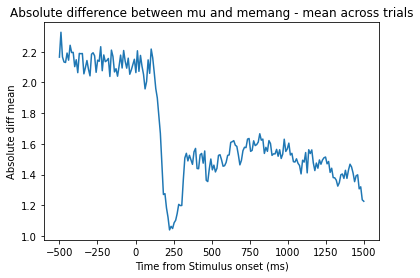

In [9]:
# Plotting the difference between mu_fit and memang - 
# Take an absolute value of the subtraction between mu and original float stimulus pos 

subtracted_matrix = np.zeros((376,200))
for trial_num in range(mu_fit.shape[0]):
    subtraction = np.subtract(mu_fit[trial_num,:], stim_pos_to_float[trial_num])
    subtracted_matrix[trial_num,:] = subtraction
processed_subtracted_matrix = np.abs(subtracted_matrix)
mean_processed_subtracted_matrix = np.mean(processed_subtracted_matrix, axis=0)

x=np.linspace(-500,1500, num=len(mean_processed_subtracted_matrix))
plt.plot(x,mean_processed_subtracted_matrix)
plt.xlabel('Time from Stimulus onset (ms)')
plt.ylabel('Absolute diff mean' )
plt.title('Absolute difference between mu and memang - mean across trials')
plt.show()

Text(0.5, 1.0, 'SD Fit (mean across trials)')

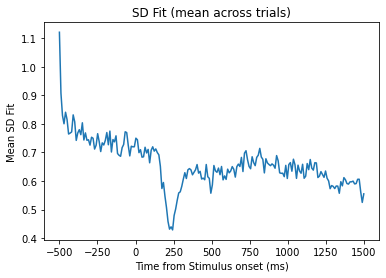

In [10]:
# Plot SD Fit, average across trials 
mean_sd_fit = np.mean(sd_fit, axis=0)
x=np.linspace(-500,1500, num=len(mean_sd_fit))
plt.plot(x, mean_sd_fit)
plt.xlabel('Time from Stimulus onset (ms)')
plt.ylabel('Mean SD Fit')
plt.title('SD Fit (mean across trials)')

Text(0.5, 1.0, 'Resultant')

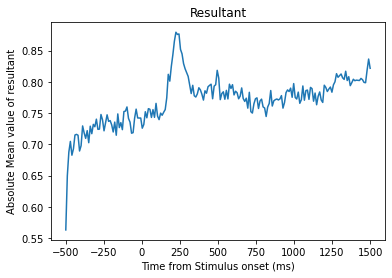

In [11]:
# Plot resultant, average across trials
mean_resultant_magnitude_vec = np.mean(resultant_magnitude_matrix, axis=0)
x=np.linspace(-500,1500, num=len(mean_resultant_magnitude_vec))
plt.plot(x,mean_resultant_magnitude_vec)
plt.xlabel('Time from Stimulus onset (ms)')
plt.ylabel('Absolute Mean value of resultant')
plt.title('Resultant')

Text(0.5, 1.0, 'Mean Maximum Peak Confidence Fit (np.max)')

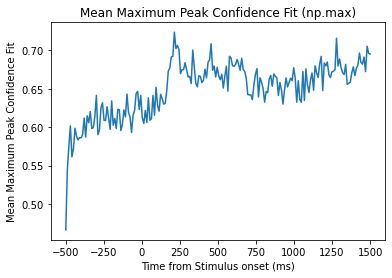

In [19]:
# Mean across the trials, peak of the von mises curve fitting plot 
# peak_plot_matrix = np.load("peak_plot_matrix.npy")

mean_peak = np.mean(curved_fitted_peak, axis=0)
x=np.linspace(-500,1500, num=len(mean_peak))
plt.plot(x,mean_peak)
plt.xlabel('Time from Stimulus onset (ms)')
plt.ylabel('Mean Maximum Peak Confidence Fit')
plt.title('Mean Maximum Peak Confidence Fit (np.max)')

Text(0.5, 1.0, 'Mean Peak Confidence Fit')

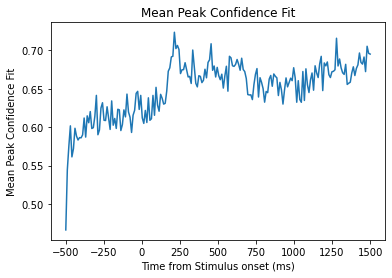

In [18]:
curved_fitted_mean_peak_confidence = np.mean(curved_fitted_peak_confidence, axis=0)
x=np.linspace(-500,1500, num=len(curved_fitted_mean_peak_confidence))
plt.plot(x,mean_peak)
plt.xlabel('Time from Stimulus onset (ms)')
plt.ylabel('Mean Peak Confidence Fit')
plt.title('Mean Peak Confidence Fit')

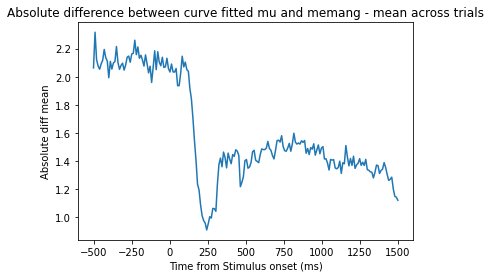

In [15]:
subtracted_matrix_2 = np.zeros((376,200))
for trial_num in range(curve_fitted_mu.shape[0]):
    subtraction = np.subtract(curve_fitted_mu[trial_num,:], stim_pos_to_float[trial_num])
    subtracted_matrix_2[trial_num,:] = subtraction
processed_subtracted_matrix_2 = np.abs(subtracted_matrix_2)
mean_processed_subtracted_matrix_2 = np.mean(processed_subtracted_matrix_2, axis=0)

x=np.linspace(-500,1500, num=len(mean_processed_subtracted_matrix_2))
plt.plot(x,mean_processed_subtracted_matrix_2)
plt.xlabel('Time from Stimulus onset (ms)')
plt.ylabel('Absolute diff mean' )
plt.title('Absolute difference between curve fitted mu and memang - mean across trials')
plt.show()

Text(0.5, 1.0, 'Mean Curve fitted K')

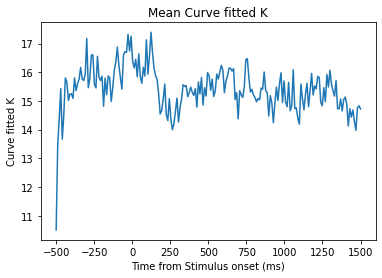

In [16]:
# Curve fitted k
mean_curve_fitted_k = np.mean(curve_fitted_k, axis=0)
x=np.linspace(-500,1500, num=len(mean_curve_fitted_k))
plt.plot(x,mean_curve_fitted_k)
plt.xlabel('Time from Stimulus onset (ms)')
plt.ylabel('Curve fitted K')
plt.title('Mean Curve fitted K')

Text(0.5, 1.0, 'Mean Kappa Fit ')

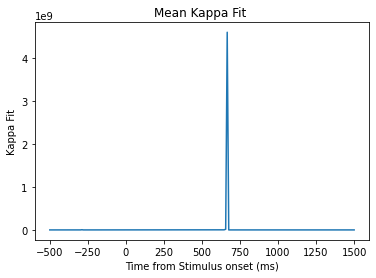

In [20]:
# Kappa
mean_kappa_fit = np.mean(kappa_fit, axis=0)
x=np.linspace(-500,1500, num=len(mean_kappa_fit))
plt.plot(x,mean_kappa_fit)
plt.xlabel('Time from Stimulus onset (ms)')
plt.ylabel('Kappa Fit')
plt.title('Mean Kappa Fit ')